In [1]:
from IPython import display as ipythondisplay
from torch import nn
from transformers import AutoTokenizer, AutoModel
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from transformers import AutoTokenizer, LlamaForCausalLM
from transformers import BertModel, BertConfig, BertTokenizer
import albumentations as A
import cv2
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
import time
import timm
import torch
import torch.nn.functional as F
from PIL import Image
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np  
import json
from torch.utils.data import DataLoader , Dataset
from PIL import Image
import json
import numpy as np  
from collections import Counter
import spacy
import pickle
from transformers import CLIPModel, CLIPProcessor,get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import logging
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from typing import Tuple
import sys
import os
from transformers import AutoModelForCausalLM, AutoTokenizer

import pickle


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
class ReluSIG(nn.Module):
    def __init__(self ,):
        super().__init__()
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        Relumoid = self.gelu(x)*self.sigmoid(torch.square(x))
        return Relumoid

In [3]:
class CFG:
    debug = False
    batch_size = 10
    num_workers = 0
    head_lr = 1e-4#4e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    text_decoder_lr = 1e-5
    weight_decay = 0.02
    patience = 1
    factor = 0.4
    epochs = 10
    model_name = 'resnet101'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_embedding = 512
    # text_encoder_model = "/kaggle/input/gpt-finetuned-mscoco"
    text_encoder_model = "/kaggle/input/gpt-finetuned-final-ver"
    # text_encoder_model = "meta-llama/Llama-2-7b-hf"
    text_embedding = 768
    clipmodel = "openai/clip-vit-base-patch32"
    max_length = 25
    pretrained = True
    trainable = True
    temperature = 1
    size =244
    num_projection_layers = 2
    projection_dim = 256
    dropout = 0.2
    ep_len =10
    num_layers=4
    embed_size=768
    n_heads= 16#metrpchangeS
    forward_expansion=2
    activation ="relu"
    text_decoder = "/kaggle/input/gpt-finetuned-final-ver"
    # text_decodr = "meta-llama/Llama-2-7b-hf"

In [4]:
import re
from nltk.corpus import stopwords
class ClipCocoDataset(Dataset):
    def __init__(self, data_path: str, prefix_length: int, gpt2_type: str = "gpt2",
                 normalize_prefix=False):
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.prefix_length = prefix_length
        self.normalize_prefix = normalize_prefix
        self.stop_words = set(stopwords.words('english'))
        # Load data
        with open(data_path, 'rb') as f:
            all_data = pickle.load(f)
        print("Data size is %0d" % len(all_data["clip_embedding"]))
        sys.stdout.flush()

        self.prefixes = all_data["clip_embedding"]
        captions_raw = all_data["captions"]
        self.image_ids = [caption["image_id"] for caption in captions_raw]
        self.captions = [caption['caption'] for caption in captions_raw]

        # Tokenized captions file path
        tokens_file_path = f"/kaggle/working/{os.path.basename(data_path).split('.')[0]}_{gpt2_type}_tokensv2.pkl"

        if os.path.isfile(tokens_file_path):
            print("Loading tokenized captions from pickle file...")
            with open(tokens_file_path, 'rb') as f:
                self.captions_tokens, self.caption2embedding, self.max_seq_len = pickle.load(f)
        else:
            print("Tokenizing captions and saving to pickle file...")
            self.captions_tokens = []
            self.caption2embedding = []
            max_seq_len = 0

            for caption in captions_raw:
                processed_caption = self.preprocess_caption(caption['caption'])
                tokens = torch.tensor(self.tokenizer.encode(processed_caption), dtype=torch.int64)
                self.captions_tokens.append(tokens)
                self.caption2embedding.append(caption["clip_embedding"])  # Should be an index
                max_seq_len = max(max_seq_len, tokens.shape[0])

            # Save tokenized captions to pickle file
            with open(tokens_file_path, 'wb') as f:
                pickle.dump([self.captions_tokens, self.caption2embedding, max_seq_len], f)

        # Validate indices
        valid_indices = [i for i, idx in enumerate(self.caption2embedding) if idx < len(self.prefixes)]
        if len(valid_indices) < len(self.caption2embedding):
            print(f"Found {len(self.caption2embedding) - len(valid_indices)} invalid indices. Filtering out invalid captions.")
            self.captions_tokens = [self.captions_tokens[i] for i in valid_indices]
            self.caption2embedding = [self.caption2embedding[i] for i in valid_indices]
            self.image_ids = [self.image_ids[i] for i in valid_indices]
            self.captions = [self.captions[i] for i in valid_indices]

        # Compute max sequence length based on tokenized data
        all_len = torch.tensor([len(tokens) for tokens in self.captions_tokens]).float()
        self.max_seq_len = min(int(all_len.mean() + all_len.std() * 10), int(all_len.max()))
    def preprocess_caption(self, caption: str) -> str:
        """
        Preprocesses the caption by normalizing case, removing special characters,
        redundant white spaces, and stopwords.
        """
        # Convert to lowercase
        caption = caption.lower()
        # Remove special characters
        caption = re.sub(r"[^\w\s]", "", caption)  # Retain only letters, digits, and spaces
        caption = re.sub(r"[.,@#$%^&*()<>?/|{}~:;\"']", "", caption)
        # Remove redundant white spaces
        caption = re.sub(r"\s+", " ", caption).strip()
        
        # Remove stopwords
        words = caption.split()
        caption = " ".join([word for word in words if word not in self.stop_words])
        return caption
    def __len__(self) -> int:
        return len(self.captions_tokens)

    def pad_tokens(self, item: int):
        tokens = self.captions_tokens[item]
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
            self.captions_tokens[item] = tokens
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
            self.captions_tokens[item] = tokens
        mask = tokens.ge(0)  # Mask is zero where we are out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)  # Adding prefix mask
        return tokens, mask

    def __getitem__(self, item: int) -> Tuple[torch.Tensor, ...]:
        tokens, mask = self.pad_tokens(item)
        prefix = self.prefixes[self.caption2embedding[item]]  # Use index to get embedding
        if self.normalize_prefix:
            prefix = prefix.float()
            prefix = prefix / prefix.norm(2, -1)
        return tokens, mask, prefix


In [36]:
import os
import re
import pickle
import sys
from typing import Tuple, List
from torch.utils.data import Dataset
import torch
from transformers import GPT2Tokenizer
from nltk.corpus import stopwords

class ClipCocoDataset(Dataset):
    def __init__(self, data_path: str, prefix_length: int, gpt2_type: str = "/kaggle/input/gpt-finetuned-final-ver",
                 normalize_prefix: bool = False):
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        self.prefix_length = prefix_length
        self.normalize_prefix = normalize_prefix
        self.stop_words = set(stopwords.words('english'))

        # Load data
        with open(data_path, 'rb') as f:
            all_data = pickle.load(f)

        print(f"Data size: {len(all_data['clip_embedding'])}")
        sys.stdout.flush()

        self.prefixes = all_data["clip_embedding"]
        captions_raw = all_data["captions"]
        self.image_ids = [caption["image_id"] for caption in captions_raw]
        self.captions = [caption['caption'] for caption in captions_raw]

        # Tokenized captions file path
        tokens_file_path = f"/kaggle/working/{os.path.basename(data_path).split('.')[0]}_tokens.pkl"

        if os.path.isfile(tokens_file_path):
            print("Loading tokenized captions from pickle file...")
            with open(tokens_file_path, 'rb') as f:
                self.captions_tokens, self.caption2embedding, self.max_seq_len = pickle.load(f)
        else:
            print("Tokenizing captions and saving to pickle file...")
            self.captions_tokens = []
            self.caption2embedding = []
            max_seq_len = 0

            for caption in captions_raw:
                processed_caption = self.preprocess_caption(caption['caption'])
                tokens = torch.tensor(self.tokenizer.encode(processed_caption), dtype=torch.int64)
                self.captions_tokens.append(tokens)
                self.caption2embedding.append(caption["clip_embedding"])  # Should be an index
                max_seq_len = max(max_seq_len, tokens.shape[0])

            # Save tokenized captions to pickle file
            with open(tokens_file_path, 'wb') as f:
                pickle.dump([self.captions_tokens, self.caption2embedding, max_seq_len], f)

        # Validate indices and filter invalid data
        valid_indices = [i for i, idx in enumerate(self.caption2embedding) if idx < len(self.prefixes)]
        if len(valid_indices) < len(self.caption2embedding):
            print(f"Filtered out {len(self.caption2embedding) - len(valid_indices)} invalid captions.")
            self.captions_tokens = [self.captions_tokens[i] for i in valid_indices]
            self.caption2embedding = [self.caption2embedding[i] for i in valid_indices]
            self.image_ids = [self.image_ids[i] for i in valid_indices]
            self.captions = [self.captions[i] for i in valid_indices]

        # Compute max sequence length based on tokenized data
        all_lengths = torch.tensor([len(tokens) for tokens in self.captions_tokens], dtype=torch.float32)
        self.max_seq_len = min(int(all_lengths.mean() + all_lengths.std() * 10), int(all_lengths.max()))

    def preprocess_caption(self, caption: str) -> str:
        """
        Preprocess the caption: normalize case, remove special characters,
        and filter out stopwords.
        """
        caption = re.sub(r"[^\w\s]", "", caption.lower())  # Remove non-alphanumeric chars
        words = caption.split()
        return " ".join(word for word in words if word not in self.stop_words)

    def pad_tokens(self, item: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Pad tokens to max sequence length and generate a mask.
        """
        tokens = self.captions_tokens[item]
        padding = self.max_seq_len - len(tokens)

        if padding > 0:
            tokens = torch.cat((tokens, torch.full((padding,), fill_value=-1, dtype=torch.int64)))
        else:
            tokens = tokens[:self.max_seq_len]

        mask = tokens.ge(0).float()  # Mask is 1 where tokens are valid
        tokens[tokens < 0] = 0  # Replace padding with 0

        # Add prefix mask
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)
        return tokens, mask

    
    def __len__(self) -> int:
        return len(self.captions_tokens)

    def __getitem__(self, item: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, str, str]:
        """
        Return padded tokens, mask, prefix embedding, preprocessed caption, and image name for the given item.
        """
        tokens, mask = self.pad_tokens(item)
        prefix = self.prefixes[self.caption2embedding[item]]

        if self.normalize_prefix:
            prefix = prefix.float() / prefix.norm(2, dim=-1, keepdim=True)

        preprocessed_caption = self.preprocess_caption(self.captions[item])
        image_name = self.image_ids[item]  # Retrieve the image name

        return tokens, mask, prefix, preprocessed_caption, image_name

In [37]:
from torch.utils.data import random_split

# Define the dataset
dataset = ClipCocoDataset("/kaggle/input/karapathyv5/oscar_split_ViT-B_32_train.pkl", prefix_length=10)

# Calculate split sizes
train_size = int(0.85* len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_data, test_data = random_split(dataset, [train_size, test_size])

# Print lengths
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")


Data size: 414093
Loading tokenized captions from pickle file...
Filtered out 11 invalid captions.
Train size: 351969
Test size: 62113


In [38]:
from torch.utils.data import random_split
new_dataset = test_data
# Define the dataset
# dataset = ClipCocoDataset("/kaggle/input/karapathyv5/oscar_split_ViT-B_32_train.pkl", prefix_length=4)

# Calculate split sizes
train_size = int(0.95* len(new_dataset))
test_size = len(new_dataset) - train_size

# Split the dataset
train_data, test_data = random_split(new_dataset, [train_size, test_size])

# Print lengths
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

Train size: 59007
Test size: 3106


In [7]:
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

Train size: 59007
Test size: 3106


In [8]:
for i in range(5):
    tokens, mask, prefix,caption = dataset[i]
    # print(dataset.prefix_length)
    print(f"Maximum sequence length: {dataset.max_seq_len}")
    print(f"Element {i + 1}:")
    print(f"Tokens: {tokens.shape}")
    print(f"Mask: {mask}")
    print(f"Caption:{caption}")
    # prefix = prefix.unsqueeze(0)
    print(f"Prefix Embedding: {prefix.size(0)}")
    print("-" * 80)

Maximum sequence length: 25
Element 1:
Tokens: torch.Size([25])
Mask: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Caption:graffitied stop sign across street red car
Prefix Embedding: 512
--------------------------------------------------------------------------------
Maximum sequence length: 25
Element 2:
Tokens: torch.Size([25])
Mask: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Caption:vandalized stop sign red beetle road
Prefix Embedding: 512
--------------------------------------------------------------------------------
Maximum sequence length: 25
Element 3:
Tokens: torch.Size([25])
Mask: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Caption:two peopl

In [39]:

class ImageEncoder(nn.Module):
    """
    Encodes image and returns it's embedding.
    """

    def __init__(self, model='openai/clip-vit-base-patch32', device="cuda"):
        super(ImageEncoder, self).__init__()

        self.device = device

        self.preprocessor = CLIPProcessor.from_pretrained(model)
        self.model = CLIPModel.from_pretrained(model).vision_model.to(self.device)
        # self.model.eval()
        for p in self.model.parameters():
            p.requires_grad = False

    def forward(self, image):
        # only one image at a time
        image = self.preprocessor(images=image, return_tensors="pt").to(self.device)
        image_features = self.model(**image)

        return image_features.pooler_output

In [40]:
class TextDecoder(nn.Module):
    """
    Processes embedding into caption.
    """

    def __init__(self, model =CFG.text_encoder_model , device=CFG.device):
        super(TextDecoder, self).__init__()

        self.device = device

        self.tokenizer = GPT2Tokenizer.from_pretrained(model)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.target_token_idx =0

        self.model =AutoModelForCausalLM.from_pretrained(model).to(self.device)
        # self.model.eval()
        self.vocab_size = self.model.config.vocab_size

        self.freeze_layers()
        
        
    def freeze_layers(self):
        for p in [
            *list(self.model.parameters()),
        ]:  # Freeze everything except the last two layers
            p.requires_grad = False
    
##############################################################################
#         self.freeze_layers()
#     def freeze_layers(self):
#         for p in self.model.parameters():
#             p.requires_grad = False
#         [
#             *list(self.model.parameters())[:-4],
#         ]:  # freeze everything, except 1st and last transformer layer in Decoder
#             p.requires_grad = False
#     def freeze_layers(self):
#         for param in self.model.transformer.wte.parameters():
#             param.requires_grad = False  # Freeze word embeddings
#         for param in self.model.transformer.h.parameters():
#             param.requires_grad = False  # Freeze word embeddings
#         for param in self.model.transformer.wpe.parameters():
#             param.requires_grad = False  # Freeze positional embeddings
        # Freeze all transformer blocks except the last N layers
        # N = 0  # Number of layers to keep trainable
        # for block in self.model.transformer.h[:-N]:
        #     for param in block.parameters():
        #         param.requires_grad = True

    def forward(self, embedding=None, attention_mask=None,input_ids = None,labels=None,train_mode=False):
        assert (embedding is None) != (input_ids is None), "Provide either embedding or input_ids, not both."
        text_features = self.model(
            inputs_embeds=embedding, input_ids=input_ids,labels=labels, attention_mask=attention_mask)
        logits = text_features.logits
        return logits

In [ ]:
class TextDecoder(nn.Module):
    """
    Processes embedding into caption.
    """

    def __init__(self, model =CFG.text_encoder_model , device=CFG.device):
        super(TextDecoder, self).__init__()

        self.device = device

        # self.tokenizer = GPT2Tokenizer.from_pretrained(model)
        # self.tokenizer.pad_token = self.tokenizer.eos_token
        # self.target_token_idx =0

        # self.model = GPT2LMHeadModel.from_pretrained(model).to(self.device)
        self.model = AutoModelForCausalLM.from_pretrained(model,torch_dtype=torch.bfloat16,device_map="auto")

        # self.vocab_size = self.model.config.vocab_size

        self.freeze_layers()
        
        
    def freeze_layers(self):
        for p in [
            *list(self.model.parameters()),
        ]:  # Freeze everything except the last two layers
            p.requires_grad = False
    
##############################################################################
#         self.freeze_layers()
#     def freeze_layers(self):
#         for p in self.model.parameters():
#             p.requires_grad = False
#         [
#             *list(self.model.parameters())[:-4],
#         ]:  # freeze everything, except 1st and last transformer layer in Decoder
#             p.requires_grad = False
#     def freeze_layers(self):
#         for param in self.model.transformer.wte.parameters():
#             param.requires_grad = False  # Freeze word embeddings
#         for param in self.model.transformer.h.parameters():
#             param.requires_grad = False  # Freeze word embeddings
#         for param in self.model.transformer.wpe.parameters():
#             param.requires_grad = False  # Freeze positional embeddings
        # Freeze all transformer blocks except the last N layers
        # N = 0  # Number of layers to keep trainable
        # for block in self.model.transformer.h[:-N]:
        #     for param in block.parameters():
        #         param.requires_grad = True

    def forward(self, embedding=None, attention_mask=None,input_ids = None,labels=None,train_mode=False):
        assert (embedding is None) != (input_ids is None), "Provide either embedding or input_ids, not both."
        text_features = self.model(
            inputs_embeds=embedding, input_ids=input_ids,labels=labels, attention_mask=attention_mask)
        logits = text_features.logits
        return logits

In [73]:
class ImageProjection(nn.Module):
    def __init__(self, ep_len, projection_dim, embedding_dim=CFG.image_embedding):
        super(ImageProjection, self).__init__()
        self.ep_len = ep_len
        self.projection_dim = projection_dim
        
        # First linear projection from embedding_dim to ep_len * projection_dim
        self.projection_1 = nn.Linear(embedding_dim, self.ep_len * self.projection_dim)
        
        # Second linear layer added here
        # self.projection_2 = nn.Linear(self.projection_dim, CFG.text_embedding)
        # encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8,batch_first=True)
        # self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        
        self.gelu = nn.GELU()
        self.gelusig = ReluSIG()
        self.dropout = nn.Dropout(0.3)
        self.layer_norm = nn.LayerNorm(self.projection_dim)
        self.mhai = nn.MultiheadAttention(
            embed_dim=self.projection_dim, num_heads=8, batch_first=True, dropout=0.2
        )

    def forward(self, x, train,return_wt = False):
        # First linear projection
        x = self.projection_1(x)
        x = self.gelusig(x)
        x = self.dropout(x)
        
        # Reshape based on training or evaluation mode
        x = (
            x.view(-1, self.ep_len, self.projection_dim)
            if train
            else x.view(self.ep_len, self.projection_dim)
        )
        x_out,x_wt = self.mhai(x,x,x)
            
        # x_out = self.transformer_encoder(x)
        
        x_out = self.layer_norm(x+x_out)
        if return_wt:
            return x_out,x_wt
        else:
            return x_out


In [74]:

class TextProjection(nn.Module):
    def __init__(self, projection_dim, embedding_dim=CFG.text_embedding):
        super(TextProjection, self).__init__()
        self.projection_t = nn.Linear(embedding_dim, projection_dim)
        self.mhat = nn.MultiheadAttention(
            embed_dim=projection_dim, num_heads=8, batch_first=True, dropout=0.2
        )
        self.gelu = nn.GELU()
        self.gelusig = ReluSIG()
        self.dropout = nn.Dropout(0.35)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x, return_wt = False):
        x = self.projection_t(x)
        x = self.gelusig(x)  # Apply GELU activation
        x_out, x_wt = self.mhat(x, x, x)
        x_out = self.dropout(x_out)  # Apply Dropout after Multihead Attention
        x_out = x + x_out  # Residual connection
        x_out = self.layer_norm(x_out)  # Apply Layer Normalization
        if return_wt:
            return x_out,x_wt
        else:
            return x_out
        return x_out


In [76]:

class EFFN(nn.Module):
    def __init__(self, projection_dim):
        super(EFFN, self).__init__()
        self.ffn = nn.Linear(projection_dim, projection_dim)
        self.gelu = nn.GELU()
        self.gelusig = ReluSIG()
        self.dropout = nn.Dropout(0.01)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        x_out = self.ffn(x)
        x_out = self.gelusig(x_out)  # Apply GELU activation
        x_out = self.dropout(x_out)  # Apply dropout
        x_out = x + x_out  # Residual connection
        x_out = self.layer_norm(x_out)  # Apply Layer Normalization
        return x_out


In [77]:

class CrossAttention(nn.Module):
    def __init__(self,projection_dim):
        super(CrossAttention,self).__init__()
        self.mhca = nn.MultiheadAttention(embed_dim=projection_dim,num_heads=8,batch_first=True)
        self.layer_norm = nn.LayerNorm(projection_dim)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.1)
    def forward(self,x,y):
        x_out,_ = self.mhca(x,y,y)
        x_out = x + x_out
        x_out = self.layer_norm(x_out)
        return x_out



In [78]:
# class XGLAttentionSeq(nn.Module):
#     def __init__(self, embedding_dim, d_p):
#         """
#         XGL Attention for sequential data.
#         embedding_dim: Dimension of the input embedding (shared for Q, K, V)
#         d_p: Dimension of bilinear representation
#         """
#         super(XGLAttentionSeq, self).__init__()
        
#         # Linear layers to project input to Q, K, V
#         self.query_proj = nn.Linear(embedding_dim, embedding_dim)
#         self.key_proj = nn.Linear(embedding_dim, embedding_dim)
#         self.value_proj = nn.Linear(embedding_dim, embedding_dim)
        
#         # Embedding matrices for low-rank bilinear pooling
#         self.omega_k_q = nn.Linear(embedding_dim, d_p)
#         self.omega_k = nn.Linear(embedding_dim, d_p)
#         self.omega_v = nn.Linear(embedding_dim, d_p)
        
#         # Spatial attention embedding and softmax layers
#         self.omega_p = nn.Linear(d_p, d_p)
#         self.omega_b = nn.Linear(d_p, 1)
#         self.batch_norm = nn.BatchNorm1d(d_p)
#         # Skip-Squeeze and Excitation layers
#         self.sse_fc1 = nn.Linear(d_p, d_p // 2)
#         self.sse_fc2 = nn.Linear(d_p // 2, d_p)
#         self.sigmoid = nn.Sigmoid()
        
#         # Fully connected layers for final output
#         self.fc_final = nn.Linear(d_p, d_p)
    
#     def forward(self, x):
#         """
#         Forward pass for XGL Attention with sequential input.
#         x: Input tensor of shape (batch_size, seq_len, embedding_dim)
#         """
#         batch_size, seq_len, embedding_dim = x.size()

#         # Project input to Q, K, V
#         Q = self.query_proj(x)  # Shape: (batch_size, seq_len, embedding_dim)
#         K = self.key_proj(x)    # Shape: (batch_size, seq_len, embedding_dim)
#         V = self.value_proj(x)  # Shape: (batch_size, seq_len, embedding_dim)

#         # Low-rank bilinear pooling for Query-Key interaction
#         Q_proj = F.gelu(self.omega_k_q(Q))  # Shape: (batch_size, seq_len, d_p)
#         K_proj = F.gelu(self.omega_k(K))    # Shape: (batch_size, seq_len, d_p)
#         P_k = Q_proj * K_proj               # Element-wise multiplication -> Shape: (batch_size, seq_len, d_p)

#         # Spatial attention computation
#         S = F.relu(self.omega_p(P_k))       # Shape: (batch_size, seq_len, d_p)
#         S = self.omega_b(S).squeeze(-1)     # Shape: (batch_size, seq_len)
#         S_normalized = F.softmax(S, dim=-1) # Normalized spatial attention weights -> Shape: (batch_size, seq_len)

#         # Low-rank bilinear pooling for Query-Value interaction
#         V_proj = F.gelu(self.omega_v(V))    # Shape: (batch_size, seq_len, d_p)
#         P_v_k = Q_proj * V_proj             # Element-wise multiplication -> Shape: (batch_size, seq_len, d_p)

#         # Instead of summing over seq_len, keep the dimension
#         F_weighted = S_normalized.unsqueeze(-1) * P_v_k  # Shape: (batch_size, seq_len, d_p)

#         # Adjust the SSE block to work per time step
#         B = self.batch_norm(P_k.view(-1, P_k.size(-1)))  # BatchNorm -> Shape: (batch_size * seq_len, d_p)
#         B = B.view(batch_size, seq_len, -1)           # Reshape back to (batch_size, seq_len, d_p)
#         B_sse = self.sigmoid(self.sse_fc2(F.relu(self.sse_fc1(B))))  # SSE attention weights -> Shape: (batch_size, seq_len, d_p)

#         # Channel-wise attention scaling
#         F_final = F_weighted * B_sse  # Shape: (batch_size, seq_len, d_p)

#         # Final output through fully connected layer
#         F_output = self.fc_final(F_final)  # Shape: (batch_size, seq_len, d_p)

#         return F_output


import torch
import torch.nn as nn
import torch.nn.functional as F

class XGLAttentionSeq(nn.Module):
    def __init__(self, embedding_dim, d_p):
        """
        XGL Attention for sequential data.
        embedding_dim: Dimension of the input embedding (shared for Q, K, V)
        d_p: Dimension of bilinear representation
        """
        super(XGLAttentionSeq, self).__init__()
        
        # Linear layers to project input to Q, K, V
        self.query_proj = nn.Linear(embedding_dim, embedding_dim)
        self.key_proj = nn.Linear(embedding_dim, embedding_dim)
        self.value_proj = nn.Linear(embedding_dim, embedding_dim)
        self.gelusig = ReluSIG()
        
        # Embedding matrices for low-rank bilinear pooling
        self.omega_k_q = nn.Linear(embedding_dim, d_p)
        self.omega_k   = nn.Linear(embedding_dim, d_p)
        self.omega_v   = nn.Linear(embedding_dim, d_p)
        
        # Spatial attention embedding and softmax layers
        self.omega_p = nn.Linear(d_p, d_p)
        self.omega_b = nn.Linear(d_p, 1)
        self.batch_norm = nn.BatchNorm1d(d_p)
        
        # Skip-Squeeze and Excitation layers
        self.sse_fc1 = nn.Linear(d_p, d_p // 2)
        self.sse_fc2 = nn.Linear(d_p // 2, d_p)
        self.sigmoid = nn.Sigmoid()
        
        # Fully connected layers for final output
        self.fc_final = nn.Linear(d_p, d_p)

    def forward(self, x, return_wt=False):
        """
        Forward pass for XGL Attention with sequential input.
        x: Input tensor of shape (batch_size, seq_len, embedding_dim)
        return_attn: If True, also returns the attention weights (S_normalized).
        """
        batch_size, seq_len, embedding_dim = x.size()

        # 1. Project input to Q, K, V
        Q = self.query_proj(x)  # Shape: (batch_size, seq_len, embedding_dim)
        K = self.key_proj(x)    # Shape: (batch_size, seq_len, embedding_dim)
        V = self.value_proj(x)  # Shape: (batch_size, seq_len, embedding_dim)

        # 2. Low-rank bilinear pooling for Query-Key interaction
        Q_proj = F.gelu(self.omega_k_q(Q))  # (batch_size, seq_len, d_p)
        K_proj = F.gelu(self.omega_k(K))    # (batch_size, seq_len, d_p)
        P_k = Q_proj * K_proj               # Element-wise multiplication -> (batch_size, seq_len, d_p)

        # 3. Spatial attention computation
        S = F.relu(self.omega_p(P_k))       # (batch_size, seq_len, d_p)
        S = self.omega_b(S).squeeze(-1)     # -> (batch_size, seq_len)
        S_normalized = F.softmax(S, dim=-1) # -> (batch_size, seq_len)

        # 4. Low-rank bilinear pooling for Query-Value interaction
        # V_proj = F.gelu(self.omega_v(V))    # (batch_size, seq_len, d_p)
        V_proj = self.gelusig(self.omega_v(V))    # (batch_size, seq_len, d_p)

        P_v_k = Q_proj * V_proj             # (batch_size, seq_len, d_p)

        # 5. Weighted features with attention
        F_weighted = S_normalized.unsqueeze(-1) * P_v_k  # (batch_size, seq_len, d_p)

        # 6. SSE block per time step
        #    Batch norm is applied to shape (batch_size*seq_len, d_p),
        #    then reshaped back
        B = self.batch_norm(P_k.view(-1, P_k.size(-1)))  # (batch_size*seq_len, d_p)
        B = B.view(batch_size, seq_len, -1)              # (batch_size, seq_len, d_p)
        B_sse = self.sigmoid(self.sse_fc2(F.relu(self.sse_fc1(B))))  # (batch_size, seq_len, d_p)

        # 7. Channel-wise attention scaling
        F_final = F_weighted * B_sse  # (batch_size, seq_len, d_p)

        # 8. Final projection
        F_output = self.fc_final(F_final)  # (batch_size, seq_len, d_p)

        # Optionally return attention weights
        if return_wt:
            # S_normalized has shape (batch_size, seq_len)
            return F_output, S_normalized
        else:
            return F_output

        

In [79]:
class ClipModel(nn.Module):
    def __init__(self,ep_len,projection_dim):
        super().__init__()
        self.ie = ImageEncoder()
        self.td = TextDecoder()
        self.ip_tg = ImageProjection(ep_len=ep_len,projection_dim=projection_dim)
        self.tp_tg = TextProjection(projection_dim=projection_dim)
        self.ip_ig = ImageProjection(ep_len=ep_len,projection_dim=projection_dim)
        self.tp_ig = TextProjection(projection_dim=projection_dim)
        self.criteria = nn.CrossEntropyLoss(ignore_index=0)
        self.ep_len = ep_len
        self.max_len = CFG.max_length
        self.temperature = 1
        self.fc_out = nn.Linear(projection_dim, CFG.text_embedding)
        self.norm = nn.LayerNorm( CFG.text_embedding)
        self.norm_2 = nn.LayerNorm( projection_dim)
        self.enhance_layer_tg = nn.LayerNorm(projection_dim)  # Example layer
        self.enhance_layer_ig = nn.LayerNorm(projection_dim)  # Example layer

        # self.td.model.transformer.wte.weight = self.td.model.lm_head.weight
#         self.enhance_layer = EFFN(projection_dim=projection_dim)
    def calculate_logits(self, embedding1, embedding2):
        embedding2_transposed = embedding2.transpose(1, 2)  # Shape: (batch_size, projection_dim, seq_length2)
        logits = torch.matmul(embedding1, embedding2_transposed) / self.temperature  # Shape: (batch_size, seq_length1, seq_length2)
        return logits
    
    def enhance_embed_txt(self, embedding1, embedding2, logits):
        attn_weights = torch.softmax(logits, dim=-1)  # Softmax over seq_length2
        output = torch.matmul(attn_weights, embedding2)  # Shape: (batch_size, seq_length1, projection_dim)
        enhanced_embedding = embedding1 + output
        enhanced_embedding = self.enhance_layer_tg(enhanced_embedding)
        return enhanced_embedding
    def enhance_embed_img(self, embedding1, embedding2, logits):
        attn_weights = torch.softmax(logits, dim=-1)  # Softmax over seq_length2
        output = torch.matmul(attn_weights, embedding2)  # Shape: (batch_size, seq_length1, projection_dim)
        enhanced_embedding = embedding1 + output
        enhanced_embedding = self.enhance_layer_ig(enhanced_embedding)
        return enhanced_embedding



    def forward(self,img_emb, trg_cap, att_mask):
        # print(f"Input_IDs:     {trg_cap}")
        # print(f"Attention_Mask:     {att_mask}")
    
        x,x_mask = trg_cap[:,:-1], att_mask[:,:-1] #(batch_size, trg_len-1)
        y = trg_cap[:,1:]
        image_projection_tg = self.ip_tg(img_emb,train=True) #(batch_size, ep_len, projection_dim) 
        text_projection = self.td.model.transformer.wte(x) #(batch_size, trg_len-1, d_model)
        # print(f"Embedding_WTE:     {text_projection}")
        # print(text_projection.shape)
        # pos_emb = self.td.model.transformer.wpe(x)
        # print(pos_emb.shape)
        # text_projection = text_projection + pos_emb
        # print(text_projection.shape)
        text_projection_tg = self.tp_tg(text_projection) #(batch_size, trg_len-1, projection_dim)
        
        logits_tg = self.calculate_logits(image_projection_tg,text_projection_tg) #(batch_size,seq_length1,seq_length2)
        enhanced_embedding_tg = self.enhance_embed_txt(image_projection_tg,text_projection_tg, logits_tg) #(batch_size,seq_length1,projection_dim)
#         tg_ffn = self.ffnt(enhanced_embedding_tg) #(batch_size, trg_len-1, projection_dim)
        tg_ffn = enhanced_embedding_tg
        # print(tg_ffn.shape)

        image_projection_ig = self.ip_ig(img_emb,train=True)  #(batch_size, ep_len, projection_dim) 
        text_projection_ig = self.tp_ig(text_projection) #(batch_size, trg_len-1, projection_dim)
        logits_ig = self.calculate_logits(text_projection_ig,image_projection_ig) #(batch_sizee,batch_size)
        enhanced_embedding_ig = self.enhance_embed_img(text_projection_ig,image_projection_ig,logits_ig) #(batch_size,projection_dim)
    
        # ig_ffn = self.ffni(enhanced_embedding_ig) #(batch_size, ep_len+1, projection_dim)
        ig_ffn = enhanced_embedding_ig
        # print(ig_ffn.shape)

        final_emb = torch.concat([ig_ffn, tg_ffn], dim=1)#(batch_size, ep_len+trg_len, projection_dim) 
        final_emb = self.norm_2(final_emb)
        final_emb = self.fc_out(final_emb)
        final_emb = self.norm(final_emb)
        # final_emb = final_emb + text_projection.expand_as(final_emb)

        # print(f"Embedding_FINAL:     {final_emb}")
        # x_mask = torch.concat([torch.ones(x_mask.shape[0], self.ep_len).to(CFG.device), x_mask], dim=1)
        x_mask = x_mask.long()
        # print(f"Input_IDs:     {trg_cap}")
        
        # print(f"x_mask_nexttt:     {x_mask}")
    
        
        pos_emb = self.td.model.transformer.wpe(
            torch.arange(final_emb.shape[1]).to(CFG.device)
        ) #(ep_len+trg_len, d_model)
        pos_emb = pos_emb.expand_as(final_emb) #(batch_size, ep_len+trg_len, d_model)
        final_emb = final_emb + pos_emb #(batch_size, ep_len+trg_len, d_model)
        output = self.td(embedding= final_emb, attention_mask=x_mask) #(batch_size, trg_len-1, vocab_size)
#         print(output.shape)
#         print(y.shape)
        output = output[:, self.ep_len:, : -1]
#         print(output.shape)
        
        loss = self.criteria(output.reshape(-1, output.shape[-1]), y.flatten())#loss
        return loss
    # def evaluate(self, img_emb=None, max_len=None, image=None, temperature=1, beam_width=5):
    #     # self.eval()
    #     if img_emb is None and image is not None:
    #         img_emb = self.ie(image)
    #     elif img_emb is None:
    #         raise ValueError("Either img_emb or image must be provided.")

    #     if max_len is None:
    #         max_len = self.max_len
    #     if temperature is None:
    #         temperature = self.temperature

    #     with torch.no_grad():
    #     # Image projections
    #         image_projection_tg = self.ip_tg(img_emb, train=True)  # (batch_size, ep_len, projection_dim)
    #         image_projection_ig = self.ip_ig(img_emb, train=True)  # (batch_size, ep_len, projection_dim)

    #         batch_size = img_emb.size(0)

    #     # Initialize beams
    #         generated = torch.full(
    #             (batch_size, 1, 1),
    #             self.td.tokenizer.bos_token_id,
    #             dtype=torch.long,
    #             device=CFG.device,
    #         )  # (batch_size, beam_width, seq_len)
    #         scores = torch.zeros(batch_size, 1, device=CFG.device)  # (batch_size, beam_width)

    #     # Expand image projections to match beam width
    #         image_projection_tg = image_projection_tg.unsqueeze(1).repeat(1, beam_width, 1, 1)
    #         image_projection_ig = image_projection_ig.unsqueeze(1).repeat(1, beam_width, 1, 1)

    #         for _ in range(max_len):
    #             batch_size, beam_width_current, seq_len = generated.size()

    #         # Flatten beams
    #             generated_flat = generated.view(batch_size * beam_width_current, seq_len)
    #             image_projection_tg_flat = image_projection_tg.view(
    #                 batch_size * beam_width_current, -1, image_projection_tg.size(-1)
    #             )
    #             image_projection_ig_flat = image_projection_ig.view(
    #                 batch_size * beam_width_current, -1, image_projection_ig.size(-1)
    #             )

    #         # Text embeddings
    #             text_embeddings = self.td.model.transformer.wte(generated_flat)

    #         # Text projections
    #             text_projection_tg = self.tp_tg(text_embeddings)
    #             text_projection_ig = self.tp_ig(text_embeddings)

    #         # Calculate logits and enhanced embeddings
    #             logits_tg = self.calculate_logits(text_projection_tg, image_projection_tg_flat)
    #             enhanced_embedding_tg = self.enhance_embed(text_projection_tg, image_projection_tg_flat, logits_tg)

    #             logits_ig = self.calculate_logits(image_projection_ig_flat, text_projection_ig)
    #             enhanced_embedding_ig = self.enhance_embed(image_projection_ig_flat, text_projection_ig, logits_ig)

    #         # Combine embeddings
    #             final_emb = torch.cat([enhanced_embedding_ig, enhanced_embedding_tg], dim=1)
    #             final_emb = self.fc_out(final_emb)

    #         # Positional embeddings
    #             pos_emb = self.td.model.transformer.wpe(
    #                 torch.arange(final_emb.shape[1]).to(CFG.device)
    #             )
    #             pos_emb = pos_emb.unsqueeze(0).expand_as(final_emb)
    #             final_emb = final_emb + pos_emb

    #         # Attention mask
    #             attention_mask = torch.ones(final_emb.size(0), final_emb.size(1)).to(CFG.device)

    #         # Pass through the decoder
    #             output = self.td(embedding=final_emb, attention_mask=attention_mask)
    #             next_token_logits = output[:, -1, :]  # (batch_size * beam_width_current, vocab_size)
    #             next_token_log_probs = torch.log_softmax(next_token_logits / temperature, dim=-1)

    #         # Update scores
    #             scores = scores.view(batch_size * beam_width_current, 1)
    #             total_scores = scores + next_token_log_probs  # (batch_size * beam_width_current, vocab_size)

    #         # Reshape for topk
    #             total_scores = total_scores.view(batch_size, -1)  # (batch_size, beam_width_current * vocab_size)
    #             top_scores, top_indices = total_scores.topk(beam_width, dim=-1)  # (batch_size, beam_width)

    #         # Compute beam and token indices
    #             beam_indices = top_indices // next_token_log_probs.size(-1)
    #             token_indices = top_indices % next_token_log_probs.size(-1)

    #         # Gather previous sequences
    #             generated = generated.view(batch_size, beam_width_current, -1)
    #             batch_indices = torch.arange(batch_size).unsqueeze(1).expand_as(beam_indices)
    #             prev_generated = generated[batch_indices, beam_indices, :]

    #         # Append new tokens
    #             next_tokens = token_indices.unsqueeze(-1)
    #             generated = torch.cat([prev_generated, next_tokens], dim=-1)

    #         # Update scores
    #             scores = top_scores

    #         # Check for EOS tokens (optional)
    #             eos_mask = (next_tokens == self.td.tokenizer.eos_token_id)
    #             if eos_mask.all():
    #                 break

    #     # Select the best sequences
    #         best_scores, best_indices = scores.max(dim=-1)
    #         best_sequences = generated[torch.arange(batch_size), best_indices, 1:]  # Exclude BOS token

    #         return best_sequences

    def evaluate(self,img_emb=None,max_len=None,image=None,temperature=1,second=False):
        self.eval()
        if second:
            img_emb = self.ie(image)
            print(f"img_emb shape:    {img_emb.shape}")
        else:
            img_emb = img_emb

        if max_len is None:
            max_len = self.max_len
        if temperature is None:
            temperature = self.temperature

        with torch.no_grad():
            # Image projection
            image_projection_tg = self.ip_tg(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            image_projection_ig = self.ip_ig(img_emb,train=True)  # (batch_size, ep_len, projection_dim)

            batch_size = img_emb.size(0)

            # Initialize generated tokens with BOS token
            generated = torch.full(
                (batch_size, 1),
                self.td.tokenizer.bos_token_id,
                dtype=torch.long,
                device=CFG.device,
            )

            # Initialize attention mask
            attention_mask = torch.ones(batch_size, 1).to(CFG.device)
            for _ in range(max_len):
#                 print(generated)
#                 print("hereeeeeeeee")


                # Text embeddings for generated tokens
                text_embeddings = self.td.model.transformer.wte(generated)  # (batch_size, seq_len, d_model)
                text_projection_tg = self.tp_tg(text_embeddings)  # (batch_size, seq_len, projection_dim)
                
#                 print("here1")
                # Self-Attention
                # image_projection_red_t = self.text_guided_sai(image_projection_tg)  # (batch_size, projection_dim)
                # text_projection_red_t = self.text_guided_sat(text_projection_tg)  # (batch_size, projection_dim)
#                 print("here2")
                # Calculate logits and enhance embeddings
                logits_tg = self.calculate_logits(text_projection_tg,image_projection_tg)
                enhanced_embedding_tg = self.enhance_embed_img(
                   text_projection_tg,image_projection_tg,  logits_tg
                )  # (batch_size, projection_dim)
#                 print("here3")
                # Cross-Attention and FFN for text
                # tg_attention = self.textguidedattention(enhanced_embedding_tg, text_projection_red_t)  # (batch_size, projection_dim)
                # tg_attention = tg_attention.unsqueeze(1)  # (batch_size, 1, projection_dim)
                # tg_attention = torch.cat([text_projection, tg_attention], dim=1)  # (batch_size, seq_len + 1, projection_dim)
                tg_ffn = enhanced_embedding_tg  # (batch_size, seq_len + 1, projection_dim)
#                 print("here4")
                # Self-Attention on image projection
                text_projection_ig = self.tp_ig(text_embeddings)  # (batch_size, seq_len, projection_dim)
                # image_projection_red_i = self.image_guided_sai(image_projection_ig)  # (batch_size, projection_dim)
                # text_projection_red_i = self.image_guided_sat(text_projection_ig)  # (batch_size, projection_dim)
                logits_ig = self.calculate_logits(image_projection_ig , text_projection_ig )
                enhanced_embedding_ig = self.enhance_embed_txt(
                    image_projection_ig , text_projection_ig , logits_ig
                )  # (batch_size, projection_dim)

                # Cross-Attention and FFN for image
                # ig_attention = self.imageguidedattention(enhanced_embedding_ig, image_projection_red_i)  # (batch_size, projection_dim)
                # ig_attention = ig_attention.unsqueeze(1)  # (batch_size, 1, projection_dim)
                # ig_attention = torch.cat([image_projection, ig_attention], dim=1)  # (batch_size, ep_len + 1, projection_dim)0
                ig_ffn = enhanced_embedding_ig  # (batch_size, ep_len + 1, projection_dim)

                # Concatenate image and text features
                final_emb = torch.cat([ig_ffn, tg_ffn], dim=1)  # (batch_size, ep_len + seq_len + 1, projection_dim)
                final_emb = self.fc_out(final_emb)
                # final_emb = self.norm(final_emb)# (batch_size, ep_len + seq_len + 1, d_model)
                

                # Positional embeddings
                pos_emb = self.td.model.transformer.wpe(
                    torch.arange(final_emb.shape[1]).to(CFG.device)
                )  # (ep_len + seq_len + 1, d_model)
                pos_emb = pos_emb.unsqueeze(0).expand_as(final_emb)  # (batch_size, ep_len + seq_len + 1, d_model)
                final_emb = final_emb + pos_emb  # (batch_size, ep_len + seq_len + 1, d_model)

                # Update attention mask
                x_mask = torch.cat(
                    [torch.ones(batch_size, ig_ffn.shape[1]).to(CFG.device), attention_mask], dim=1
                )  # (batch_size, total_seq_len)

                # Pass through the text decoder
                output = self.td(embedding=final_emb, attention_mask=x_mask)
#                 print("outputshape:  ",output.shape)# (batch_size, total_seq_len, vocab_size)

                # Get the logits for the next token
                next_token_logits = output[:, -1, :]
        
#                 print(next_token_logits)# (batch_size, vocab_size)
                next_token_logits = next_token_logits / temperature
                probs = torch.softmax(next_token_logits, dim=-1)

                # Greedy decoding (you can use sampling or beam search here)
                next_token = torch.argmax(probs, dim=-1).unsqueeze(1)  # (batch_size, 1)

                # Append the generated token
                generated = torch.cat([generated, next_token], dim=1)  # (batch_size, seq_len + 1)
#                 print(generated)
                attention_mask = torch.cat(
                    [attention_mask, torch.ones(batch_size, 1).to(CFG.device)], dim=1
                )  # (batch_size, seq_len + 1)

                # Stop if all sequences have generated the EOS token
                if torch.all(next_token == self.td.tokenizer.eos_token_id):
                    break

            # Return generated tokens (excluding the initial BOS token)
            return generated[:, 1:]







In [80]:
class ClipModel(nn.Module):
    def __init__(self,ep_len,projection_dim):
        super().__init__()
        self.ie = ImageEncoder()
        self.td = TextDecoder()
        self.ip_tg = ImageProjection(ep_len=ep_len,projection_dim=projection_dim)
        self.tp_tg = TextProjection(projection_dim=projection_dim)
        self.ip_ig = ImageProjection(ep_len=ep_len,projection_dim=projection_dim)
        self.tp_ig = TextProjection(projection_dim=projection_dim)
        self.criteria = nn.CrossEntropyLoss(ignore_index=0)
        self.ep_len = ep_len
        self.max_len = CFG.max_length
        self.temperature = 1
        self.fc_out = nn.Linear(CFG.image_embedding, CFG.text_embedding)
        self.norm = nn.LayerNorm( CFG.text_embedding)
        self.norm_2 = nn.LayerNorm( CFG.image_embedding)
        self.enhance_layer_tg = nn.LayerNorm(projection_dim)  # Example layer
        self.enhance_layer_ig = nn.LayerNorm(projection_dim)  # Example layer
        self.lstm_1 = nn.LSTM(input_size=projection_dim,hidden_size=projection_dim,num_layers=2,batch_first=True,dropout=0.1,bidirectional=True)
        self.lstm_2 = nn.LSTM(input_size=projection_dim,hidden_size=projection_dim,num_layers=2,batch_first=True,dropout=0.1,bidirectional=True)
        # self.output = nn.Linear(CFG.text_embedding,50257)
        # self.out_norm= nn.LayerNorm(50257)
        self.gpt_norm = nn.LayerNorm(CFG.text_embedding)
        #example use of lstm_1
        # lstm_1_out, _ = self.lstm_1(final_emb)

        # self.td.model.transformer.wte.weight = self.td.model.lm_head.weight
#         self.enhance_layer = EFFN(projection_dim=projection_dim)
    def calculate_logits(self, embedding1, embedding2):
        embedding2_transposed = embedding2.transpose(1, 2)  # Shape: (batch_size, projection_dim, seq_length2)
        logits = torch.matmul(embedding1, embedding2_transposed) / self.temperature  # Shape: (batch_size, seq_length1, seq_length2)
        return logits
    
    def enhance_embed_txt(self, embedding1, embedding2, logits):
        attn_weights = torch.softmax(logits, dim=-1)  # Softmax over seq_length2
        output = torch.matmul(attn_weights, embedding2)  # Shape: (batch_size, seq_length1, projection_dim)
        enhanced_embedding = embedding1 + output
        enhanced_embedding = self.enhance_layer_tg(enhanced_embedding)
        return enhanced_embedding
    def enhance_embed_img(self, embedding1, embedding2, logits):
        attn_weights = torch.softmax(logits, dim=-1)  # Softmax over seq_length2
        output = torch.matmul(attn_weights, embedding2)  # Shape: (batch_size, seq_length1, projection_dim)
        enhanced_embedding = embedding1 + output
        enhanced_embedding = self.enhance_layer_ig(enhanced_embedding)
        return enhanced_embedding
    def top_k_logits(self,logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[..., [-1]]] = -float('Inf')
        return out



    def forward(self,img_emb, trg_cap, att_mask):
        # print(f"Input_IDs:     {trg_cap}")
        # print(f"Attention_Mask:     {att_mask}")
    
        x,x_mask = trg_cap[:,:-1], att_mask[:,:-1] #(batch_size, trg_len-1)
        y = trg_cap[:,1:]
        image_projection_tg = self.ip_tg(img_emb,train=True) #(batch_size, ep_len, projection_dim) 
        text_projection = self.td.model.transformer.wte(x)
        text_projection = self.gpt_norm(text_projection)
        # text_projection = self.gpt_norm(text_projection)
        #(batch_size, trg_len-1, d_model)
        # print(f"Embedding_WTE:     {text_projection}")
        # print(text_projection.shape)
        # pos_emb = self.td.model.transformer.wpe(x)
        # print(pos_emb.shape)
        # text_projection = text_projection + pos_emb
        # print(text_projection.shape)
        text_projection_tg = self.tp_tg(text_projection) #(batch_size, trg_len-1, projection_dim)
        
        logits_tg = self.calculate_logits(image_projection_tg,text_projection_tg) #(batch_size,seq_length1,seq_length2)
        enhanced_embedding_tg = self.enhance_embed_txt(image_projection_tg,text_projection_tg, logits_tg) #(batch_size,seq_length1,projection_dim)
#         tg_ffn = self.ffnt(enhanced_embedding_tg) #(batch_size, trg_len-1, projection_dim)
        tg_ffn = enhanced_embedding_tg
        # print(tg_ffn.shape)

        image_projection_ig = self.ip_ig(img_emb,train=True)  #(batch_size, ep_len, projection_dim) 
        text_projection_ig = self.tp_ig(text_projection) #(batch_size, trg_len-1, projection_dim)
        logits_ig = self.calculate_logits(text_projection_ig,image_projection_ig) #(batch_sizee,batch_size)
        enhanced_embedding_ig = self.enhance_embed_img(text_projection_ig,image_projection_ig,logits_ig) #(batch_size,projection_dim)
    
        # ig_ffn = self.ffni(enhanced_embedding_ig) #(batch_size, ep_len+1, projection_dim)
        ig_ffn = enhanced_embedding_ig
        # print(ig_ffn.shape)

        # print(ig_ffn.shape)
        lstm_layer_1,_ = self.lstm_1(torch.cat([ig_ffn, tg_ffn], dim=1)) #(batch_size, trg_len-1, projection_dim)
        lstm_layer_2,_ = self.lstm_2(torch.cat([tg_ffn, ig_ffn], dim=1)) #(batch_size, ep_len+1, projection_dim)
        final_emb = lstm_layer_1 + lstm_layer_2 #(batch_size, ep_len+trg_len, projection_dim)
        # print(final_emb.shape)
        # final_emb = torch.concat([ig_ffn, tg_ffn], dim=1)#(batch_size, ep_len+trg_len, projection_dim) 
        # final_emb = self.norm_2(final_emb)
        final_emb = self.fc_out(final_emb)
        final_emb = self.norm(final_emb)
        # final_emb = final_emb + text_projection.expand_as(final_emb)

        # print(f"Embedding_FINAL:     {final_emb}")
        # x_mask = torch.concat([torch.ones(x_mask.shape[0], self.ep_len).to(CFG.device), x_mask], dim=1)
        x_mask = x_mask.long()
        # print(x_mask.shape)
        # print(f"Input_IDs:     {trg_cap}")
        
        # print(f"x_mask_nexttt:     {x_mask}")
    
        
        pos_emb = self.td.model.transformer.wpe(
            torch.arange(final_emb.shape[1]).to(CFG.device)
        ) #(ep_len+trg_len, d_model)
        pos_emb = pos_emb.expand_as(final_emb) #(batch_size, ep_len+trg_len, d_model)
        final_emb = final_emb + pos_emb #(batch_size, ep_len+trg_len, d_model)
        # print(final_emb.shape)
        # print(x_mask.shape)
        output = self.td(embedding= final_emb,attention_mask=x_mask) #(batch_size, trg_len-1, vocab_size)
        # output = self.out_norm(output)
        # output = self.output(final_emb)
        
        
        
#         print(output.shape)
#         print(y.shape)
        output = output[:, self.ep_len:, : -1]
#         print(output.shape)
        
        loss = self.criteria(output.reshape(-1, output.shape[-1]), y.flatten())#loss
        return loss
    # def evaluate(self, img_emb=None, max_len=None, image=None, temperature=1, beam_width=5):
    #     # self.eval()
    #     if img_emb is None and image is not None:
    #         img_emb = self.ie(image)
    #     elif img_emb is None:
    #         raise ValueError("Either img_emb or image must be provided.")

    #     if max_len is None:
    #         max_len = self.max_len
    #     if temperature is None:
    #         temperature = self.temperature

    #     with torch.no_grad():
    #     # Image projections
    #         image_projection_tg = self.ip_tg(img_emb, train=True)  # (batch_size, ep_len, projection_dim)
    #         image_projection_ig = self.ip_ig(img_emb, train=True)  # (batch_size, ep_len, projection_dim)

    #         batch_size = img_emb.size(0)

    #     # Initialize beams
    #         generated = torch.full(
    #             (batch_size, 1, 1),
    #             self.td.tokenizer.bos_token_id,
    #             dtype=torch.long,
    #             device=CFG.device,
    #         )  # (batch_size, beam_width, seq_len)
    #         scores = torch.zeros(batch_size, 1, device=CFG.device)  # (batch_size, beam_width)

    #     # Expand image projections to match beam width
    #         image_projection_tg = image_projection_tg.unsqueeze(1).repeat(1, beam_width, 1, 1)
    #         image_projection_ig = image_projection_ig.unsqueeze(1).repeat(1, beam_width, 1, 1)

    #         for _ in range(max_len):
    #             batch_size, beam_width_current, seq_len = generated.size()

    #         # Flatten beams
    #             generated_flat = generated.view(batch_size * beam_width_current, seq_len)
    #             image_projection_tg_flat = image_projection_tg.view(
    #                 batch_size * beam_width_current, -1, image_projection_tg.size(-1)
    #             )
    #             image_projection_ig_flat = image_projection_ig.view(
    #                 batch_size * beam_width_current, -1, image_projection_ig.size(-1)
    #             )

    #         # Text embeddings
    #             text_embeddings = self.td.model.transformer.wte(generated_flat)

    #         # Text projections
    #             text_projection_tg = self.tp_tg(text_embeddings)
    #             text_projection_ig = self.tp_ig(text_embeddings)

    #         # Calculate logits and enhanced embeddings
    #             logits_tg = self.calculate_logits(text_projection_tg, image_projection_tg_flat)
    #             enhanced_embedding_tg = self.enhance_embed(text_projection_tg, image_projection_tg_flat, logits_tg)

    #             logits_ig = self.calculate_logits(image_projection_ig_flat, text_projection_ig)
    #             enhanced_embedding_ig = self.enhance_embed(image_projection_ig_flat, text_projection_ig, logits_ig)

    #         # Combine embeddings
    #             final_emb = torch.cat([enhanced_embedding_ig, enhanced_embedding_tg], dim=1)
    #             final_emb = self.fc_out(final_emb)

    #         # Positional embeddings
    #             pos_emb = self.td.model.transformer.wpe(
    #                 torch.arange(final_emb.shape[1]).to(CFG.device)
    #             )
    #             pos_emb = pos_emb.unsqueeze(0).expand_as(final_emb)
    #             final_emb = final_emb + pos_emb

    #         # Attention mask
    #             attention_mask = torch.ones(final_emb.size(0), final_emb.size(1)).to(CFG.device)

    #         # Pass through the decoder
    #             output = self.td(embedding=final_emb, attention_mask=attention_mask)
    #             next_token_logits = output[:, -1, :]  # (batch_size * beam_width_current, vocab_size)
    #             next_token_log_probs = torch.log_softmax(next_token_logits / temperature, dim=-1)

    #         # Update scores
    #             scores = scores.view(batch_size * beam_width_current, 1)
    #             total_scores = scores + next_token_log_probs  # (batch_size * beam_width_current, vocab_size)

    #         # Reshape for topk
    #             total_scores = total_scores.view(batch_size, -1)  # (batch_size, beam_width_current * vocab_size)
    #             top_scores, top_indices = total_scores.topk(beam_width, dim=-1)  # (batch_size, beam_width)

    #         # Compute beam and token indices
    #             beam_indices = top_indices // next_token_log_probs.size(-1)
    #             token_indices = top_indices % next_token_log_probs.size(-1)

    #         # Gather previous sequences
    #             generated = generated.view(batch_size, beam_width_current, -1)
    #             batch_indices = torch.arange(batch_size).unsqueeze(1).expand_as(beam_indices)
    #             prev_generated = generated[batch_indices, beam_indices, :]

    #         # Append new tokens
    #             next_tokens = token_indices.unsqueeze(-1)
    #             generated = torch.cat([prev_generated, next_tokens], dim=-1)

    #         # Update scores
    #             scores = top_scores

    #         # Check for EOS tokens (optional)
    #             eos_mask = (next_tokens == self.td.tokenizer.eos_token_id)
    #             if eos_mask.all():
    #                 break

    #     # Select the best sequences
    #         best_scores, best_indices = scores.max(dim=-1)
    #         best_sequences = generated[torch.arange(batch_size), best_indices, 1:]  # Exclude BOS token

    #         return best_sequences

    def evaluate(self,img_emb=None,max_len=None,image=None,temperature=1,second=False):
        # self.eval()
        if second:
            img_emb = self.ie(image)
            print(f"img_emb shape:    {img_emb.shape}")
        else:
            img_emb = img_emb

        if max_len is None:
            max_len = self.max_len
        if temperature is None:
            temperature = self.temperature

        with torch.no_grad():
            # Image projection
            image_projection_tg = self.ip_tg(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            image_projection_ig = self.ip_ig(img_emb,train=True)  # (batch_size, ep_len, projection_dim)

            batch_size = img_emb.size(0)

            # Initialize generated tokens with BOS token
            generated = torch.full(
                (batch_size, 1),
                self.td.tokenizer.bos_token_id,
                dtype=torch.long,
                device=CFG.device,
            )

            # Initialize attention mask
            attention_mask = torch.ones(batch_size, 1).to(CFG.device)
            for _ in range(max_len):
#                 print(generated)
#                 print("hereeeeeeeee")


                # Text embeddings for generated tokens
                text_embeddings = self.td.model.transformer.wte(generated)  # (batch_size, seq_len, d_model)
                text_projection_tg = self.tp_tg(text_embeddings)  # (batch_size, seq_len, projection_dim)
                
#                 print("here1")
                # Self-Attention
                # image_projection_red_t = self.text_guided_sai(image_projection_tg)  # (batch_size, projection_dim)
                # text_projection_red_t = self.text_guided_sat(text_projection_tg)  # (batch_size, projection_dim)
#                 print("here2")
                # Calculate logits and enhance embeddings
                logits_tg = self.calculate_logits(text_projection_tg,image_projection_tg)
                enhanced_embedding_tg = self.enhance_embed_img(
                   text_projection_tg,image_projection_tg,  logits_tg
                )  # (batch_size, projection_dim)
#                 print("here3")
                # Cross-Attention and FFN for text
                # tg_attention = self.textguidedattention(enhanced_embedding_tg, text_projection_red_t)  # (batch_size, projection_dim)
                # tg_attention = tg_attention.unsqueeze(1)  # (batch_size, 1, projection_dim)
                # tg_attention = torch.cat([text_projection, tg_attention], dim=1)  # (batch_size, seq_len + 1, projection_dim)
                tg_ffn = enhanced_embedding_tg  # (batch_size, seq_len + 1, projection_dim)
#                 print("here4")
                # Self-Attention on image projection
                text_projection_ig = self.tp_ig(text_embeddings)  # (batch_size, seq_len, projection_dim)
                # image_projection_red_i = self.image_guided_sai(image_projection_ig)  # (batch_size, projection_dim)
                # text_projection_red_i = self.image_guided_sat(text_projection_ig)  # (batch_size, projection_dim)
                logits_ig = self.calculate_logits(image_projection_ig , text_projection_ig )
                enhanced_embedding_ig = self.enhance_embed_txt(
                    image_projection_ig , text_projection_ig , logits_ig
                )  # (batch_size, projection_dim)

                # Cross-Attention and FFN for image
                # ig_attention = self.imageguidedattention(enhanced_embedding_ig, image_projection_red_i)  # (batch_size, projection_dim)
                # ig_attention = ig_attention.unsqueeze(1)  # (batch_size, 1, projection_dim)
                # ig_attention = torch.cat([image_projection, ig_attention], dim=1)  # (batch_size, ep_len + 1, projection_dim)
                ig_ffn = enhanced_embedding_ig  # (batch_size, ep_len + 1, projection_dim)

                # Concatenate image and text features
                lstm_layer_1,_ = self.lstm_1(torch.cat([ig_ffn, tg_ffn], dim=1)) #(batch_size, trg_len-1, projection_dim)
                lstm_layer_2,_ = self.lstm_2(torch.cat([tg_ffn, ig_ffn], dim=1)) #(batch_size, ep_len+1, projection_dim)
                final_emb = lstm_layer_1 + lstm_layer_2 # (batch_size, ep_len + seq_len + 1, projection_dim)
                final_emb = self.fc_out(final_emb)
                # final_emb = self.norm(final_emb)# (batch_size, ep_len + seq_len + 1, d_model)
                

                # Positional embeddings
                pos_emb = self.td.model.transformer.wpe(
                    torch.arange(final_emb.shape[1]).to(CFG.device)
                )  # (ep_len + seq_len + 1, d_model)
                pos_emb = pos_emb.unsqueeze(0).expand_as(final_emb)  # (batch_size, ep_len + seq_len + 1, d_model)
                final_emb = final_emb + pos_emb  # (batch_size, ep_len + seq_len + 1, d_model)

                # Update attention mask
                x_mask = torch.cat(
                    [torch.ones(batch_size, ig_ffn.shape[1]).to(CFG.device), attention_mask], dim=1
                )  # (batch_size, total_seq_len)

                # Pass through the text decoder
                output = self.td(embedding=final_emb, attention_mask=x_mask)
#                 print("outputshape:  ",output.shape)# (batch_size, total_seq_len, vocab_size)

                # Get the logits for the next token
                next_token_logits = output[:, -1, :]
        
#                 print(next_token_logits)# (batch_size, vocab_size)
                next_token_logits = next_token_logits / temperature
                probs = torch.softmax(next_token_logits, dim=-1)

                # Greedy decoding (you can use sampling or beam search here)
                next_token = torch.argmax(probs, dim=-1).unsqueeze(1)  # (batch_size, 1)

                # Append the generated token
                generated = torch.cat([generated, next_token], dim=1)  # (batch_size, seq_len + 1)
#                 print(generated)
                attention_mask = torch.cat(
                    [attention_mask, torch.ones(batch_size, 1).to(CFG.device)], dim=1
                )  # (batch_size, seq_len + 1)

                # Stop if all sequences have generated the EOS token
                if torch.all(next_token == self.td.tokenizer.eos_token_id):
                    break

            # Return generated tokens (excluding the initial BOS token)
            return generated[:, 1:]

    def evaluate(self, img_emb=None, max_len=None, image=None, temperature=1.5, top_k=25):
        
         if img_emb is None and image is not None:
             img_emb = self.ie(image)
         elif img_emb is None:
             raise ValueError("Either img_emb or image must be provided.")

         if max_len is None:
             max_len = self.max_len

         with torch.no_grad():
             image_projection_tg = self.ip_tg(img_emb, train=True)
             image_projection_ig = self.ip_ig(img_emb, train=True)

             batch_size = img_emb.size(0)
             generated = torch.full(
                 (batch_size, 1),
                 self.td.tokenizer.bos_token_id,
                 dtype=torch.long,
                 device=CFG.device,
             )

             attention_mask = torch.ones(batch_size, 1).to(CFG.device)
             generated_tokens = []

             for _ in range(max_len):
                 text_embeddings = self.td.model.transformer.wte(generated)
                # text_embeddings = self.xgl_attention_txt(text_embeddings)
                 text_projection_tg = self.tp_tg(text_embeddings)

                 logits_tg = self.calculate_logits(text_projection_tg, image_projection_tg)
                 enhanced_embedding_tg = self.enhance_embed_img(
                     text_projection_tg, image_projection_tg, logits_tg
                 )
                 tg_ffn = enhanced_embedding_tg

                 text_projection_ig = self.tp_ig(text_embeddings)
                 logits_ig = self.calculate_logits(image_projection_ig, text_projection_ig)
                 enhanced_embedding_ig = self.enhance_embed_txt(
                     image_projection_ig, text_projection_ig, logits_ig
                 )
                 ig_ffn = enhanced_embedding_ig

                 lstm_layer_1, _ = self.lstm_1(torch.cat([ig_ffn, tg_ffn], dim=1))
                 lstm_layer_2, _ = self.lstm_2(torch.cat([tg_ffn, ig_ffn], dim=1))
                 final_emb = lstm_layer_1 + lstm_layer_2
                # final_emb = self.xgl_attention(final_emb)
                 final_emb = self.fc_out(final_emb)

                 seq_length = final_emb.size(1)
                 position_ids = torch.arange(seq_length, dtype=torch.long, device=CFG.device)
                 position_ids = position_ids.unsqueeze(0).expand(batch_size, seq_length)
                 pos_emb = self.td.model.transformer.wpe(position_ids)
                 final_emb = final_emb + pos_emb

                 x_mask = torch.cat(
                     [torch.ones(batch_size, ig_ffn.shape[1]).to(CFG.device), attention_mask], dim=1
                 )

                 output = self.td(embedding=final_emb, attention_mask=x_mask)
                 next_token_logits = output[:, -1, :] / temperature

            # Apply top-k sampling
                 filtered_logits = self.top_k_logits(next_token_logits, top_k)
                 probs = torch.softmax(filtered_logits, dim=-1)
                 next_token = torch.multinomial(probs, num_samples=1)
                 generated = torch.cat([generated, next_token], dim=1)
                 attention_mask = torch.cat(
                     [attention_mask, torch.ones(batch_size, 1).to(CFG.device)], dim=1
                 )

                 generated_tokens.append(next_token.item())

                 if torch.all(next_token == self.td.tokenizer.eos_token_id):
                     break
             return generated[:, 1:]








In [96]:
class ClipModel(nn.Module):
    def __init__(self,ep_len,projection_dim):
        super().__init__()
        self.ie = ImageEncoder()
        self.td = TextDecoder()
        self.ip_tg = ImageProjection(ep_len=ep_len,projection_dim=projection_dim)
        self.tp_tg = TextProjection(projection_dim=projection_dim)
        self.ip_ig = ImageProjection(ep_len=ep_len,projection_dim=projection_dim)
        self.tp_ig = TextProjection(projection_dim=projection_dim)
        self.criteria = nn.CrossEntropyLoss(ignore_index=0)
        self.ep_len = ep_len
        self.max_len = CFG.max_length
        self.temperature = 1
        self.fc_out = nn.Linear(CFG.image_embedding, CFG.text_embedding)
        self.norm = nn.LayerNorm( CFG.text_embedding)
        self.norm_2 = nn.LayerNorm( 512)
        self.enhance_layer_tg = nn.LayerNorm(projection_dim)  # Example layer
        self.enhance_layer_ig = nn.LayerNorm(projection_dim)  # Example layer
        self.lstm_1 = nn.LSTM(input_size=projection_dim,hidden_size=projection_dim,num_layers=2,batch_first=True,dropout=0.2,bidirectional=True)
        self.lstm_2 = nn.LSTM(input_size=projection_dim,hidden_size=projection_dim,num_layers=2,batch_first=True,dropout=0.2,bidirectional=True)
        d_p = 512  # Or choose an appropriate value less than projection_dim
        self.xgl_attention = XGLAttentionSeq(embedding_dim=512, d_p=d_p)
        self.xgl_attention_txt = XGLAttentionSeq(embedding_dim=768, d_p=768)
        self.xgl_att_img = XGLAttentionSeq(embedding_dim = 256,d_p = 256)
        self.out_norm= nn.LayerNorm(50257)
        #example use of lstm_1
        # lstm_1_out, _ = self.lstm_1(final_emb)

        # self.td.model.transformer.wte.weight = self.td.model.lm_head.weight
#         self.enhance_layer = EFFN(projection_dim=projection_dim)
    def calculate_logits(self, embedding1, embedding2):
        embedding2_transposed = embedding2.transpose(1, 2)  # Shape: (batch_size, projection_dim, seq_length2)
        logits = torch.matmul(embedding1, embedding2_transposed) / self.temperature  # Shape: (batch_size, seq_length1, seq_length2)
        return logits
    
    def enhance_embed_txt(self, embedding1, embedding2, logits):
        attn_weights = torch.softmax(logits, dim=-1)  # Softmax over seq_length2
        output = torch.matmul(attn_weights, embedding2)  # Shape: (batch_size, seq_length1, projection_dim)
        enhanced_embedding = embedding1 + output
        enhanced_embedding = self.enhance_layer_tg(enhanced_embedding)
        return enhanced_embedding
    def enhance_embed_img(self, embedding1, embedding2, logits):
        attn_weights = torch.softmax(logits, dim=-1)  # Softmax over seq_length2
        output = torch.matmul(attn_weights, embedding2)  # Shape: (batch_size, seq_length1, projection_dim)
        enhanced_embedding = embedding1 + output
        enhanced_embedding = self.enhance_layer_ig(enhanced_embedding)
        return enhanced_embedding
    def top_k_logits(self,logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[..., [-1]]] = -float('Inf')
        return out


    def forward(self,img_emb, trg_cap, att_mask):
        # print(f"Input_IDs:     {trg_cap}")
        # print(f"Attention_Mask:     {att_mask}")
    
        x,x_mask = trg_cap[:,:-1], att_mask[:,:-1] #(batch_size, trg_len-1)
        y = trg_cap[:,1:]
        image_projection_tg = self.ip_tg(img_emb,train=True) #(batch_size, ep_len, projection_dim) 
        image_projection_tg = self.xgl_att_img(image_projection_tg)
        text_projection = self.td.model.transformer.wte(x)
        # text_projection = self.gpt_norm(text_projection)#(batch_size, trg_len-1, d_model)
        text_projection = self.xgl_attention_txt(text_projection)
        # print(f"Embedding_WTE:     {text_projection}")
        # print(text_projection.shape)
        # pos_emb = self.td.model.transformer.wpe(x)
        # print(pos_emb.shape)
        # text_projection = text_projection + pos_emb
        # print(text_projection.shape)
        text_projection_tg = self.tp_tg(text_projection) #(batch_size, trg_len-1, projection_dim)
        
        logits_tg = self.calculate_logits(image_projection_tg,text_projection_tg) #(batch_size,seq_length1,seq_length2)
        enhanced_embedding_tg = self.enhance_embed_txt(image_projection_tg,text_projection_tg, logits_tg) #(batch_size,seq_length1,projection_dim)
#         tg_ffn = self.ffnt(enhanced_embedding_tg) #(batch_size, trg_len-1, projection_dim)
        tg_ffn = enhanced_embedding_tg
        # print(tg_ffn.shape)

        image_projection_ig = self.ip_ig(img_emb,train=True)  #(batch_size, ep_len, projection_dim) 
        image_projection_ig = self.xgl_att_img(image_projection_ig)
        text_projection_ig = self.tp_ig(text_projection) #(batch_size, trg_len-1, projection_dim)
        logits_ig = self.calculate_logits(text_projection_ig,image_projection_ig) #(batch_sizee,batch_size)
        enhanced_embedding_ig = self.enhance_embed_img(text_projection_ig,image_projection_ig,logits_ig) #(batch_size,projection_dim)
    
        # ig_ffn = self.ffni(enhanced_embedding_ig) #(batch_size, ep_len+1, projection_dim)
        ig_ffn = enhanced_embedding_ig
        # print(ig_ffn.shape)

        # print(ig_ffn.shape)
        lstm_layer_1,_ = self.lstm_1(torch.cat([ig_ffn, tg_ffn], dim=1)) #(batch_size, trg_len-1, projection_dim)
        lstm_layer_2,_ = self.lstm_2(torch.cat([tg_ffn, ig_ffn], dim=1)) #(batch_size, ep_len+1, projection_dim)
        final_emb = lstm_layer_1 + lstm_layer_2 #(batch_size, ep_len+trg_len, projection_dim)
        # print(final_emb.shape)
        # final_emb = torch.concat([ig_ffn, tg_ffn], dim=1)#(batch_size, ep_len+trg_len, projection_dim) 
        final_emb = self.xgl_attention(final_emb)
        final_emb = self.norm_2(final_emb)

        final_emb = self.fc_out(final_emb)
        final_emb = self.norm(final_emb)
        
        # final_emb = final_emb + text_projection.expand_as(final_emb)

        # print(f"Embedding_FINAL:     {final_emb}")
        # x_mask = torch.concat([torch.ones(x_mask.shape[0], self.ep_len).to(CFG.device), x_mask], dim=1)
        x_mask = x_mask.long()
        # print(x_mask.shape)
        # print(f"Input_IDs:     {trg_cap}")
        
        # print(f"x_mask_nexttt:     {x_mask}")
    
        
        pos_emb = self.td.model.transformer.wpe(
            torch.arange(final_emb.shape[1]).to(CFG.device)
        ) #(ep_len+trg_len, d_model)
        pos_emb = pos_emb.expand_as(final_emb) #(batch_size, ep_len+trg_len, d_model)
        final_emb = final_emb + pos_emb #(batch_size, ep_len+trg_len, d_model)
        # print(final_emb.shape)
        output = self.td(embedding= final_emb,attention_mask=x_mask) #(batch_size, trg_len-1, vocab_size)
        output = self.out_norm(output)
#         print(output.shape)
#         print(y.shape)
        output = output[:, self.ep_len:, : -1]
#         print(output.shape)
        
        loss = self.criteria(output.reshape(-1, output.shape[-1]), y.flatten())#loss
        return loss
    # def evaluate(self, img_emb=None, max_len=None, image=None, temperature=1, beam_width=5):
    #     # self.eval()
    #     if img_emb is None and image is not None:
    #         img_emb = self.ie(image)
    #     elif img_emb is None:
    #         raise ValueError("Either img_emb or image must be provided.")

    #     if max_len is None:
    #         max_len = self.max_len
    #     if temperature is None:
    #         temperature = self.temperature

    #     with torch.no_grad():
    #     # Image projections
    #         image_projection_tg = self.ip_tg(img_emb, train=True)  # (batch_size, ep_len, projection_dim)
    #         image_projection_ig = self.ip_ig(img_emb, train=True)  # (batch_size, ep_len, projection_dim)

    #         batch_size = img_emb.size(0)

    #     # Initialize beams
    #         generated = torch.full(
    #             (batch_size, 1, 1),
    #             self.td.tokenizer.bos_token_id,
    #             dtype=torch.long,
    #             device=CFG.device,
    #         )  # (batch_size, beam_width, seq_len)
    #         scores = torch.zeros(batch_size, 1, device=CFG.device)  # (batch_size, beam_width)

    #     # Expand image projections to match beam width
    #         image_projection_tg = image_projection_tg.unsqueeze(1).repeat(1, beam_width, 1, 1)
    #         image_projection_ig = image_projection_ig.unsqueeze(1).repeat(1, beam_width, 1, 1)

    #         for _ in range(max_len):
    #             batch_size, beam_width_current, seq_len = generated.size()

    #         # Flatten beams
    #             generated_flat = generated.view(batch_size * beam_width_current, seq_len)
    #             image_projection_tg_flat = image_projection_tg.view(
    #                 batch_size * beam_width_current, -1, image_projection_tg.size(-1)
    #             )
    #             image_projection_ig_flat = image_projection_ig.view(
    #                 batch_size * beam_width_current, -1, image_projection_ig.size(-1)
    #             )

    #         # Text embeddings
    #             text_embeddings = self.td.model.transformer.wte(generated_flat)

    #         # Text projections
    #             text_projection_tg = self.tp_tg(text_embeddings)
    #             text_projection_ig = self.tp_ig(text_embeddings)

    #         # Calculate logits and enhanced embeddings
    #             logits_tg = self.calculate_logits(text_projection_tg, image_projection_tg_flat)
    #             enhanced_embedding_tg = self.enhance_embed(text_projection_tg, image_projection_tg_flat, logits_tg)

    #             logits_ig = self.calculate_logits(image_projection_ig_flat, text_projection_ig)
    #             enhanced_embedding_ig = self.enhance_embed(image_projection_ig_flat, text_projection_ig, logits_ig)

    #         # Combine embeddings
    #             final_emb = torch.cat([enhanced_embedding_ig, enhanced_embedding_tg], dim=1)
    #             final_emb = self.fc_out(final_emb)

    #         # Positional embeddings
    #             pos_emb = self.td.model.transformer.wpe(
    #                 torch.arange(final_emb.shape[1]).to(CFG.device)
    #             )
    #             pos_emb = pos_emb.unsqueeze(0).expand_as(final_emb)
    #             final_emb = final_emb + pos_emb

    #         # Attention mask
    #             attention_mask = torch.ones(final_emb.size(0), final_emb.size(1)).to(CFG.device)

    #         # Pass through the decoder
    #             output = self.td(embedding=final_emb, attention_mask=attention_mask)
    #             next_token_logits = output[:, -1, :]  # (batch_size * beam_width_current, vocab_size)
    #             next_token_log_probs = torch.log_softmax(next_token_logits / temperature, dim=-1)

    #         # Update scores
    #             scores = scores.view(batch_size * beam_width_current, 1)
    #             total_scores = scores + next_token_log_probs  # (batch_size * beam_width_current, vocab_size)

    #         # Reshape for topk
    #             total_scores = total_scores.view(batch_size, -1)  # (batch_size, beam_width_current * vocab_size)
    #             top_scores, top_indices = total_scores.topk(beam_width, dim=-1)  # (batch_size, beam_width)

    #         # Compute beam and token indices
    #             beam_indices = top_indices // next_token_log_probs.size(-1)
    #             token_indices = top_indices % next_token_log_probs.size(-1)

    #         # Gather previous sequences
    #             generated = generated.view(batch_size, beam_width_current, -1)
    #             batch_indices = torch.arange(batch_size).unsqueeze(1).expand_as(beam_indices)
    #             prev_generated = generated[batch_indices, beam_indices, :]

    #         # Append new tokens
    #             next_tokens = token_indices.unsqueeze(-1)
    #             generated = torch.cat([prev_generated, next_tokens], dim=-1)

    #         # Update scores
    #             scores = top_scores

    #         # Check for EOS tokens (optional)
    #             eos_mask = (next_tokens == self.td.tokenizer.eos_token_id)
    #             if eos_mask.all():
    #                 break

    #     # Select the best sequences
    #         best_scores, best_indices = scores.max(dim=-1)
    #         best_sequences = generated[torch.arange(batch_size), best_indices, 1:]  # Exclude BOS token

    #         return best_sequences

    def evaluate(self,img_emb=None,max_len=None,image=None,temperature=1,second=False):
        self.eval()
        if second:
            img_emb = self.ie(image)
            print(f"img_emb shape:    {img_emb.shape}")
        else:
            img_emb = img_emb

        if max_len is None:
            max_len = self.max_len
        if temperature is None:
            temperature = self.temperature

        with torch.no_grad():
            # Image projection
            image_projection_tg = self.ip_tg(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            image_projection_ig = self.ip_ig(img_emb,train=True)  # (batch_size, ep_len, projection_dim)

            batch_size = img_emb.size(0)

            # Initialize generated tokens with BOS token
            generated = torch.full(
                (batch_size, 1),
                self.td.tokenizer.bos_token_id,
                dtype=torch.long,
                device=CFG.device,
            )

            # Initialize attention mask
            attention_mask = torch.ones(batch_size, 1).to(CFG.device)
            for _ in range(max_len):
#                 print(generated)
#                 print("hereeeeeeeee")


                # Text embeddings for generated tokens
                text_embeddings = self.td.model.transformer.wte(generated) 
                # text_embeddings = self.xgl_attention_txt(text_embeddings)# (batch_size, seq_len, d_model)
                text_projection_tg = self.tp_tg(text_embeddings)  # (batch_size, seq_len, projection_dim)
                
#                 print("here1")
                # Self-Attention
                # image_projection_red_t = self.text_guided_sai(image_projection_tg)  # (batch_size, projection_dim)
                # text_projection_red_t = self.text_guided_sat(text_projection_tg)  # (batch_size, projection_dim)
#                 print("here2")
                # Calculate logits and enhance embeddings
                logits_tg = self.calculate_logits(text_projection_tg,image_projection_tg)
                enhanced_embedding_tg = self.enhance_embed_img(
                   text_projection_tg,image_projection_tg,  logits_tg
                )  # (batch_size, projection_dim)
#                 print("here3")
                # Cross-Attention and FFN for text
                # tg_attention = self.textguidedattention(enhanced_embedding_tg, text_projection_red_t)  # (batch_size, projection_dim)
                # tg_attention = tg_attention.unsqueeze(1)  # (batch_size, 1, projection_dim)
                # tg_attention = torch.cat([text_projection, tg_attention], dim=1)  # (batch_size, seq_len + 1, projection_dim)
                tg_ffn = enhanced_embedding_tg  # (batch_size, seq_len + 1, projection_dim)
#                 print("here4")
                # Self-Attention on image projection
                text_projection_ig = self.tp_ig(text_embeddings)  # (batch_size, seq_len, projection_dim)
                # image_projection_red_i = self.image_guided_sai(image_projection_ig)  # (batch_size, projection_dim)
                # text_projection_red_i = self.image_guided_sat(text_projection_ig)  # (batch_size, projection_dim)
                logits_ig = self.calculate_logits(image_projection_ig , text_projection_ig )
                enhanced_embedding_ig = self.enhance_embed_txt(
                    image_projection_ig , text_projection_ig , logits_ig
                )  # (batch_size, projection_dim)

                # Cross-Attention and FFN for image
                # ig_attention = self.imageguidedattention(enhanced_embedding_ig, image_projection_red_i)  # (batch_size, projection_dim)
                # ig_attention = ig_attention.unsqueeze(1)  # (batch_size, 1, projection_dim)
                # ig_attention = torch.cat([image_projection, ig_attention], dim=1)  # (batch_size, ep_len + 1, projection_dim)
                ig_ffn = enhanced_embedding_ig  # (batch_size, ep_len + 1, projection_dim)

                # Concatenate image and text features
                lstm_layer_1,_ = self.lstm_1(torch.cat([ig_ffn, tg_ffn], dim=1)) #(batch_size, trg_len-1, projection_dim)
                lstm_layer_2,_ = self.lstm_2(torch.cat([tg_ffn, ig_ffn], dim=1)) #(batch_size, ep_len+1, projection_dim)
                final_emb = lstm_layer_1 + lstm_layer_2 # (batch_size, ep_len + seq_len + 1, projection_dim)
                final_emb = self.xgl_attention(final_emb)
                final_emb = self.fc_out(final_emb)
                # final_emb = self.norm(final_emb)# (batch_size, ep_len + seq_len + 1, d_model)
                

                # Positional embeddings
                pos_emb = self.td.model.transformer.wpe(
                    torch.arange(final_emb.shape[1]).to(CFG.device)
                )  # (ep_len + seq_len + 1, d_model)
                pos_emb = pos_emb.unsqueeze(0).expand_as(final_emb)  # (batch_size, ep_len + seq_len + 1, d_model)
                final_emb = final_emb + pos_emb  # (batch_size, ep_len + seq_len + 1, d_model)

                # Update attention mask
                x_mask = torch.cat(
                    [torch.ones(batch_size, ig_ffn.shape[1]).to(CFG.device), attention_mask], dim=1
                )  # (batch_size, total_seq_len)

                # Pass through the text decoder
                output = self.td(embedding=final_emb, attention_mask=x_mask)
#                 print("outputshape:  ",output.shape)# (batch_size, total_seq_len, vocab_size)

                # Get the logits for the next token
                next_token_logits = output[:, -1, :]
        
#                 print(next_token_logits)# (batch_size, vocab_size)
                next_token_logits = next_token_logits / temperature
                probs = torch.softmax(next_token_logits, dim=-1)

                # Greedy decoding (you can use sampling or beam search here)
                next_token = torch.argmax(probs, dim=-1).unsqueeze(1)  # (batch_size, 1)

                # Append the generated token
                generated = torch.cat([generated, next_token], dim=1)  # (batch_size, seq_len + 1)
#                 print(generated)
                attention_mask = torch.cat(
                    [attention_mask, torch.ones(batch_size, 1).to(CFG.device)], dim=1
                )  # (batch_size, seq_len + 1)

                # Stop if all sequences have generated the EOS token
                if torch.all(next_token == self.td.tokenizer.eos_token_id):
                    break

            # Return generated tokens (excluding the initial BOS token)
            return generated[:, 1:]

    def evaluate(self, img_emb=None, max_len=None, image=None, temperature=1.5, top_k=25):
    # self.eval()
        if img_emb is None and image is not None:
            img_emb = self.ie(image)
        elif img_emb is None:
            raise ValueError("Either img_emb or image must be provided.")

        if max_len is None:
            max_len = self.max_len

        with torch.no_grad():
            image_projection_tg = self.ip_tg(img_emb, train=True)
            image_projection_ig = self.ip_ig(img_emb, train=True)

            batch_size = img_emb.size(0)
            generated = torch.full(
                (batch_size, 1),
                self.td.tokenizer.bos_token_id,
                dtype=torch.long,
                device=CFG.device,
            )

            attention_mask = torch.ones(batch_size, 1).to(CFG.device)
            generated_tokens = []

            for _ in range(max_len):
                text_embeddings = self.td.model.transformer.wte(generated)
                # text_embeddings = self.xgl_attention_txt(text_embeddings)
                text_projection_tg = self.tp_tg(text_embeddings)

                logits_tg = self.calculate_logits(text_projection_tg, image_projection_tg)
                enhanced_embedding_tg = self.enhance_embed_img(
                    text_projection_tg, image_projection_tg, logits_tg
                )
                tg_ffn = enhanced_embedding_tg

                text_projection_ig = self.tp_ig(text_embeddings)
                logits_ig = self.calculate_logits(image_projection_ig, text_projection_ig)
                enhanced_embedding_ig = self.enhance_embed_txt(
                    image_projection_ig, text_projection_ig, logits_ig
                )
                ig_ffn = enhanced_embedding_ig

                lstm_layer_1, _ = self.lstm_1(torch.cat([ig_ffn, tg_ffn], dim=1))
                lstm_layer_2, _ = self.lstm_2(torch.cat([tg_ffn, ig_ffn], dim=1))
                final_emb = lstm_layer_1 + lstm_layer_2
                final_emb = self.xgl_attention(final_emb)
                final_emb = self.fc_out(final_emb)

                seq_length = final_emb.size(1)
                position_ids = torch.arange(seq_length, dtype=torch.long, device=CFG.device)
                position_ids = position_ids.unsqueeze(0).expand(batch_size, seq_length)
                pos_emb = self.td.model.transformer.wpe(position_ids)
                final_emb = final_emb + pos_emb

                x_mask = torch.cat(
                    [torch.ones(batch_size, ig_ffn.shape[1]).to(CFG.device), attention_mask], dim=1
                )

                output = self.td(embedding=final_emb, attention_mask=x_mask)
                next_token_logits = output[:, -1, :] / temperature

            # Apply top-k sampling
                filtered_logits = self.top_k_logits(next_token_logits, top_k)
                probs = torch.softmax(filtered_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                generated = torch.cat([generated, next_token], dim=1)
                attention_mask = torch.cat(
                    [attention_mask, torch.ones(batch_size, 1).to(CFG.device)], dim=1
                )

                generated_tokens.append(next_token.item())

                if torch.all(next_token == self.td.tokenizer.eos_token_id):
                    break

            return generated[:, 1:]








In [81]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, embedding_dim, hidden_dims, dropout=0.1):
        super(MLP, self).__init__()
        layers = []
        input_dim = embedding_dim
        for dim in hidden_dims:
            layers.append(nn.Linear(input_dim, dim))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            layers.append(nn.LayerNorm(dim))
            input_dim = dim
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


## FINAL ARCHITECTURE

In [82]:
class ClipModel(nn.Module):
    def __init__(self,ep_len,projection_dim):
        super().__init__()
        self.ie = ImageEncoder()
        self.td = TextDecoder()
        self.ip_tg = ImageProjection(ep_len=ep_len,projection_dim=projection_dim)
        self.tp_tg = TextProjection(projection_dim=projection_dim)
        self.ip_ig = ImageProjection(ep_len=ep_len,projection_dim=projection_dim)
        self.tp_ig = TextProjection(projection_dim=projection_dim)
        self.criteria = nn.CrossEntropyLoss(ignore_index=0)
        self.MLP_FINAL = MLP(embedding_dim=projection_dim*2, hidden_dims=[CFG.text_embedding], dropout=0.4)
        self.MLP_INTER = MLP(embedding_dim=projection_dim, hidden_dims=[128,projection_dim], dropout=0.4)
        self.ep_len = ep_len
        self.max_len = CFG.max_length
        self.temperature = 1
        # self.fc_out = nn.Linear(CFG.image_embedding, CFG.text_embedding)
        # self.norm = nn.LayerNorm( CFG.text_embedding)
        self.final_emb_norm = nn.LayerNorm(512)
        # self.norm_2 = nn.LayerNorm( 512)
        self.lstm_norm = nn.LayerNorm(512)
        self.enhance_layer_tg = nn.LayerNorm(projection_dim)  # Example layer
        self.enhance_layer_ig = nn.LayerNorm(projection_dim)  # Example layer
        self.lstm_1 = nn.LSTM(input_size=projection_dim,hidden_size=projection_dim,num_layers=2,batch_first=True,dropout=0.4,bidirectional=True)
        self.lstm_2 = nn.LSTM(input_size=projection_dim,hidden_size=projection_dim,num_layers=2,batch_first=True,dropout=0.3,bidirectional=True)
        d_p = 512  # Or choose an appropriate value less than projection_dim
        self.xgl_attention = XGLAttentionSeq(embedding_dim=512, d_p=d_p)
        self.xgl_attention_txt = XGLAttentionSeq(embedding_dim=256, d_p=256)
        self.xgl_att_img = XGLAttentionSeq(embedding_dim = 256,d_p = 256)
        # self.out_norm= nn.LayerNorm(50257)
        #example use of lstm_1
        # lstm_1_out, _ = self.lstm_1(final_emb)

        # self.td.model.transformer.wte.weight = self.td.model.lm_head.weight
#         self.enhance_layer = EFFN(projection_dim=projection_dim)
    def calculate_logits(self, embedding1, embedding2):
        embedding2_transposed = embedding2.transpose(1, 2)  # Shape: (batch_size, projection_dim, seq_length2)
        logits = torch.matmul(embedding1, embedding2_transposed) / self.temperature  # Shape: (batch_size, seq_length1, seq_length2)
        return logits
    
    def enhance_embed_txt(self, embedding1, embedding2, logits):
        attn_weights = torch.softmax(logits, dim=-1)  # Softmax over seq_length2
        output = torch.matmul(attn_weights, embedding2)  # Shape: (batch_size, seq_length1, projection_dim)
        enhanced_embedding = embedding1 + output
        enhanced_embedding = self.enhance_layer_tg(enhanced_embedding)
        return enhanced_embedding
    def enhance_embed_img(self, embedding1, embedding2, logits):
        attn_weights = torch.softmax(logits, dim=-1)  # Softmax over seq_length2
        output = torch.matmul(attn_weights, embedding2)  # Shape: (batch_size, seq_length1, projection_dim)
        enhanced_embedding = embedding1 + output
        enhanced_embedding = self.enhance_layer_ig(enhanced_embedding)
        return enhanced_embedding
    def top_k_logits(self,logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[..., [-1]]] = -float('Inf')
        return out
    def forward(self, img_emb, trg_cap, att_mask):
        # print(f"Initial img_emb shape: {img_emb.shape}")
        # print(f"Initial trg_cap shape: {trg_cap.shape}")
        # print(f"Initial att_mask shape: {att_mask.shape}")
    
        x, x_mask = trg_cap[:, :-1], att_mask[:, :-1]  # (batch_size, trg_len-1)
        y = trg_cap[:, 1:]  # Target captions shifted
        # print(f"x shape: {x.shape}, x_mask shape: {x_mask.shape}")
        # print(f"y shape: {y.shape}")

    # Image projection for text-guided (TG)
        image_projection_tg = self.ip_tg(img_emb, train=True)  # (batch_size, ep_len, projection_dim)
        # print(f"image_projection_tg shape: {image_projection_tg.shape}")
        image_projection_tg = self.xgl_att_img(image_projection_tg)  # Apply attention
        # print(f"image_projection_tg after XGLAttention shape: {image_projection_tg.shape}")

    # Text projection for TG
        text_projection = self.td.model.transformer.wte(x)  # Embedding layer
        # print(f"text_projection (from wte) shape: {text_projection.shape}")
        text_projection_tg = self.tp_tg(text_projection)  # Projected text embeddings
        # print(f"text_projection_tg shape: {text_projection_tg.shape}")
        text_projection_tg = self.xgl_attention_txt(text_projection_tg)
        # print(f"text_projection_tg after XGLAttention shape: {text_projection_tg.shape}")

    # Calculate TG logits
        logits_tg = self.calculate_logits(image_projection_tg, text_projection_tg)  # (batch_size, seq_length1, seq_length2)
        # print(f"logits_tg shape: {logits_tg.shape}")
        enhanced_embedding_tg = self.enhance_embed_txt(image_projection_tg, text_projection_tg, logits_tg)  # Enhanced embeddings
        # print(f"enhanced_embedding_tg shape: {enhanced_embedding_tg.shape}")

    # Image projection for image-guided (IG)
        image_projection_ig = self.ip_ig(img_emb, train=True)  # (batch_size, ep_len, projection_dim)
        # print(f"image_projection_ig shape: {image_projection_ig.shape}")
        image_projection_ig = self.xgl_att_img(image_projection_ig)
        # print(f"image_projection_ig after XGLAttention shape: {image_projection_ig.shape}")

    # Text projection for IG
        text_projection_ig = self.tp_ig(text_projection)  # (batch_size, trg_len-1, projection_dim)
        # print(f"text_projection_ig shape: {text_projection_ig.shape}")
        text_projection_ig = self.xgl_attention_txt(text_projection_ig)
        # print(f"text_projection_ig after XGLAttention shape: {text_projection_ig.shape}")

    # Calculate IG logits
        logits_ig = self.calculate_logits(text_projection_ig, image_projection_ig)
        # print(f"logits_ig shape: {logits_ig.shape}")
        enhanced_embedding_ig = self.enhance_embed_img(text_projection_ig, image_projection_ig, logits_ig)
        # print(f"enhanced_embedding_ig shape: {enhanced_embedding_ig.shape}")
        # padded_tensor = torch.nn.functional.pad(enhanced_embedding_tg, (0, 0, 20, 0), mode='constant', value=0)
        # logits_new = torch.matmul(enhanced_embedding_ig, padded_tensor.transpose(1, 2))  # Shape: (batch, seq_len1, seq_len2)

        # image_similarity = self.calculate_logits(enhanced_embedding_ig, enhanced_embedding_ig)
        # text_similarity = self.calculate_logits(padded_tensor,padded_tensor)
        # targets = F.softmax(
            # (image_similarity + text_similarity) / 2 * self.temperature, dim=-1
        # )
        # texts_loss = self.criteria (logits_new, targets)
        # images_loss = self.criteria (logits_new.T, targets.T)
        # loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        # print(loss)
        # print(f"enhanced_embedding_ig shape: {enhanced_embedding_ig.shape}")

    # LSTMs
        lstm_layer_1, _ = self.lstm_1(self.MLP_INTER(torch.cat([enhanced_embedding_ig, enhanced_embedding_tg], dim=1)))
        # print(f"lstm_layer_1 shape: {lstm_layer_1.shape}")
        lstm_layer_2, _ = self.lstm_2(self.MLP_INTER(torch.cat([enhanced_embedding_tg, enhanced_embedding_ig], dim=1)))
        # print(f"lstm_layer_2 shape: {lstm_layer_2.shape}")

    # Combine LSTM outputs
        final_emb = lstm_layer_1 + lstm_layer_2
        # print(f"final_emb shape after LSTMs: {final_emb.shape}")
        final_emb = self.lstm_norm(final_emb)  # Normalize
        # print(f"final_emb after normalization shape: {final_emb.shape}")

    # Attention on final embedding
        final_emb_att = self.xgl_attention(final_emb)
        # print(f"final_emb_att shape: {final_emb_att.shape}")
        final_emb = final_emb + final_emb_att
        # final_emb = self.final_emb_norm(final_emb)
        # print(f"final_emb after final norm shape: {final_emb.shape}")

    # Final output projection
        final_emb = self.MLP_FINAL(final_emb)
        # print(f"final_emb after fc_out shape: {final_emb.shape}")

    # Attention mask update
        x_mask = x_mask.long()
        # print(f"x_mask shape after concatenation: {x_mask.shape}")

    # Positional embeddings
        pos_emb = self.td.model.transformer.wpe(
            torch.arange(final_emb.shape[1]).to(CFG.device)
        )
        pos_emb = pos_emb.expand_as(final_emb)
        final_emb = final_emb + pos_emb
        # print(f"final_emb after adding positional embeddings shape: {final_emb.shape}")

    # Decoder output
        output = self.td(embedding=final_emb, attention_mask=x_mask)
        # print(f"Decoder output shape: {output.shape}")

    # Truncate output for loss calculation
        output = output[:, self.ep_len:, : -1]
        # print(f"output after truncation shape: {output.shape}")

    # Calculate loss
        loss = self.criteria(output.reshape(-1, output.shape[-1]), y.flatten())
        # print(f"Loss: {loss.item()}")
        return loss


#     def forward(self,img_emb, trg_cap, att_mask):
#         # print(f"Input_IDs:     {trg_cap}")
#         # print(f"Attention_Mask:     {att_mask}")
    
#         x,x_mask = trg_cap[:,:-1], att_mask[:,:-1] #(batch_size, trg_len-1)
#         y = trg_cap[:,1:]
#         image_projection_tg = self.ip_tg(img_emb,train=True) #(batch_size, ep_len, projection_dim) 
#         image_projection_tg = self.xgl_att_img(image_projection_tg)
#         text_projection = self.td.model.transformer.wte(x)
#         text_projection_tg = self.tp_tg(text_projection)
#         text_projection_tg  = self.xgl_attention_txt(text_projection_tg)
#         logits_tg = self.calculate_logits(image_projection_tg,text_projection_tg) #(batch_size,seq_length1,seq_length2)
#         enhanced_embedding_tg = self.enhance_embed_txt(image_projection_tg,text_projection_tg, logits_tg) #(batch_size,seq_length1,projection_dim)
# #         tg_ffn = self.ffnt(enhanced_embedding_tg) #(batch_size, trg_len-1, projection_dim)
#         tg_ffn = enhanced_embedding_tg
#         # print(tg_ffn.shape)

#         image_projection_ig = self.ip_ig(img_emb,train=True)  #(batch_size, ep_len, projection_dim) 
#         image_projection_ig = self.xgl_att_img(image_projection_ig)
#         text_projection_ig = self.tp_ig(text_projection) #(batch_size, trg_len-1, projection_dim)
#         text_projection_ig = self.xgl_attention_txt(text_projection_ig)
#         logits_ig = self.calculate_logits(text_projection_ig,image_projection_ig) #(batch_sizee,batch_size)
#         enhanced_embedding_ig = self.enhance_embed_img(text_projection_ig,image_projection_ig,logits_ig) #(batch_size,projection_dim)
    
#         # ig_ffn = self.ffni(enhanced_embedding_ig) #(batch_size, ep_len+1, projection_dim)
#         ig_ffn = enhanced_embedding_ig
#         # print(ig_ffn.shape)

#         # print(ig_ffn.shape)
#         lstm_layer_1,_ = self.lstm_1(torch.cat([ig_ffn, tg_ffn], dim=1)) #(batch_size, trg_len-1, projection_dim)
#         lstm_layer_2,_ = self.lstm_2(torch.cat([tg_ffn, ig_ffn], dim=1)) #(batch_size, ep_len+1, projection_dim)
#         final_emb = lstm_layer_1 + lstm_layer_2 #(batch_size, ep_len+trg_len, projection_dim)
#         # final_emb = self.lstm_norm(final_emb)
#         # print(final_emb.shape)
#         # final_emb = torch.concat([ig_ffn, tg_ffn], dim=1)#(batch_size, ep_len+trg_len, projection_dim) 
#         final_emb_att = self.xgl_attention(final_emb)
#         final_emb = final_emb + final_emb_att
#         final_emb = self.final_emb_norm(final_emb)
        
#         # final_emb = self.norm_2(final_emb)
#         final_emb = self.fc_out(final_emb)
        
#         # final_emb = final_emb + text_projection.expand_as(final_emb)

#         # print(f"Embedding_FINAL:     {final_emb}")
#         # x_mask = torch.concat([torch.ones(x_mask.shape[0], self.ep_len).to(CFG.device), x_mask], dim=1)
#         x_mask = x_mask.long()
#         # print(x_mask.shape)
#         # print(f"Input_IDs:     {trg_cap}")
        
#         # print(f"x_mask_nexttt:     {x_mask}")
    
        
#         pos_emb = self.td.model.transformer.wpe(
#             torch.arange(final_emb.shape[1]).to(CFG.device)
#         ) #(ep_len+trg_len, d_model)
#         pos_emb = pos_emb.expand_as(final_emb) #(batch_size, ep_len+trg_len, d_model)
#         final_emb = final_emb + pos_emb #(batch_size, ep_len+trg_len, d_model)
#         # print(final_emb.shape)
#         output = self.td(embedding= final_emb,attention_mask=x_mask) #(batch_size, trg_len-1, vocab_size)
#         # output = self.out_norm(output)
# #         print(output.shape)
# #         print(y.shape)
#         output = output[:, self.ep_len:, : -1]
# #         print(output.shape)
        
#         loss = self.criteria(output.reshape(-1, output.shape[-1]), y.flatten())#loss
#         return loss
    # def evaluate(self, img_emb=None, max_len=None, image=None, temperature=1, beam_width=5):
    #     # self.eval()
    #     if img_emb is None and image is not None:
    #         img_emb = self.ie(image)
    #     elif img_emb is None:
    #         raise ValueError("Either img_emb or image must be provided.")

    #     if max_len is None:
    #         max_len = self.max_len
    #     if temperature is None:
    #         temperature = self.temperature

    #     with torch.no_grad():
    #     # Image projections
    #         image_projection_tg = self.ip_tg(img_emb, train=True)  # (batch_size, ep_len, projection_dim)
    #         image_projection_ig = self.ip_ig(img_emb, train=True)  # (batch_size, ep_len, projection_dim)

    #         batch_size = img_emb.size(0)

    #     # Initialize beams
    #         generated = torch.full(
    #             (batch_size, 1, 1),
    #             self.td.tokenizer.bos_token_id,
    #             dtype=torch.long,
    #             device=CFG.device,
    #         )  # (batch_size, beam_width, seq_len)
    #         scores = torch.zeros(batch_size, 1, device=CFG.device)  # (batch_size, beam_width)

    #     # Expand image projections to match beam width
    #         image_projection_tg = image_projection_tg.unsqueeze(1).repeat(1, beam_width, 1, 1)
    #         image_projection_ig = image_projection_ig.unsqueeze(1).repeat(1, beam_width, 1, 1)

    #         for _ in range(max_len):
    #             batch_size, beam_width_current, seq_len = generated.size()

    #         # Flatten beams
    #             generated_flat = generated.view(batch_size * beam_width_current, seq_len)
    #             image_projection_tg_flat = image_projection_tg.view(
    #                 batch_size * beam_width_current, -1, image_projection_tg.size(-1)
    #             )
    #             image_projection_ig_flat = image_projection_ig.view(
    #                 batch_size * beam_width_current, -1, image_projection_ig.size(-1)
    #             )

    #         # Text embeddings
    #             text_embeddings = self.td.model.transformer.wte(generated_flat)

    #         # Text projections
    #             text_projection_tg = self.tp_tg(text_embeddings)
    #             text_projection_ig = self.tp_ig(text_embeddings)

    #         # Calculate logits and enhanced embeddings
    #             logits_tg = self.calculate_logits(text_projection_tg, image_projection_tg_flat)
    #             enhanced_embedding_tg = self.enhance_embed(text_projection_tg, image_projection_tg_flat, logits_tg)

    #             logits_ig = self.calculate_logits(image_projection_ig_flat, text_projection_ig)
    #             enhanced_embedding_ig = self.enhance_embed(image_projection_ig_flat, text_projection_ig, logits_ig)

    #         # Combine embeddings
    #             final_emb = torch.cat([enhanced_embedding_ig, enhanced_embedding_tg], dim=1)
    #             final_emb = self.fc_out(final_emb)

    #         # Positional embeddings
    #             pos_emb = self.td.model.transformer.wpe(
    #                 torch.arange(final_emb.shape[1]).to(CFG.device)
    #             )
    #             pos_emb = pos_emb.unsqueeze(0).expand_as(final_emb)
    #             final_emb = final_emb + pos_emb

    #         # Attention mask
    #             attention_mask = torch.ones(final_emb.size(0), final_emb.size(1)).to(CFG.device)

    #         # Pass through the decoder
    #             output = self.td(embedding=final_emb, attention_mask=attention_mask)
    #             next_token_logits = output[:, -1, :]  # (batch_size * beam_width_current, vocab_size)
    #             next_token_log_probs = torch.log_softmax(next_token_logits / temperature, dim=-1)

    #         # Update scores
    #             scores = scores.view(batch_size * beam_width_current, 1)
    #             total_scores = scores + next_token_log_probs  # (batch_size * beam_width_current, vocab_size)

    #         # Reshape for topk
    #             total_scores = total_scores.view(batch_size, -1)  # (batch_size, beam_width_current * vocab_size)
    #             top_scores, top_indices = total_scores.topk(beam_width, dim=-1)  # (batch_size, beam_width)

    #         # Compute beam and token indices
    #             beam_indices = top_indices // next_token_log_probs.size(-1)
    #             token_indices = top_indices % next_token_log_probs.size(-1)

    #         # Gather previous sequences
    #             generated = generated.view(batch_size, beam_width_current, -1)
    #             batch_indices = torch.arange(batch_size).unsqueeze(1).expand_as(beam_indices)
    #             prev_generated = generated[batch_indices, beam_indices, :]

    #         # Append new tokens
    #             next_tokens = token_indices.unsqueeze(-1)
    #             generated = torch.cat([prev_generated, next_tokens], dim=-1)

    #         # Update scores
    #             scores = top_scores

    #         # Check for EOS tokens (optional)
    #             eos_mask = (next_tokens == self.td.tokenizer.eos_token_id)
    #             if eos_mask.all():
    #                 break

    #     # Select the best sequences
    #         best_scores, best_indices = scores.max(dim=-1)
    #         best_sequences = generated[torch.arange(batch_size), best_indices, 1:]  # Exclude BOS token

    #         return best_sequences

    def evaluate(self,img_emb=None,max_len=None,image=None,temperature=1,second=False):
        self.eval()
        if second:
            img_emb = self.ie(image)
            print(f"img_emb shape:    {img_emb.shape}")
        else:
            img_emb = img_emb

        if max_len is None:
            max_len = self.max_len
        if temperature is None:
            temperature = self.temperature

        with torch.no_grad():
            # Image projection
            image_projection_tg = self.ip_tg(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            image_projection_tg = self.xgl_att_img(image_projection_tg)
            image_projection_ig = self.ip_ig(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            image_projection_ig = self.xgl_att_img(image_projection_ig)

            batch_size = img_emb.size(0)

            # Initialize generated tokens with BOS token
            generated = torch.full(
                (batch_size, 1),
                self.td.tokenizer.bos_token_id,
                dtype=torch.long,
                device=CFG.device,
            )

            # Initialize attention mask
            attention_mask = torch.ones(batch_size, 1).to(CFG.device)
            for _ in range(max_len):
#                 print(generated)
#                 print("hereeeeeeeee")


                # Text embeddings for generated tokens
                text_embeddings = self.td.model.transformer.wte(generated) 
                # text_embeddings = self.xgl_attention_txt(text_embeddings)# (batch_size, seq_len, d_model)
                text_projection_tg = self.tp_tg(text_embeddings)  # (batch_size, seq_len, projection_dim)
                text_projection_tg  = self.xgl_attention_txt(text_projection_tg)
                
#                 print("here1")
                # Self-Attention
                # image_projection_red_t = self.text_guided_sai(image_projection_tg)  # (batch_size, projection_dim)
                # text_projection_red_t = self.text_guided_sat(text_projection_tg)  # (batch_size, projection_dim)
#                 print("here2")
                # Calculate logits and enhance embeddings
                logits_tg = self.calculate_logits(text_projection_tg,image_projection_tg)
                enhanced_embedding_tg = self.enhance_embed_img(
                   text_projection_tg,image_projection_tg,  logits_tg
                )  # (batch_size, projection_dim)
#                 print("here3")
                # Cross-Attention and FFN for text
                # tg_attention = self.textguidedattention(enhanced_embedding_tg, text_projection_red_t)  # (batch_size, projection_dim)
                # tg_attention = tg_attention.unsqueeze(1)  # (batch_size, 1, projection_dim)
                # tg_attention = torch.cat([text_projection, tg_attention], dim=1)  # (batch_size, seq_len + 1, projection_dim)
                tg_ffn = enhanced_embedding_tg  # (batch_size, seq_len + 1, projection_dim)
#                 print("here4")
                # Self-Attention on image projection
                text_projection_ig = self.tp_ig(text_embeddings)  # (batch_size, seq_len, projection_dim)
                # image_projection_red_i = self.image_guided_sai(image_projection_ig)  # (batch_size, projection_dim)
                # text_projection_red_i = self.image_guided_sat(text_projection_ig)  # (batch_size, projection_dim)
                logits_ig = self.calculate_logits(image_projection_ig , text_projection_ig )
                enhanced_embedding_ig = self.enhance_embed_txt(
                    image_projection_ig , text_projection_ig , logits_ig
                )  # (batch_size, projection_dim)

                # Cross-Attention and FFN for image
                # ig_attention = self.imageguidedattention(enhanced_embedding_ig, image_projection_red_i)  # (batch_size, projection_dim)
                # ig_attention = ig_attention.unsqueeze(1)  # (batch_size, 1, projection_dim)
                # ig_attention = torch.cat([image_projection, ig_attention], dim=1)  # (batch_size, ep_len + 1, projection_dim)
                ig_ffn = enhanced_embedding_ig  # (batch_size, ep_len + 1, projection_dim)

                # Concatenate image and text features
                lstm_layer_1,_ = self.lstm_1(self.MLP_INTER(torch.cat([ig_ffn, tg_ffn], dim=1))) #(batch_size, trg_len-1, projection_dim)
                lstm_layer_2,_ = self.lstm_2(self.MLP_INTER(torch.cat([tg_ffn, ig_ffn], dim=1))) #(batch_size, ep_len+1, projection_dim)
                final_emb = lstm_layer_1 + lstm_layer_2 # (batch_size, ep_len + seq_len + 1, projection_dim)
                final_emb = self.xgl_attention(final_emb)
                final_emb = self.MLP_FINAL(final_emb)
                # final_emb = self.norm(final_emb)# (batch_size, ep_len + seq_len + 1, d_model)
                

                # Positional embeddings
                pos_emb = self.td.model.transformer.wpe(
                    torch.arange(final_emb.shape[1]).to(CFG.device)
                )  # (ep_len + seq_len + 1, d_model)
                pos_emb = pos_emb.unsqueeze(0).expand_as(final_emb)  # (batch_size, ep_len + seq_len + 1, d_model)
                final_emb = final_emb + pos_emb  # (batch_size, ep_len + seq_len + 1, d_model)

                # Update attention mask
                x_mask = torch.cat(
                    [torch.ones(batch_size, ig_ffn.shape[1]).to(CFG.device), attention_mask], dim=1
                )  # (batch_size, total_seq_len)

                # Pass through the text decoder
                output = self.td(embedding=final_emb, attention_mask=x_mask)
#                 print("outputshape:  ",output.shape)# (batch_size, total_seq_len, vocab_size)

                # Get the logits for the next token
                next_token_logits = output[:, -1, :]
        
#                 print(next_token_logits)# (batch_size, vocab_size)
                next_token_logits = next_token_logits / temperature
                probs = torch.softmax(next_token_logits, dim=-1)

                # Greedy decoding (you can use sampling or beam search here)
                next_token = torch.argmax(probs, dim=-1).unsqueeze(1)  # (batch_size, 1)

                # Append the generated token
                generated = torch.cat([generated, next_token], dim=1)  # (batch_size, seq_len + 1)
#                 print(generated)
                attention_mask = torch.cat(
                    [attention_mask, torch.ones(batch_size, 1).to(CFG.device)], dim=1
                )  # (batch_size, seq_len + 1)

                # Stop if all sequences have generated the EOS token
                if torch.all(next_token == self.td.tokenizer.eos_token_id):
                    break

            # Return generated tokens (excluding the initial BOS token)
            return generated[:, 1:]
    

    def evaluate(self, img_emb=None, max_len=None, image=None, temperature=1, top_k=50):
    # self.eval()
        if img_emb is None and image is not None:
            img_emb = self.ie(image)
        elif img_emb is None:
            raise ValueError("Either img_emb or image must be provided.")

        if max_len is None:
            max_len = self.max_len
        attn_store = {
        "text_proj_tg_wt": [],
        "text_proj_xgl_tg_wt": [],
        "text_proj_ig_wt": [],
        "text_proj_xgl_ig_wt": [],
        "image_proj_tg_wt": [],
        "image_proj_xgl_tg_wt": [],
        "image_proj_ig_wt": [],
        "image_proj_xgl_ig_wt": [],
        "final_emb_wt": []
        }

        with torch.no_grad():
            image_projection_tg,image_proj_tg_wt = self.ip_tg(img_emb,train=True,return_wt=True)  # (batch_size, ep_len, projection_dim)
            print(f"shape of image_proj_tg_wt is {image_proj_tg_wt.shape}")
            attn_store["image_proj_tg_wt"].append(image_proj_tg_wt.detach().cpu())  # Store or append
            image_projection_tg,image_proj_xgl_tg_wt = self.xgl_att_img(image_projection_tg,return_wt=True)
            print(f"shape of image_proj_xgl_tg_wt is {image_proj_xgl_tg_wt.shape}")
            attn_store["image_proj_xgl_tg_wt"].append(image_proj_xgl_tg_wt.detach().cpu())
            image_projection_ig,image_proj_ig_wt = self.ip_ig(img_emb,train=True,return_wt=True)  # (batch_size, ep_len, projection_dim)
            print(f"shape of image_proj_ig_wt is {image_proj_ig_wt.shape}")

            attn_store["image_proj_ig_wt"].append(image_proj_ig_wt.detach().cpu())  # NEW

            image_projection_ig,image_proj_xgl_ig_wt = self.xgl_att_img(image_projection_ig,return_wt=True)
            print(f"shape of image_proj_xgl_ig_wt is {image_proj_xgl_ig_wt.shape}")
            attn_store["image_proj_xgl_ig_wt"].append(image_proj_xgl_ig_wt.detach().cpu())  # NEW


            batch_size = img_emb.size(0)
            generated = torch.full(
                (batch_size, 1),
                self.td.tokenizer.bos_token_id,
                dtype=torch.long,
                device=CFG.device,
            )

            attention_mask = torch.ones(batch_size, 1).to(CFG.device)
            generated_tokens = []

            for _ in range(max_len):
                text_embeddings = self.td.model.transformer.wte(generated)
                # text_embeddings = self.xgl_attention_txt(text_embeddings)
                text_projection_tg,text_proj_tg_wt = self.tp_tg(text_embeddings,return_wt=True)
                
                attn_store["text_proj_tg_wt"].append(text_proj_tg_wt.detach().cpu())  # NEW

                text_projection_tg,text_proj_xgl_tg_wt  = self.xgl_attention_txt(text_projection_tg,return_wt = True)
                attn_store["text_proj_xgl_tg_wt"].append(text_proj_xgl_tg_wt.detach().cpu())  # NEW

                logits_tg = self.calculate_logits(text_projection_tg, image_projection_tg)
                enhanced_embedding_tg = self.enhance_embed_img(
                    text_projection_tg, image_projection_tg, logits_tg
                )
                tg_ffn = enhanced_embedding_tg

                text_projection_ig, text_proj_ig_wt = self.tp_ig(text_embeddings,return_wt=True)
                attn_store["text_proj_ig_wt"].append(text_proj_ig_wt.detach().cpu())  # NEW
                text_projection_ig, text_proj_xgl_ig_wt = self.xgl_attention_txt(text_projection_ig,return_wt=True)
                attn_store["text_proj_xgl_ig_wt"].append(text_proj_xgl_ig_wt.detach().cpu())  # NEW
                logits_ig = self.calculate_logits(image_projection_ig, text_projection_ig)
                enhanced_embedding_ig = self.enhance_embed_txt(
                    image_projection_ig, text_projection_ig, logits_ig
                )
                ig_ffn = enhanced_embedding_ig

                lstm_layer_1, _ = self.lstm_1(self.MLP_INTER(torch.cat([ig_ffn, tg_ffn], dim=1)))
                lstm_layer_2, _ = self.lstm_2(self.MLP_INTER(torch.cat([tg_ffn, ig_ffn], dim=1)))
                final_emb = lstm_layer_1 + lstm_layer_2
                final_emb, final_emb_wt= self.xgl_attention(final_emb,return_wt = True)
                attn_store["final_emb_wt"].append(final_emb_wt.detach().cpu())  # NEW
                final_emb = self.MLP_FINAL(final_emb)

                seq_length = final_emb.size(1)
                position_ids = torch.arange(seq_length, dtype=torch.long, device=CFG.device)
                position_ids = position_ids.unsqueeze(0).expand(batch_size, seq_length)
                pos_emb = self.td.model.transformer.wpe(position_ids)
                final_emb = final_emb + pos_emb

                x_mask = torch.cat(
                    [torch.ones(batch_size, ig_ffn.shape[1]).to(CFG.device), attention_mask], dim=1
                )

                output = self.td(embedding=final_emb, attention_mask=x_mask)
                next_token_logits = output[:, -1, :] / temperature

            # Apply top-k sampling
                filtered_logits = self.top_k_logits(next_token_logits, top_k)
                probs = torch.softmax(filtered_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                generated = torch.cat([generated, next_token], dim=1)
                attention_mask = torch.cat(
                    [attention_mask, torch.ones(batch_size, 1).to(CFG.device)], dim=1
                )

                generated_tokens.append(next_token.item())

                if torch.all(next_token == self.td.tokenizer.eos_token_id):
                    break

            return generated[:, 1:],attn_store





##evaluate change##

In [90]:
class ClipModel(nn.Module):
    def __init__(self,ep_len,projection_dim):
        super().__init__()
        self.ie = ImageEncoder()
        self.td = TextDecoder()
        self.ip_tg = ImageProjection(ep_len=ep_len,projection_dim=projection_dim)
        self.tp_tg = TextProjection(projection_dim=projection_dim)
        self.ip_ig = ImageProjection(ep_len=ep_len,projection_dim=projection_dim)
        self.tp_ig = TextProjection(projection_dim=projection_dim)
        self.criteria = nn.CrossEntropyLoss(ignore_index=0)
        self.MLP_FINAL = MLP(embedding_dim=projection_dim*2, hidden_dims=[CFG.text_embedding], dropout=0.4)
        self.MLP_INTER = MLP(embedding_dim=projection_dim, hidden_dims=[128,projection_dim], dropout=0.4)
        self.ep_len = ep_len
        self.max_len = CFG.max_length
        self.temperature = 1
        # self.fc_out = nn.Linear(CFG.image_embedding, CFG.text_embedding)
        # self.norm = nn.LayerNorm( CFG.text_embedding)
        self.final_emb_norm = nn.LayerNorm(512)
        # self.norm_2 = nn.LayerNorm( 512)
        self.lstm_norm = nn.LayerNorm(512)
        self.enhance_layer_tg = nn.LayerNorm(projection_dim)  # Example layer
        self.enhance_layer_ig = nn.LayerNorm(projection_dim)  # Example layer
        self.lstm_1 = nn.LSTM(input_size=projection_dim,hidden_size=projection_dim,num_layers=2,batch_first=True,dropout=0.4,bidirectional=True)
        self.lstm_2 = nn.LSTM(input_size=projection_dim,hidden_size=projection_dim,num_layers=2,batch_first=True,dropout=0.3,bidirectional=True)
        d_p = 512  # Or choose an appropriate value less than projection_dim
        self.xgl_attention = XGLAttentionSeq(embedding_dim=512, d_p=d_p)
        self.xgl_attention_txt = XGLAttentionSeq(embedding_dim=256, d_p=256)
        self.xgl_att_img = XGLAttentionSeq(embedding_dim = 256,d_p = 256)
        # self.out_norm= nn.LayerNorm(50257)
        #example use of lstm_1
        # lstm_1_out, _ = self.lstm_1(final_emb)

        # self.td.model.transformer.wte.weight = self.td.model.lm_head.weight
#         self.enhance_layer = EFFN(projection_dim=projection_dim)
    def calculate_logits(self, embedding1, embedding2):
        embedding2_transposed = embedding2.transpose(1, 2)  # Shape: (batch_size, projection_dim, seq_length2)
        logits = torch.matmul(embedding1, embedding2_transposed) / self.temperature  # Shape: (batch_size, seq_length1, seq_length2)
        return logits
    
    def enhance_embed_txt(self, embedding1, embedding2, logits):
        attn_weights = torch.softmax(logits, dim=-1)  # Softmax over seq_length2
        output = torch.matmul(attn_weights, embedding2)  # Shape: (batch_size, seq_length1, projection_dim)
        enhanced_embedding = embedding1 + output
        enhanced_embedding = self.enhance_layer_tg(enhanced_embedding)
        return enhanced_embedding
    def enhance_embed_img(self, embedding1, embedding2, logits):
        attn_weights = torch.softmax(logits, dim=-1)  # Softmax over seq_length2
        output = torch.matmul(attn_weights, embedding2)  # Shape: (batch_size, seq_length1, projection_dim)
        enhanced_embedding = embedding1 + output
        enhanced_embedding = self.enhance_layer_ig(enhanced_embedding)
        return enhanced_embedding
    def top_k_logits(self, logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[..., [-1]]] = -float('Inf')
        return out

    def top_n_sigma_sampling(self, logits, n):
        max_logit = torch.max(logits, dim=-1, keepdim=True).values
        std_logit = torch.std(logits, dim=-1, keepdim=True)
        threshold = max_logit - n * std_logit
        logits[logits < threshold] = -float('Inf')
        return logits

    def sample_next_token(self, logits, sampling_method="top_k", param=50):
        if sampling_method == "top_k":
            filtered_logits = self.top_k_logits(logits, param)
        elif sampling_method == "top_n_sigma":
            filtered_logits = self.top_n_sigma_sampling(logits, param)
        else:
            raise ValueError("Invalid sampling method. Choose 'top_k' or 'top_n_sigma'.")
        probabilities = torch.softmax(filtered_logits, dim=-1)
        next_token = torch.multinomial(probabilities, num_samples=1)
        return next_token
    def forward(self, img_emb, trg_cap, att_mask):
        # print(f"Initial img_emb shape: {img_emb.shape}")
        # print(f"Initial trg_cap shape: {trg_cap.shape}")
        # print(f"Initial att_mask shape: {att_mask.shape}")
    
        x, x_mask = trg_cap[:, :-1], att_mask[:, :-1]  # (batch_size, trg_len-1)
        y = trg_cap[:, 1:]  # Target captions shifted
        # print(f"x shape: {x.shape}, x_mask shape: {x_mask.shape}")
        # print(f"y shape: {y.shape}")

    # Image projection for text-guided (TG)
        image_projection_tg = self.ip_tg(img_emb, train=True)  # (batch_size, ep_len, projection_dim)
        # print(f"image_projection_tg shape: {image_projection_tg.shape}")
        image_projection_tg = self.xgl_att_img(image_projection_tg)  # Apply attention
        # print(f"image_projection_tg after XGLAttention shape: {image_projection_tg.shape}")

    # Text projection for TG
        text_projection = self.td.model.transformer.wte(x)  # Embedding layer
        # print(f"text_projection (from wte) shape: {text_projection.shape}")
        text_projection_tg = self.tp_tg(text_projection)  # Projected text embeddings
        # print(f"text_projection_tg shape: {text_projection_tg.shape}")
        text_projection_tg = self.xgl_attention_txt(text_projection_tg)
        # print(f"text_projection_tg after XGLAttention shape: {text_projection_tg.shape}")

    # Calculate TG logits
        logits_tg = self.calculate_logits(image_projection_tg, text_projection_tg)  # (batch_size, seq_length1, seq_length2)
        # print(f"logits_tg shape: {logits_tg.shape}")
        enhanced_embedding_tg = self.enhance_embed_txt(image_projection_tg, text_projection_tg, logits_tg)  # Enhanced embeddings
        # print(f"enhanced_embedding_tg shape: {enhanced_embedding_tg.shape}")

    # Image projection for image-guided (IG)
        image_projection_ig = self.ip_ig(img_emb, train=True)  # (batch_size, ep_len, projection_dim)
        # print(f"image_projection_ig shape: {image_projection_ig.shape}")
        image_projection_ig = self.xgl_att_img(image_projection_ig)
        # print(f"image_projection_ig after XGLAttention shape: {image_projection_ig.shape}")

    # Text projection for IG
        text_projection_ig = self.tp_ig(text_projection)  # (batch_size, trg_len-1, projection_dim)
        # print(f"text_projection_ig shape: {text_projection_ig.shape}")
        text_projection_ig = self.xgl_attention_txt(text_projection_ig)
        # print(f"text_projection_ig after XGLAttention shape: {text_projection_ig.shape}")

    # Calculate IG logits
        logits_ig = self.calculate_logits(text_projection_ig, image_projection_ig)
        # print(f"logits_ig shape: {logits_ig.shape}")
        enhanced_embedding_ig = self.enhance_embed_img(text_projection_ig, image_projection_ig, logits_ig)
        # print(f"enhanced_embedding_ig shape: {enhanced_embedding_ig.shape}")
        # padded_tensor = torch.nn.functional.pad(enhanced_embedding_tg, (0, 0, 20, 0), mode='constant', value=0)
        # logits_new = torch.matmul(enhanced_embedding_ig, padded_tensor.transpose(1, 2))  # Shape: (batch, seq_len1, seq_len2)

        # image_similarity = self.calculate_logits(enhanced_embedding_ig, enhanced_embedding_ig)
        # text_similarity = self.calculate_logits(padded_tensor,padded_tensor)
        # targets = F.softmax(
            # (image_similarity + text_similarity) / 2 * self.temperature, dim=-1
        # )
        # texts_loss = self.criteria (logits_new, targets)
        # images_loss = self.criteria (logits_new.T, targets.T)
        # loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        # print(loss)
        # print(f"enhanced_embedding_ig shape: {enhanced_embedding_ig.shape}")

    # LSTMs
        lstm_layer_1, _ = self.lstm_1(self.MLP_INTER(torch.cat([enhanced_embedding_ig, enhanced_embedding_tg], dim=1)))
        # print(f"lstm_layer_1 shape: {lstm_layer_1.shape}")
        lstm_layer_2, _ = self.lstm_2(self.MLP_INTER(torch.cat([enhanced_embedding_tg, enhanced_embedding_ig], dim=1)))
        # print(f"lstm_layer_2 shape: {lstm_layer_2.shape}")

    # Combine LSTM outputs
        final_emb = lstm_layer_1 + lstm_layer_2
        # print(f"final_emb shape after LSTMs: {final_emb.shape}")
        final_emb = self.lstm_norm(final_emb)  # Normalize
        # print(f"final_emb after normalization shape: {final_emb.shape}")

    # Attention on final embedding
        final_emb_att = self.xgl_attention(final_emb)
        # print(f"final_emb_att shape: {final_emb_att.shape}")
        final_emb = final_emb + final_emb_att
        # final_emb = self.final_emb_norm(final_emb)
        # print(f"final_emb after final norm shape: {final_emb.shape}")

    # Final output projection
        final_emb = self.MLP_FINAL(final_emb)
        # print(f"final_emb after fc_out shape: {final_emb.shape}")

    # Attention mask update
        x_mask = x_mask.long()
        # print(f"x_mask shape after concatenation: {x_mask.shape}")

    # Positional embeddings
        pos_emb = self.td.model.transformer.wpe(
            torch.arange(final_emb.shape[1]).to(CFG.device)
        )
        pos_emb = pos_emb.expand_as(final_emb)
        final_emb = final_emb + pos_emb
        # print(f"final_emb after adding positional embeddings shape: {final_emb.shape}")

    # Decoder output
        output = self.td(embedding=final_emb, attention_mask=x_mask)
        # print(f"Decoder output shape: {output.shape}")

    # Truncate output for loss calculation
        output = output[:, self.ep_len:, : -1]
        # print(f"output after truncation shape: {output.shape}")

    # Calculate loss
        loss = self.criteria(output.reshape(-1, output.shape[-1]), y.flatten())
        # print(f"Loss: {loss.item()}")
        return loss


#     def forward(self,img_emb, trg_cap, att_mask):
#         # print(f"Input_IDs:     {trg_cap}")
#         # print(f"Attention_Mask:     {att_mask}")
    
#         x,x_mask = trg_cap[:,:-1], att_mask[:,:-1] #(batch_size, trg_len-1)
#         y = trg_cap[:,1:]
#         image_projection_tg = self.ip_tg(img_emb,train=True) #(batch_size, ep_len, projection_dim) 
#         image_projection_tg = self.xgl_att_img(image_projection_tg)
#         text_projection = self.td.model.transformer.wte(x)
#         text_projection_tg = self.tp_tg(text_projection)
#         text_projection_tg  = self.xgl_attention_txt(text_projection_tg)
#         logits_tg = self.calculate_logits(image_projection_tg,text_projection_tg) #(batch_size,seq_length1,seq_length2)
#         enhanced_embedding_tg = self.enhance_embed_txt(image_projection_tg,text_projection_tg, logits_tg) #(batch_size,seq_length1,projection_dim)
# #         tg_ffn = self.ffnt(enhanced_embedding_tg) #(batch_size, trg_len-1, projection_dim)
#         tg_ffn = enhanced_embedding_tg
#         # print(tg_ffn.shape)

#         image_projection_ig = self.ip_ig(img_emb,train=True)  #(batch_size, ep_len, projection_dim) 
#         image_projection_ig = self.xgl_att_img(image_projection_ig)
#         text_projection_ig = self.tp_ig(text_projection) #(batch_size, trg_len-1, projection_dim)
#         text_projection_ig = self.xgl_attention_txt(text_projection_ig)
#         logits_ig = self.calculate_logits(text_projection_ig,image_projection_ig) #(batch_sizee,batch_size)
#         enhanced_embedding_ig = self.enhance_embed_img(text_projection_ig,image_projection_ig,logits_ig) #(batch_size,projection_dim)
    
#         # ig_ffn = self.ffni(enhanced_embedding_ig) #(batch_size, ep_len+1, projection_dim)
#         ig_ffn = enhanced_embedding_ig
#         # print(ig_ffn.shape)

#         # print(ig_ffn.shape)
#         lstm_layer_1,_ = self.lstm_1(torch.cat([ig_ffn, tg_ffn], dim=1)) #(batch_size, trg_len-1, projection_dim)
#         lstm_layer_2,_ = self.lstm_2(torch.cat([tg_ffn, ig_ffn], dim=1)) #(batch_size, ep_len+1, projection_dim)
#         final_emb = lstm_layer_1 + lstm_layer_2 #(batch_size, ep_len+trg_len, projection_dim)
#         # final_emb = self.lstm_norm(final_emb)
#         # print(final_emb.shape)
#         # final_emb = torch.concat([ig_ffn, tg_ffn], dim=1)#(batch_size, ep_len+trg_len, projection_dim) 
#         final_emb_att = self.xgl_attention(final_emb)
#         final_emb = final_emb + final_emb_att
#         final_emb = self.final_emb_norm(final_emb)
        
#         # final_emb = self.norm_2(final_emb)
#         final_emb = self.fc_out(final_emb)
        
#         # final_emb = final_emb + text_projection.expand_as(final_emb)

#         # print(f"Embedding_FINAL:     {final_emb}")
#         # x_mask = torch.concat([torch.ones(x_mask.shape[0], self.ep_len).to(CFG.device), x_mask], dim=1)
#         x_mask = x_mask.long()
#         # print(x_mask.shape)
#         # print(f"Input_IDs:     {trg_cap}")
        
#         # print(f"x_mask_nexttt:     {x_mask}")
    
        
#         pos_emb = self.td.model.transformer.wpe(
#             torch.arange(final_emb.shape[1]).to(CFG.device)
#         ) #(ep_len+trg_len, d_model)
#         pos_emb = pos_emb.expand_as(final_emb) #(batch_size, ep_len+trg_len, d_model)
#         final_emb = final_emb + pos_emb #(batch_size, ep_len+trg_len, d_model)
#         # print(final_emb.shape)
#         output = self.td(embedding= final_emb,attention_mask=x_mask) #(batch_size, trg_len-1, vocab_size)
#         # output = self.out_norm(output)
# #         print(output.shape)
# #         print(y.shape)
#         output = output[:, self.ep_len:, : -1]
# #         print(output.shape)
        
#         loss = self.criteria(output.reshape(-1, output.shape[-1]), y.flatten())#loss
#         return loss
    # def evaluate(self, img_emb=None, max_len=None, image=None, temperature=1, beam_width=5):
    #     # self.eval()
    #     if img_emb is None and image is not None:
    #         img_emb = self.ie(image)
    #     elif img_emb is None:
    #         raise ValueError("Either img_emb or image must be provided.")

    #     if max_len is None:
    #         max_len = self.max_len
    #     if temperature is None:
    #         temperature = self.temperature

    #     with torch.no_grad():
    #     # Image projections
    #         image_projection_tg = self.ip_tg(img_emb, train=True)  # (batch_size, ep_len, projection_dim)
    #         image_projection_ig = self.ip_ig(img_emb, train=True)  # (batch_size, ep_len, projection_dim)

    #         batch_size = img_emb.size(0)

    #     # Initialize beams
    #         generated = torch.full(
    #             (batch_size, 1, 1),
    #             self.td.tokenizer.bos_token_id,
    #             dtype=torch.long,
    #             device=CFG.device,
    #         )  # (batch_size, beam_width, seq_len)
    #         scores = torch.zeros(batch_size, 1, device=CFG.device)  # (batch_size, beam_width)

    #     # Expand image projections to match beam width
    #         image_projection_tg = image_projection_tg.unsqueeze(1).repeat(1, beam_width, 1, 1)
    #         image_projection_ig = image_projection_ig.unsqueeze(1).repeat(1, beam_width, 1, 1)

    #         for _ in range(max_len):
    #             batch_size, beam_width_current, seq_len = generated.size()

    #         # Flatten beams
    #             generated_flat = generated.view(batch_size * beam_width_current, seq_len)
    #             image_projection_tg_flat = image_projection_tg.view(
    #                 batch_size * beam_width_current, -1, image_projection_tg.size(-1)
    #             )
    #             image_projection_ig_flat = image_projection_ig.view(
    #                 batch_size * beam_width_current, -1, image_projection_ig.size(-1)
    #             )

    #         # Text embeddings
    #             text_embeddings = self.td.model.transformer.wte(generated_flat)

    #         # Text projections
    #             text_projection_tg = self.tp_tg(text_embeddings)
    #             text_projection_ig = self.tp_ig(text_embeddings)

    #         # Calculate logits and enhanced embeddings
    #             logits_tg = self.calculate_logits(text_projection_tg, image_projection_tg_flat)
    #             enhanced_embedding_tg = self.enhance_embed(text_projection_tg, image_projection_tg_flat, logits_tg)

    #             logits_ig = self.calculate_logits(image_projection_ig_flat, text_projection_ig)
    #             enhanced_embedding_ig = self.enhance_embed(image_projection_ig_flat, text_projection_ig, logits_ig)

    #         # Combine embeddings
    #             final_emb = torch.cat([enhanced_embedding_ig, enhanced_embedding_tg], dim=1)
    #             final_emb = self.fc_out(final_emb)

    #         # Positional embeddings
    #             pos_emb = self.td.model.transformer.wpe(
    #                 torch.arange(final_emb.shape[1]).to(CFG.device)
    #             )
    #             pos_emb = pos_emb.unsqueeze(0).expand_as(final_emb)
    #             final_emb = final_emb + pos_emb

    #         # Attention mask
    #             attention_mask = torch.ones(final_emb.size(0), final_emb.size(1)).to(CFG.device)

    #         # Pass through the decoder
    #             output = self.td(embedding=final_emb, attention_mask=attention_mask)
    #             next_token_logits = output[:, -1, :]  # (batch_size * beam_width_current, vocab_size)
    #             next_token_log_probs = torch.log_softmax(next_token_logits / temperature, dim=-1)

    #         # Update scores
    #             scores = scores.view(batch_size * beam_width_current, 1)
    #             total_scores = scores + next_token_log_probs  # (batch_size * beam_width_current, vocab_size)

    #         # Reshape for topk
    #             total_scores = total_scores.view(batch_size, -1)  # (batch_size, beam_width_current * vocab_size)
    #             top_scores, top_indices = total_scores.topk(beam_width, dim=-1)  # (batch_size, beam_width)

    #         # Compute beam and token indices
    #             beam_indices = top_indices // next_token_log_probs.size(-1)
    #             token_indices = top_indices % next_token_log_probs.size(-1)

    #         # Gather previous sequences
    #             generated = generated.view(batch_size, beam_width_current, -1)
    #             batch_indices = torch.arange(batch_size).unsqueeze(1).expand_as(beam_indices)
    #             prev_generated = generated[batch_indices, beam_indices, :]

    #         # Append new tokens
    #             next_tokens = token_indices.unsqueeze(-1)
    #             generated = torch.cat([prev_generated, next_tokens], dim=-1)

    #         # Update scores
    #             scores = top_scores

    #         # Check for EOS tokens (optional)
    #             eos_mask = (next_tokens == self.td.tokenizer.eos_token_id)
    #             if eos_mask.all():
    #                 break

    #     # Select the best sequences
    #         best_scores, best_indices = scores.max(dim=-1)
    #         best_sequences = generated[torch.arange(batch_size), best_indices, 1:]  # Exclude BOS token

    #         return best_sequences

    def evaluate(self,img_emb=None,max_len=None,image=None,temperature=1,second=False):
        self.eval()
        if second:
            img_emb = self.ie(image)
            print(f"img_emb shape:    {img_emb.shape}")
        else:
            img_emb = img_emb

        if max_len is None:
            max_len = self.max_len
        if temperature is None:
            temperature = self.temperature

        with torch.no_grad():
            # Image projection
            image_projection_tg = self.ip_tg(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            image_projection_tg = self.xgl_att_img(image_projection_tg)
            image_projection_ig = self.ip_ig(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            image_projection_ig = self.xgl_att_img(image_projection_ig)

            batch_size = img_emb.size(0)

            # Initialize generated tokens with BOS token
            generated = torch.full(
                (batch_size, 1),
                self.td.tokenizer.bos_token_id,
                dtype=torch.long,
                device=CFG.device,
            )

            # Initialize attention mask
            attention_mask = torch.ones(batch_size, 1).to(CFG.device)
            for _ in range(max_len):
#                 print(generated)
#                 print("hereeeeeeeee")


                # Text embeddings for generated tokens
                text_embeddings = self.td.model.transformer.wte(generated) 
                # text_embeddings = self.xgl_attention_txt(text_embeddings)# (batch_size, seq_len, d_model)
                text_projection_tg = self.tp_tg(text_embeddings)  # (batch_size, seq_len, projection_dim)
                text_projection_tg  = self.xgl_attention_txt(text_projection_tg)
                
#                 print("here1")
                # Self-Attention
                # image_projection_red_t = self.text_guided_sai(image_projection_tg)  # (batch_size, projection_dim)
                # text_projection_red_t = self.text_guided_sat(text_projection_tg)  # (batch_size, projection_dim)
#                 print("here2")
                # Calculate logits and enhance embeddings
                logits_tg = self.calculate_logits(text_projection_tg,image_projection_tg)
                enhanced_embedding_tg = self.enhance_embed_img(
                   text_projection_tg,image_projection_tg,  logits_tg
                )  # (batch_size, projection_dim)
#                 print("here3")
                # Cross-Attention and FFN for text
                # tg_attention = self.textguidedattention(enhanced_embedding_tg, text_projection_red_t)  # (batch_size, projection_dim)
                # tg_attention = tg_attention.unsqueeze(1)  # (batch_size, 1, projection_dim)
                # tg_attention = torch.cat([text_projection, tg_attention], dim=1)  # (batch_size, seq_len + 1, projection_dim)
                tg_ffn = enhanced_embedding_tg  # (batch_size, seq_len + 1, projection_dim)
#                 print("here4")
                # Self-Attention on image projection
                text_projection_ig = self.tp_ig(text_embeddings)  # (batch_size, seq_len, projection_dim)
                # image_projection_red_i = self.image_guided_sai(image_projection_ig)  # (batch_size, projection_dim)
                # text_projection_red_i = self.image_guided_sat(text_projection_ig)  # (batch_size, projection_dim)
                logits_ig = self.calculate_logits(image_projection_ig , text_projection_ig )
                enhanced_embedding_ig = self.enhance_embed_txt(
                    image_projection_ig , text_projection_ig , logits_ig
                )  # (batch_size, projection_dim)

                # Cross-Attention and FFN for image
                # ig_attention = self.imageguidedattention(enhanced_embedding_ig, image_projection_red_i)  # (batch_size, projection_dim)
                # ig_attention = ig_attention.unsqueeze(1)  # (batch_size, 1, projection_dim)
                # ig_attention = torch.cat([image_projection, ig_attention], dim=1)  # (batch_size, ep_len + 1, projection_dim)
                ig_ffn = enhanced_embedding_ig  # (batch_size, ep_len + 1, projection_dim)

                # Concatenate image and text features
                lstm_layer_1,_ = self.lstm_1(self.MLP_INTER(torch.cat([ig_ffn, tg_ffn], dim=1))) #(batch_size, trg_len-1, projection_dim)
                lstm_layer_2,_ = self.lstm_2(self.MLP_INTER(torch.cat([tg_ffn, ig_ffn], dim=1))) #(batch_size, ep_len+1, projection_dim)
                final_emb = lstm_layer_1 + lstm_layer_2 # (batch_size, ep_len + seq_len + 1, projection_dim)
                final_emb = self.xgl_attention(final_emb)
                final_emb = self.MLP_FINAL(final_emb)
                # final_emb = self.norm(final_emb)# (batch_size, ep_len + seq_len + 1, d_model)
                

                # Positional embeddings
                pos_emb = self.td.model.transformer.wpe(
                    torch.arange(final_emb.shape[1]).to(CFG.device)
                )  # (ep_len + seq_len + 1, d_model)
                pos_emb = pos_emb.unsqueeze(0).expand_as(final_emb)  # (batch_size, ep_len + seq_len + 1, d_model)
                final_emb = final_emb + pos_emb  # (batch_size, ep_len + seq_len + 1, d_model)

                # Update attention mask
                x_mask = torch.cat(
                    [torch.ones(batch_size, ig_ffn.shape[1]).to(CFG.device), attention_mask], dim=1
                )  # (batch_size, total_seq_len)

                # Pass through the text decoder
                output = self.td(embedding=final_emb, attention_mask=x_mask)
#                 print("outputshape:  ",output.shape)# (batch_size, total_seq_len, vocab_size)

                # Get the logits for the next token
                next_token_logits = output[:, -1, :]
        
#                 print(next_token_logits)# (batch_size, vocab_size)
                next_token_logits = next_token_logits / temperature
                probs = torch.softmax(next_token_logits, dim=-1)

                # Greedy decoding (you can use sampling or beam search here)
                next_token = torch.argmax(probs, dim=-1).unsqueeze(1)  # (batch_size, 1)

                # Append the generated token
                generated = torch.cat([generated, next_token], dim=1)  # (batch_size, seq_len + 1)
#                 print(generated)
                attention_mask = torch.cat(
                    [attention_mask, torch.ones(batch_size, 1).to(CFG.device)], dim=1
                )  # (batch_size, seq_len + 1)

                # Stop if all sequences have generated the EOS token
                if torch.all(next_token == self.td.tokenizer.eos_token_id):
                    break

            # Return generated tokens (excluding the initial BOS token)
            return generated[:, 1:]
    

    def evaluate(self, img_emb=None, max_len=None, image=None, temperature=1,sampling_method="top_k", param=50):
    # self.eval()
        if img_emb is None and image is not None:
            img_emb = self.ie(image)
        elif img_emb is None:
            raise ValueError("Either img_emb or image must be provided.")

        if max_len is None:
            max_len = self.max_len
        attn_store = {
        "text_proj_tg_wt": [],
        "text_proj_xgl_tg_wt": [],
        "text_proj_ig_wt": [],
        "text_proj_xgl_ig_wt": [],
        "image_proj_tg_wt": [],
        "image_proj_xgl_tg_wt": [],
        "image_proj_ig_wt": [],
        "image_proj_xgl_ig_wt": [],
        "final_emb_wt": []
        }

        with torch.no_grad():
            image_projection_tg,image_proj_tg_wt = self.ip_tg(img_emb,train=True,return_wt=True)  # (batch_size, ep_len, projection_dim)
            print(f"shape of image_proj_tg_wt is {image_proj_tg_wt.shape}")
            attn_store["image_proj_tg_wt"].append(image_proj_tg_wt.detach().cpu())  # Store or append
            image_projection_tg,image_proj_xgl_tg_wt = self.xgl_att_img(image_projection_tg,return_wt=True)
            print(f"shape of image_proj_xgl_tg_wt is {image_proj_xgl_tg_wt.shape}")
            attn_store["image_proj_xgl_tg_wt"].append(image_proj_xgl_tg_wt.detach().cpu())
            image_projection_ig,image_proj_ig_wt = self.ip_ig(img_emb,train=True,return_wt=True)  # (batch_size, ep_len, projection_dim)
            print(f"shape of image_proj_ig_wt is {image_proj_ig_wt.shape}")

            attn_store["image_proj_ig_wt"].append(image_proj_ig_wt.detach().cpu())  # NEW

            image_projection_ig,image_proj_xgl_ig_wt = self.xgl_att_img(image_projection_ig,return_wt=True)
            print(f"shape of image_proj_xgl_ig_wt is {image_proj_xgl_ig_wt.shape}")
            attn_store["image_proj_xgl_ig_wt"].append(image_proj_xgl_ig_wt.detach().cpu())  # NEW


            batch_size = img_emb.size(0)
            generated = torch.full(
                (batch_size, 1),
                self.td.tokenizer.bos_token_id,
                dtype=torch.long,
                device=CFG.device,
            )

            attention_mask = torch.ones(batch_size, 1).to(CFG.device)
            generated_tokens = []

            for _ in range(max_len):
                text_embeddings = self.td.model.transformer.wte(generated)
                # text_embeddings = self.xgl_attention_txt(text_embeddings)
                text_projection_tg,text_proj_tg_wt = self.tp_tg(text_embeddings,return_wt=True)
                
                attn_store["text_proj_tg_wt"].append(text_proj_tg_wt.detach().cpu())  # NEW

                text_projection_tg,text_proj_xgl_tg_wt  = self.xgl_attention_txt(text_projection_tg,return_wt = True)
                attn_store["text_proj_xgl_tg_wt"].append(text_proj_xgl_tg_wt.detach().cpu())  # NEW

                logits_tg = self.calculate_logits(text_projection_tg, image_projection_tg)
                enhanced_embedding_tg = self.enhance_embed_img(
                    text_projection_tg, image_projection_tg, logits_tg
                )
                tg_ffn = enhanced_embedding_tg

                text_projection_ig, text_proj_ig_wt = self.tp_ig(text_embeddings,return_wt=True)
                attn_store["text_proj_ig_wt"].append(text_proj_ig_wt.detach().cpu())  # NEW
                text_projection_ig, text_proj_xgl_ig_wt = self.xgl_attention_txt(text_projection_ig,return_wt=True)
                attn_store["text_proj_xgl_ig_wt"].append(text_proj_xgl_ig_wt.detach().cpu())  # NEW
                logits_ig = self.calculate_logits(image_projection_ig, text_projection_ig)
                enhanced_embedding_ig = self.enhance_embed_txt(
                    image_projection_ig, text_projection_ig, logits_ig
                )
                ig_ffn = enhanced_embedding_ig

                lstm_layer_1, _ = self.lstm_1(self.MLP_INTER(torch.cat([ig_ffn, tg_ffn], dim=1)))
                lstm_layer_2, _ = self.lstm_2(self.MLP_INTER(torch.cat([tg_ffn, ig_ffn], dim=1)))
                final_emb = lstm_layer_1 + lstm_layer_2
                final_emb, final_emb_wt= self.xgl_attention(final_emb,return_wt = True)
                attn_store["final_emb_wt"].append(final_emb_wt.detach().cpu())  # NEW
                final_emb = self.MLP_FINAL(final_emb)

                seq_length = final_emb.size(1)
                position_ids = torch.arange(seq_length, dtype=torch.long, device=CFG.device)
                position_ids = position_ids.unsqueeze(0).expand(batch_size, seq_length)
                pos_emb = self.td.model.transformer.wpe(position_ids)
                final_emb = final_emb + pos_emb

                x_mask = torch.cat(
                    [torch.ones(batch_size, ig_ffn.shape[1]).to(CFG.device), attention_mask], dim=1
                )

                output = self.td(embedding=final_emb, attention_mask=x_mask)
                next_token_logits = output[:, -1, :] / temperature

            # Apply top-k sampling
                next_token = self.sample_next_token(next_token_logits, sampling_method, param)
                generated = torch.cat([generated, next_token], dim=1)
                attention_mask = torch.cat(
                    [attention_mask, torch.ones(batch_size, 1).to(CFG.device)], dim=1
                )

                generated_tokens.append(next_token.item())

                if torch.all(next_token == self.td.tokenizer.eos_token_id):
                    break

            return generated[:, 1:],attn_store





In [ ]:
##FINAL ARCHITTECTURE PART 2

In [ ]:
class ClipModel(nn.Module):
    def __init__(self,ep_len,projection_dim):
        super().__init__()
        self.ie = ImageEncoder()
        self.td = TextDecoder()
        self.ip = ImageProjection(ep_len=ep_len,projection_dim=projection_dim)
        self.tp = TextProjection(projection_dim=projection_dim)
        self.criteria = nn.CrossEntropyLoss(ignore_index=0)
        self.ep_len = ep_len
        self.max_len = CFG.max_length
        self.temperature = 1
        self.fc_out = nn.Linear(CFG.image_embedding, CFG.text_embedding)
        self.final_emb_norm = nn.LayerNorm(512)
        self.lstm_norm = nn.LayerNorm(512)
        self.enhance_layer_tg = nn.LayerNorm(projection_dim)  # Example layer
        self.enhance_layer_ig = nn.LayerNorm(projection_dim)  # Example layer
        self.lstm_1 = nn.LSTM(input_size=projection_dim,hidden_size=projection_dim,num_layers=4,batch_first=True,dropout=0.2,bidirectional=True)
        self.lstm_2 = nn.LSTM(input_size=projection_dim,hidden_size=projection_dim,num_layers=4,batch_first=True,dropout=0.2,bidirectional=True)
        d_p = 512  # Or choose an appropriate value less than projection_dim
        self.xgl_attention = XGLAttentionSeq(embedding_dim=512, d_p=d_p)
        self.xgl_attention_txt = XGLAttentionSeq(embedding_dim=256, d_p=256)
        self.xgl_att_img = XGLAttentionSeq(embedding_dim = 256,d_p = 256)
        # self.out_norm= nn.LayerNorm(50257)
        #example use of lstm_1
        # lstm_1_out, _ = self.lstm_1(final_emb)

        # self.td.model.transformer.wte.weight = self.td.model.lm_head.weight
#         self.enhance_layer = EFFN(projection_dim=projection_dim)
    def calculate_logits(self, embedding1, embedding2):
        embedding2_transposed = embedding2.transpose(1, 2)  # Shape: (batch_size, projection_dim, seq_length2)
        logits = torch.matmul(embedding1, embedding2_transposed) / self.temperature  # Shape: (batch_size, seq_length1, seq_length2)
        return logits
    
    def enhance_embed_txt(self, embedding1, embedding2, logits):
        attn_weights = torch.softmax(logits, dim=-1)  # Softmax over seq_length2
        output = torch.matmul(attn_weights, embedding2)  # Shape: (batch_size, seq_length1, projection_dim)
        enhanced_embedding = embedding1 + output
        enhanced_embedding = self.enhance_layer_tg(enhanced_embedding)
        return enhanced_embedding
    def enhance_embed_img(self, embedding1, embedding2, logits):
        attn_weights = torch.softmax(logits, dim=-1)  # Softmax over seq_length2
        output = torch.matmul(attn_weights, embedding2)  # Shape: (batch_size, seq_length1, projection_dim)
        enhanced_embedding = embedding1 + output
        enhanced_embedding = self.enhance_layer_ig(enhanced_embedding)
        return enhanced_embedding
    def top_k_logits(self,logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[..., [-1]]] = -float('Inf')
        return out


    def forward(self,img_emb, trg_cap, att_mask):
        # print(f"Input_IDs:     {trg_cap}")
        # print(f"Attention_Mask:     {att_mask}")
    
        x,x_mask = trg_cap[:,:-1], att_mask[:,:-1] #(batch_size, trg_len-1)
        y = trg_cap[:,1:]
        image_projection = self.ip(img_emb,train=True) #(batch_size, ep_len, projection_dim) 
        
        image_projection = self.xgl_att_img(image_projection)
        text_projection_wte = self.td.model.transformer.wte(x)
        # print(text_projection_wte.shape)
        text_projection = self.tp(text_projection_wte)
        text_projection  = self.xgl_attention_txt(text_projection)

        
        logits_tg = self.calculate_logits(image_projection,text_projection) #(batch_size,seq_length1,seq_length2)
        enhanced_embedding_tg = self.enhance_embed_txt(image_projection,text_projection, logits_tg) #(batch_size,seq_length1,projection_dim)
        tg_ffn = enhanced_embedding_tg
        
        logits_ig = self.calculate_logits(text_projection,image_projection) #(batch_sizee,batch_size)
        enhanced_embedding_ig = self.enhance_embed_img(text_projection,image_projection,logits_ig) #(batch_size,projection_dim)
        ig_ffn = enhanced_embedding_ig
        # print(ig_ffn.shape)

        # print(ig_ffn.shape)
        lstm_layer_1,_ = self.lstm_1(torch.cat([ig_ffn, tg_ffn], dim=1)) #(batch_size, trg_len-1, projection_dim)
        lstm_layer_2,_ = self.lstm_2(torch.cat([tg_ffn, ig_ffn], dim=1)) #(batch_size, ep_len+1, projection_dim)
        final_emb = lstm_layer_1 + lstm_layer_2 #(batch_size, ep_len+trg_len, projection_dim)
        # print(final_emb.shape)
        final_emb = self.lstm_norm(final_emb)
        # print(final_emb.shape)
        # final_emb = torch.concat([ig_ffn, tg_ffn], dim=1)#(batch_size, ep_len+trg_len, projection_dim) 
        final_emb_att = self.xgl_attention(final_emb)
        final_emb = final_emb + final_emb_att
        final_emb = self.final_emb_norm(final_emb)
        
        # final_emb = self.norm_2(final_emb)
        final_emb = self.fc_out(final_emb)
        # final_emb = final_emb + text_projection_wte.expand_as(final_emb)
        
        # final_emb = final_emb + text_projection.expand_as(final_emb)

        # print(f"Embedding_FINAL:     {final_emb}")
        # x_mask = torch.concat([torch.ones(x_mask.shape[0], self.ep_len).to(CFG.device), x_mask], dim=1)
        x_mask = x_mask.long()
        # print(x_mask.shape)
        # print(f"Input_IDs:     {trg_cap}")
        
        # print(f"x_mask_nexttt:     {x_mask}")
    
        
        pos_emb = self.td.model.transformer.wpe(
            torch.arange(final_emb.shape[1]).to(CFG.device)
        ) #(ep_len+trg_len, d_model)
        pos_emb = pos_emb.expand_as(final_emb) #(batch_size, ep_len+trg_len, d_model)
        final_emb = final_emb + pos_emb #(batch_size, ep_len+trg_len, d_model)
        # print(final_emb.shape)
        output = self.td(embedding= final_emb,attention_mask=x_mask) #(batch_size, trg_len-1, vocab_size)
        # output = self.out_norm(output)
#         print(output.shape)
#         print(y.shape)
        output = output[:, self.ep_len:, : -1]
#         print(output.shape)
        
        loss = self.criteria(output.reshape(-1, output.shape[-1]), y.flatten())#loss
        return loss
    # def evaluate(self, img_emb=None, max_len=None, image=None, temperature=1, beam_width=5):
    #     # self.eval()
    #     if img_emb is None and image is not None:
    #         img_emb = self.ie(image)
    #     elif img_emb is None:
    #         raise ValueError("Either img_emb or image must be provided.")

    #     if max_len is None:
    #         max_len = self.max_len
    #     if temperature is None:
    #         temperature = self.temperature

    #     with torch.no_grad():
    #     # Image projections
    #         image_projection_tg = self.ip_tg(img_emb, train=True)  # (batch_size, ep_len, projection_dim)
    #         image_projection_ig = self.ip_ig(img_emb, train=True)  # (batch_size, ep_len, projection_dim)

    #         batch_size = img_emb.size(0)

    #     # Initialize beams
    #         generated = torch.full(
    #             (batch_size, 1, 1),
    #             self.td.tokenizer.bos_token_id,
    #             dtype=torch.long,
    #             device=CFG.device,
    #         )  # (batch_size, beam_width, seq_len)
    #         scores = torch.zeros(batch_size, 1, device=CFG.device)  # (batch_size, beam_width)

    #     # Expand image projections to match beam width
    #         image_projection_tg = image_projection_tg.unsqueeze(1).repeat(1, beam_width, 1, 1)
    #         image_projection_ig = image_projection_ig.unsqueeze(1).repeat(1, beam_width, 1, 1)

    #         for _ in range(max_len):
    #             batch_size, beam_width_current, seq_len = generated.size()

    #         # Flatten beams
    #             generated_flat = generated.view(batch_size * beam_width_current, seq_len)
    #             image_projection_tg_flat = image_projection_tg.view(
    #                 batch_size * beam_width_current, -1, image_projection_tg.size(-1)
    #             )
    #             image_projection_ig_flat = image_projection_ig.view(
    #                 batch_size * beam_width_current, -1, image_projection_ig.size(-1)
    #             )

    #         # Text embeddings
    #             text_embeddings = self.td.model.transformer.wte(generated_flat)

    #         # Text projections
    #             text_projection_tg = self.tp_tg(text_embeddings)
    #             text_projection_ig = self.tp_ig(text_embeddings)

    #         # Calculate logits and enhanced embeddings
    #             logits_tg = self.calculate_logits(text_projection_tg, image_projection_tg_flat)
    #             enhanced_embedding_tg = self.enhance_embed(text_projection_tg, image_projection_tg_flat, logits_tg)

    #             logits_ig = self.calculate_logits(image_projection_ig_flat, text_projection_ig)
    #             enhanced_embedding_ig = self.enhance_embed(image_projection_ig_flat, text_projection_ig, logits_ig)

    #         # Combine embeddings
    #             final_emb = torch.cat([enhanced_embedding_ig, enhanced_embedding_tg], dim=1)
    #             final_emb = self.fc_out(final_emb)

    #         # Positional embeddings
    #             pos_emb = self.td.model.transformer.wpe(
    #                 torch.arange(final_emb.shape[1]).to(CFG.device)
    #             )
    #             pos_emb = pos_emb.unsqueeze(0).expand_as(final_emb)
    #             final_emb = final_emb + pos_emb

    #         # Attention mask
    #             attention_mask = torch.ones(final_emb.size(0), final_emb.size(1)).to(CFG.device)

    #         # Pass through the decoder
    #             output = self.td(embedding=final_emb, attention_mask=attention_mask)
    #             next_token_logits = output[:, -1, :]  # (batch_size * beam_width_current, vocab_size)
    #             next_token_log_probs = torch.log_softmax(next_token_logits / temperature, dim=-1)

    #         # Update scores
    #             scores = scores.view(batch_size * beam_width_current, 1)
    #             total_scores = scores + next_token_log_probs  # (batch_size * beam_width_current, vocab_size)

    #         # Reshape for topk
    #             total_scores = total_scores.view(batch_size, -1)  # (batch_size, beam_width_current * vocab_size)
    #             top_scores, top_indices = total_scores.topk(beam_width, dim=-1)  # (batch_size, beam_width)

    #         # Compute beam and token indices
    #             beam_indices = top_indices // next_token_log_probs.size(-1)
    #             token_indices = top_indices % next_token_log_probs.size(-1)

    #         # Gather previous sequences
    #             generated = generated.view(batch_size, beam_width_current, -1)
    #             batch_indices = torch.arange(batch_size).unsqueeze(1).expand_as(beam_indices)
    #             prev_generated = generated[batch_indices, beam_indices, :]

    #         # Append new tokens
    #             next_tokens = token_indices.unsqueeze(-1)
    #             generated = torch.cat([prev_generated, next_tokens], dim=-1)

    #         # Update scores
    #             scores = top_scores

    #         # Check for EOS tokens (optional)
    #             eos_mask = (next_tokens == self.td.tokenizer.eos_token_id)
    #             if eos_mask.all():
    #                 break

    #     # Select the best sequences
    #         best_scores, best_indices = scores.max(dim=-1)
    #         best_sequences = generated[torch.arange(batch_size), best_indices, 1:]  # Exclude BOS token

    #         return best_sequences

    def evaluate(self,img_emb=None,max_len=None,image=None,temperature=1,second=False):
        self.eval()
        if second:
            img_emb = self.ie(image)
            print(f"img_emb shape:    {img_emb.shape}")
        else:
            img_emb = img_emb

        if max_len is None:
            max_len = self.max_len
        if temperature is None:
            temperature = self.temperature

        with torch.no_grad():
            # Image projection
            image_projection = self.ip(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            image_projection = self.xgl_att_img(image_projection)
            # image_projection_ig = self.ip_ig(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            # image_projection_ig = self.xgl_att_img(image_projection_ig)

            batch_size = img_emb.size(0)

            # Initialize generated tokens with BOS token
            generated = torch.full(
                (batch_size, 1),
                self.td.tokenizer.bos_token_id,
                dtype=torch.long,
                device=CFG.device,
            )

            # Initialize attention mask
            attention_mask = torch.ones(batch_size, 1).to(CFG.device)
            for _ in range(max_len):
#                 print(generated)
#                 print("hereeeeeeeee")


                # Text embeddings for generated tokens
                text_embeddings = self.td.model.transformer.wte(generated) 
                # text_embeddings = self.xgl_attention_txt(text_embeddings)# (batch_size, seq_len, d_model)
                text_projection = self.tp(text_embeddings)  # (batch_size, seq_len, projection_dim)
                text_projection  = self.xgl_attention_txt(text_projection)
                
#                 print("here1")
                # Self-Attention
                # image_projection_red_t = self.text_guided_sai(image_projection_tg)  # (batch_size, projection_dim)
                # text_projection_red_t = self.text_guided_sat(text_projection_tg)  # (batch_size, projection_dim)
#                 print("here2")
                # Calculate logits and enhance embeddings
                logits_tg = self.calculate_logits(text_projection,image_projection)
                enhanced_embedding_tg = self.enhance_embed_img(
                   text_projection,image_projection,  logits_tg
                )  # (batch_size, projection_dim)
#                 print("here3")
                # Cross-Attention and FFN for text
                # tg_attention = self.textguidedattention(enhanced_embedding_tg, text_projection_red_t)  # (batch_size, projection_dim)
                # tg_attention = tg_attention.unsqueeze(1)  # (batch_size, 1, projection_dim)
                # tg_attention = torch.cat([text_projection, tg_attention], dim=1)  # (batch_size, seq_len + 1, projection_dim)
                tg_ffn = enhanced_embedding_tg  # (batch_size, seq_len + 1, projection_dim)
#                 print("here4")
                # Self-Attention on image projection
                # text_projection_ig = self.tp_ig(text_embeddings)  # (batch_size, seq_len, projection_dim)
                # image_projection_red_i = self.image_guided_sai(image_projection_ig)  # (batch_size, projection_dim)
                # text_projection_red_i = self.image_guided_sat(text_projection_ig)  # (batch_size, projection_dim)
                logits_ig = self.calculate_logits(image_projection , text_projection )
                enhanced_embedding_ig = self.enhance_embed_txt(
                    image_projection , text_projection , logits_ig
                )  # (batch_size, projection_dim)

                # Cross-Attention and FFN for image
                # ig_attention = self.imageguidedattention(enhanced_embedding_ig, image_projection_red_i)  # (batch_size, projection_dim)
                # ig_attention = ig_attention.unsqueeze(1)  # (batch_size, 1, projection_dim)
                # ig_attention = torch.cat([image_projection, ig_attention], dim=1)  # (batch_size, ep_len + 1, projection_dim)
                ig_ffn = enhanced_embedding_ig  # (batch_size, ep_len + 1, projection_dim)

                # Concatenate image and text features
                lstm_layer_1,_ = self.lstm_1(torch.cat([ig_ffn, tg_ffn], dim=1)) #(batch_size, trg_len-1, projection_dim)
                lstm_layer_2,_ = self.lstm_2(torch.cat([tg_ffn, ig_ffn], dim=1)) #(batch_size, ep_len+1, projection_dim)
                final_emb = lstm_layer_1 + lstm_layer_2 # (batch_size, ep_len + seq_len + 1, projection_dim)
                final_emb = self.xgl_attention(final_emb)
                final_emb = self.fc_out(final_emb)
                # final_emb = self.norm(final_emb)# (batch_size, ep_len + seq_len + 1, d_model)
                

                # Positional embeddings
                pos_emb = self.td.model.transformer.wpe(
                    torch.arange(final_emb.shape[1]).to(CFG.device)
                )  # (ep_len + seq_len + 1, d_model)
                pos_emb = pos_emb.unsqueeze(0).expand_as(final_emb)  # (batch_size, ep_len + seq_len + 1, d_model)
                final_emb = final_emb + pos_emb  # (batch_size, ep_len + seq_len + 1, d_model)

                # Update attention mask
                x_mask = torch.cat(
                    [torch.ones(batch_size, ig_ffn.shape[1]).to(CFG.device), attention_mask], dim=1
                )  # (batch_size, total_seq_len)

                # Pass through the text decoder
                output = self.td(embedding=final_emb, attention_mask=x_mask)
#                 print("outputshape:  ",output.shape)# (batch_size, total_seq_len, vocab_size)

                # Get the logits for the next token
                next_token_logits = output[:, -1, :]
        
#                 print(next_token_logits)# (batch_size, vocab_size)
                next_token_logits = next_token_logits / temperature
                probs = torch.softmax(next_token_logits, dim=-1)

                # Greedy decoding (you can use sampling or beam search here)
                next_token = torch.argmax(probs, dim=-1).unsqueeze(1)  # (batch_size, 1)

                # Append the generated token
                generated = torch.cat([generated, next_token], dim=1)  # (batch_size, seq_len + 1)
#                 print(generated)
                attention_mask = torch.cat(
                    [attention_mask, torch.ones(batch_size, 1).to(CFG.device)], dim=1
                )  # (batch_size, seq_len + 1)

                # Stop if all sequences have generated the EOS token
                if torch.all(next_token == self.td.tokenizer.eos_token_id):
                    break

            # Return generated tokens (excluding the initial BOS token)
            return generated[:, 1:]

    def evaluate(self, img_emb=None, max_len=None, image=None, temperature=1.5, top_k=25):
    # self.eval()
        if img_emb is None and image is not None:
            img_emb = self.ie(image)
        elif img_emb is None:
            raise ValueError("Either img_emb or image must be provided.")

        if max_len is None:
            max_len = self.max_len

        with torch.no_grad():
            image_projection = self.ip(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            image_projection = self.xgl_att_img(image_projection)
            # image_projection = self.ip_ig(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            # image_projection_ig = self.xgl_att_img(image_projection_ig)

            batch_size = img_emb.size(0)
            generated = torch.full(
                (batch_size, 1),
                self.td.tokenizer.bos_token_id,
                dtype=torch.long,
                device=CFG.device,
            )

            attention_mask = torch.ones(batch_size, 1).to(CFG.device)
            generated_tokens = []

            for _ in range(max_len):
                text_embeddings = self.td.model.transformer.wte(generated)
                # text_embeddings = self.xgl_attention_txt(text_embeddings)
                text_projection = self.tp(text_embeddings)
                text_projection = self.xgl_attention_txt(text_projection)
                logits_tg = self.calculate_logits(text_projection, image_projection)
                enhanced_embedding_tg = self.enhance_embed_img(
                    text_projection, image_projection, logits_tg
                )
                tg_ffn = enhanced_embedding_tg

                # text_projection_ig = self.tp_ig(text_embeddings)
                # text_projection_ig = self.xgl_attention_txt(text_projection_ig)
                logits_ig = self.calculate_logits(image_projection, text_projection)
                enhanced_embedding_ig = self.enhance_embed_txt(
                    image_projection, text_projection, logits_ig
                )
                ig_ffn = enhanced_embedding_ig

                lstm_layer_1, _ = self.lstm_1(torch.cat([ig_ffn, tg_ffn], dim=1))
                lstm_layer_2, _ = self.lstm_2(torch.cat([tg_ffn, ig_ffn], dim=1))
                final_emb = lstm_layer_1 + lstm_layer_2
                final_emb = self.xgl_attention(final_emb)
                final_emb = self.fc_out(final_emb)

                seq_length = final_emb.size(1)
                position_ids = torch.arange(seq_length, dtype=torch.long, device=CFG.device)
                position_ids = position_ids.unsqueeze(0).expand(batch_size, seq_length)
                pos_emb = self.td.model.transformer.wpe(position_ids)
                final_emb = final_emb + pos_emb

                x_mask = torch.cat(
                    [torch.ones(batch_size, ig_ffn.shape[1]).to(CFG.device), attention_mask], dim=1
                )

                output = self.td(embedding=final_emb, attention_mask=x_mask)
                next_token_logits = output[:, -1, :] / temperature

            # Apply top-k sampling
                filtered_logits = self.top_k_logits(next_token_logits, top_k)
                probs = torch.softmax(filtered_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                generated = torch.cat([generated, next_token], dim=1)
                attention_mask = torch.cat(
                    [attention_mask, torch.ones(batch_size, 1).to(CFG.device)], dim=1
                )

                generated_tokens.append(next_token.item())

                if torch.all(next_token == self.td.tokenizer.eos_token_id):
                    break

            return generated[:, 1:]








#FINAL_ARCHI_LLAMA

In [ ]:
class ClipModel(nn.Module):
    def __init__(self,ep_len,projection_dim):
        super().__init__()
        self.ie = ImageEncoder()
        self.td = TextDecoder()
        self.ip_tg = ImageProjection(ep_len=ep_len,projection_dim=projection_dim)
        self.tp_tg = TextProjection(projection_dim=projection_dim)
        self.ip_ig = ImageProjection(ep_len=ep_len,projection_dim=projection_dim)
        self.tp_ig = TextProjection(projection_dim=projection_dim)
        self.criteria = nn.CrossEntropyLoss(ignore_index=0)
        self.ep_len = ep_len
        self.max_len = CFG.max_length
        self.temperature = 1
        self.fc_out = nn.Linear(CFG.image_embedding, CFG.text_embedding)
        # self.norm = nn.LayerNorm( CFG.text_embedding)
        self.final_emb_norm = nn.LayerNorm(512)
        # self.norm_2 = nn.LayerNorm( 512)
        self.lstm_norm = nn.LayerNorm(512)
        self.enhance_layer_tg = nn.LayerNorm(projection_dim)  # Example layer
        self.enhance_layer_ig = nn.LayerNorm(projection_dim)  # Example layer
        self.lstm_1 = nn.LSTM(input_size=projection_dim,hidden_size=projection_dim,num_layers=2,batch_first=True,dropout=0.2,bidirectional=True)
        self.lstm_2 = nn.LSTM(input_size=projection_dim,hidden_size=projection_dim,num_layers=2,batch_first=True,dropout=0.2,bidirectional=True)
        d_p = 512  # Or choose an appropriate value less than projection_dim
        self.xgl_attention = XGLAttentionSeq(embedding_dim=512, d_p=d_p)
        self.xgl_attention_txt = XGLAttentionSeq(embedding_dim=256, d_p=256)
        self.xgl_att_img = XGLAttentionSeq(embedding_dim = 256,d_p = 256)
        # self.out_norm= nn.LayerNorm(50257)
        #example use of lstm_1
        # lstm_1_out, _ = self.lstm_1(final_emb)

        # self.td.model.transformer.wte.weight = self.td.model.lm_head.weight
#         self.enhance_layer = EFFN(projection_dim=projection_dim)
    def calculate_logits(self, embedding1, embedding2):
        embedding2_transposed = embedding2.transpose(1, 2)  # Shape: (batch_size, projection_dim, seq_length2)
        logits = torch.matmul(embedding1, embedding2_transposed) / self.temperature  # Shape: (batch_size, seq_length1, seq_length2)
        return logits
    
    def enhance_embed_txt(self, embedding1, embedding2, logits):
        attn_weights = torch.softmax(logits, dim=-1)  # Softmax over seq_length2
        output = torch.matmul(attn_weights, embedding2)  # Shape: (batch_size, seq_length1, projection_dim)
        enhanced_embedding = embedding1 + output
        enhanced_embedding = self.enhance_layer_tg(enhanced_embedding)
        return enhanced_embedding
    def enhance_embed_img(self, embedding1, embedding2, logits):
        attn_weights = torch.softmax(logits, dim=-1)  # Softmax over seq_length2
        output = torch.matmul(attn_weights, embedding2)  # Shape: (batch_size, seq_length1, projection_dim)
        enhanced_embedding = embedding1 + output
        enhanced_embedding = self.enhance_layer_ig(enhanced_embedding)
        return enhanced_embedding
    def top_k_logits(self,logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[..., [-1]]] = -float('Inf')
        return out
    def forward(self, img_emb, trg_cap, att_mask):
        print(f"Initial img_emb shape: {img_emb.shape}")
        print(f"Initial trg_cap shape: {trg_cap.shape}")
        print(f"Initial att_mask shape: {att_mask.shape}")
    
        x, x_mask = trg_cap[:, :-1], att_mask[:, :-1]  # (batch_size, trg_len-1)
        y = trg_cap[:, 1:]  # Target captions shifted
        print(f"x shape: {x.shape}, x_mask shape: {x_mask.shape}")
        print(f"y shape: {y.shape}")

    # Image projection for text-guided (TG)
        image_projection_tg = self.ip_tg(img_emb, train=True)  # (batch_size, ep_len, projection_dim)
        print(f"image_projection_tg shape: {image_projection_tg.shape}")
        image_projection_tg = self.xgl_att_img(image_projection_tg)  # Apply attention
        print(f"image_projection_tg after XGLAttention shape: {image_projection_tg.shape}")

    # Text projection for TG
        text_projection = self.td.model.model.embed_tokens(x)  # Embedding layer
        print(f"text_projection (from wte) shape: {text_projection.shape}")
        text_projection_tg = self.tp_tg(text_projection)  # Projected text embeddings
        print(f"text_projection_tg shape: {text_projection_tg.shape}")
        text_projection_tg = self.xgl_attention_txt(text_projection_tg)
        print(f"text_projection_tg after XGLAttention shape: {text_projection_tg.shape}")

    # Calculate TG logits
        logits_tg = self.calculate_logits(image_projection_tg, text_projection_tg)  # (batch_size, seq_length1, seq_length2)
        print(f"logits_tg shape: {logits_tg.shape}")
        enhanced_embedding_tg = self.enhance_embed_txt(image_projection_tg, text_projection_tg, logits_tg)  # Enhanced embeddings
        print(f"enhanced_embedding_tg shape: {enhanced_embedding_tg.shape}")

    # Image projection for image-guided (IG)
        image_projection_ig = self.ip_ig(img_emb, train=True)  # (batch_size, ep_len, projection_dim)
        print(f"image_projection_ig shape: {image_projection_ig.shape}")
        image_projection_ig = self.xgl_att_img(image_projection_ig)
        print(f"image_projection_ig after XGLAttention shape: {image_projection_ig.shape}")

    # Text projection for IG
        text_projection_ig = self.tp_ig(text_projection)  # (batch_size, trg_len-1, projection_dim)
        print(f"text_projection_ig shape: {text_projection_ig.shape}")
        text_projection_ig = self.xgl_attention_txt(text_projection_ig)
        print(f"text_projection_ig after XGLAttention shape: {text_projection_ig.shape}")

    # Calculate IG logits
        logits_ig = self.calculate_logits(text_projection_ig, image_projection_ig)
        print(f"logits_ig shape: {logits_ig.shape}")
        enhanced_embedding_ig = self.enhance_embed_img(text_projection_ig, image_projection_ig, logits_ig)
        print(f"enhanced_embedding_ig shape: {enhanced_embedding_ig.shape}")
        enhanced_embedding_ig = enhanced_embedding_ig.to(dtype=torch.bfloat16, device=CFG.device)
        enhanced_embedding_tg = enhanced_embedding_tg.to(dtype=torch.bfloat16, device=CFG.device)


    # LSTMs
        lstm_layer_1, _ = self.lstm_1(torch.cat([enhanced_embedding_ig, enhanced_embedding_tg], dim=1))
        print(f"lstm_layer_1 shape: {lstm_layer_1.shape}")
        lstm_layer_2, _ = self.lstm_2(torch.cat([enhanced_embedding_tg, enhanced_embedding_ig], dim=1))
        print(f"lstm_layer_2 shape: {lstm_layer_2.shape}")

    # Combine LSTM outputs
        final_emb = lstm_layer_1 + lstm_layer_2
        print(f"final_emb shape after LSTMs: {final_emb.shape}")
        final_emb = self.lstm_norm(final_emb)  # Normalize
        print(f"final_emb after normalization shape: {final_emb.shape}")

    # Attention on final embedding
        final_emb_att = self.xgl_attention(final_emb)
        print(f"final_emb_att shape: {final_emb_att.shape}")
        final_emb = final_emb + final_emb_att
        final_emb = self.final_emb_norm(final_emb)
        print(f"final_emb after final norm shape: {final_emb.shape}")

    # Final output projection
        final_emb = self.fc_out(final_emb)
        print(f"final_emb after fc_out shape: {final_emb.shape}")

    # Attention mask update
        x_mask = torch.cat([torch.ones(x_mask.shape[0], self.ep_len).to(CFG.device), x_mask], dim=1)
        print(f"x_mask shape after concatenation: {x_mask.shape}")

    # Positional embeddings
        # pos_emb = self.td.model.transformer.wpe(
        #     torch.arange(final_emb.shape[1]).to(CFG.device)
        # )
        # pos_emb = pos_emb.expand_as(final_emb)
        # final_emb = final_emb + pos_emb
        # print(f"final_emb after adding positional embeddings shape: {final_emb.shape}")

    # Decoder output
        output = self.td(embedding=final_emb, attention_mask=x_mask)
        print(f"Decoder output shape: {output.shape}")

    # Truncate output for loss calculation
        output = output[:, self.ep_len:, : -1]
        print(f"output after truncation shape: {output.shape}")

    # Calculate loss
        loss = self.criteria(output.reshape(-1, output.shape[-1]), y.flatten())
        print(f"Loss: {loss.item()}")
        return loss


#     def forward(self,img_emb, trg_cap, att_mask):
#         # print(f"Input_IDs:     {trg_cap}")
#         # print(f"Attention_Mask:     {att_mask}")
    
#         x,x_mask = trg_cap[:,:-1], att_mask[:,:-1] #(batch_size, trg_len-1)
#         y = trg_cap[:,1:]
#         image_projection_tg = self.ip_tg(img_emb,train=True) #(batch_size, ep_len, projection_dim) 
#         image_projection_tg = self.xgl_att_img(image_projection_tg)
#         text_projection = self.td.model.transformer.wte(x)
#         text_projection_tg = self.tp_tg(text_projection)
#         text_projection_tg  = self.xgl_attention_txt(text_projection_tg)
#         logits_tg = self.calculate_logits(image_projection_tg,text_projection_tg) #(batch_size,seq_length1,seq_length2)
#         enhanced_embedding_tg = self.enhance_embed_txt(image_projection_tg,text_projection_tg, logits_tg) #(batch_size,seq_length1,projection_dim)
# #         tg_ffn = self.ffnt(enhanced_embedding_tg) #(batch_size, trg_len-1, projection_dim)
#         tg_ffn = enhanced_embedding_tg
#         # print(tg_ffn.shape)

#         image_projection_ig = self.ip_ig(img_emb,train=True)  #(batch_size, ep_len, projection_dim) 
#         image_projection_ig = self.xgl_att_img(image_projection_ig)
#         text_projection_ig = self.tp_ig(text_projection) #(batch_size, trg_len-1, projection_dim)
#         text_projection_ig = self.xgl_attention_txt(text_projection_ig)
#         logits_ig = self.calculate_logits(text_projection_ig,image_projection_ig) #(batch_sizee,batch_size)
#         enhanced_embedding_ig = self.enhance_embed_img(text_projection_ig,image_projection_ig,logits_ig) #(batch_size,projection_dim)
    
#         # ig_ffn = self.ffni(enhanced_embedding_ig) #(batch_size, ep_len+1, projection_dim)
#         ig_ffn = enhanced_embedding_ig
#         # print(ig_ffn.shape)

#         # print(ig_ffn.shape)
#         lstm_layer_1,_ = self.lstm_1(torch.cat([ig_ffn, tg_ffn], dim=1)) #(batch_size, trg_len-1, projection_dim)
#         lstm_layer_2,_ = self.lstm_2(torch.cat([tg_ffn, ig_ffn], dim=1)) #(batch_size, ep_len+1, projection_dim)
#         final_emb = lstm_layer_1 + lstm_layer_2 #(batch_size, ep_len+trg_len, projection_dim)
#         # final_emb = self.lstm_norm(final_emb)
#         # print(final_emb.shape)
#         # final_emb = torch.concat([ig_ffn, tg_ffn], dim=1)#(batch_size, ep_len+trg_len, projection_dim) 
#         final_emb_att = self.xgl_attention(final_emb)
#         final_emb = final_emb + final_emb_att
#         final_emb = self.final_emb_norm(final_emb)
        
#         # final_emb = self.norm_2(final_emb)
#         final_emb = self.fc_out(final_emb)
        
#         # final_emb = final_emb + text_projection.expand_as(final_emb)

#         # print(f"Embedding_FINAL:     {final_emb}")
#         # x_mask = torch.concat([torch.ones(x_mask.shape[0], self.ep_len).to(CFG.device), x_mask], dim=1)
#         x_mask = x_mask.long()
#         # print(x_mask.shape)
#         # print(f"Input_IDs:     {trg_cap}")
        
#         # print(f"x_mask_nexttt:     {x_mask}")
    
        
#         pos_emb = self.td.model.transformer.wpe(
#             torch.arange(final_emb.shape[1]).to(CFG.device)
#         ) #(ep_len+trg_len, d_model)
#         pos_emb = pos_emb.expand_as(final_emb) #(batch_size, ep_len+trg_len, d_model)
#         final_emb = final_emb + pos_emb #(batch_size, ep_len+trg_len, d_model)
#         # print(final_emb.shape)
#         output = self.td(embedding= final_emb,attention_mask=x_mask) #(batch_size, trg_len-1, vocab_size)
#         # output = self.out_norm(output)
# #         print(output.shape)
# #         print(y.shape)
#         output = output[:, self.ep_len:, : -1]
# #         print(output.shape)
        
#         loss = self.criteria(output.reshape(-1, output.shape[-1]), y.flatten())#loss
#         return loss
    # def evaluate(self, img_emb=None, max_len=None, image=None, temperature=1, beam_width=5):
    #     # self.eval()
    #     if img_emb is None and image is not None:
    #         img_emb = self.ie(image)
    #     elif img_emb is None:
    #         raise ValueError("Either img_emb or image must be provided.")

    #     if max_len is None:
    #         max_len = self.max_len
    #     if temperature is None:
    #         temperature = self.temperature

    #     with torch.no_grad():
    #     # Image projections
    #         image_projection_tg = self.ip_tg(img_emb, train=True)  # (batch_size, ep_len, projection_dim)
    #         image_projection_ig = self.ip_ig(img_emb, train=True)  # (batch_size, ep_len, projection_dim)

    #         batch_size = img_emb.size(0)

    #     # Initialize beams
    #         generated = torch.full(
    #             (batch_size, 1, 1),
    #             self.td.tokenizer.bos_token_id,
    #             dtype=torch.long,
    #             device=CFG.device,
    #         )  # (batch_size, beam_width, seq_len)
    #         scores = torch.zeros(batch_size, 1, device=CFG.device)  # (batch_size, beam_width)

    #     # Expand image projections to match beam width
    #         image_projection_tg = image_projection_tg.unsqueeze(1).repeat(1, beam_width, 1, 1)
    #         image_projection_ig = image_projection_ig.unsqueeze(1).repeat(1, beam_width, 1, 1)

    #         for _ in range(max_len):
    #             batch_size, beam_width_current, seq_len = generated.size()

    #         # Flatten beams
    #             generated_flat = generated.view(batch_size * beam_width_current, seq_len)
    #             image_projection_tg_flat = image_projection_tg.view(
    #                 batch_size * beam_width_current, -1, image_projection_tg.size(-1)
    #             )
    #             image_projection_ig_flat = image_projection_ig.view(
    #                 batch_size * beam_width_current, -1, image_projection_ig.size(-1)
    #             )

    #         # Text embeddings
    #             text_embeddings = self.td.model.transformer.wte(generated_flat)

    #         # Text projections
    #             text_projection_tg = self.tp_tg(text_embeddings)
    #             text_projection_ig = self.tp_ig(text_embeddings)

    #         # Calculate logits and enhanced embeddings
    #             logits_tg = self.calculate_logits(text_projection_tg, image_projection_tg_flat)
    #             enhanced_embedding_tg = self.enhance_embed(text_projection_tg, image_projection_tg_flat, logits_tg)

    #             logits_ig = self.calculate_logits(image_projection_ig_flat, text_projection_ig)
    #             enhanced_embedding_ig = self.enhance_embed(image_projection_ig_flat, text_projection_ig, logits_ig)

    #         # Combine embeddings
    #             final_emb = torch.cat([enhanced_embedding_ig, enhanced_embedding_tg], dim=1)
    #             final_emb = self.fc_out(final_emb)

    #         # Positional embeddings
    #             pos_emb = self.td.model.transformer.wpe(
    #                 torch.arange(final_emb.shape[1]).to(CFG.device)
    #             )
    #             pos_emb = pos_emb.unsqueeze(0).expand_as(final_emb)
    #             final_emb = final_emb + pos_emb

    #         # Attention mask
    #             attention_mask = torch.ones(final_emb.size(0), final_emb.size(1)).to(CFG.device)

    #         # Pass through the decoder
    #             output = self.td(embedding=final_emb, attention_mask=attention_mask)
    #             next_token_logits = output[:, -1, :]  # (batch_size * beam_width_current, vocab_size)
    #             next_token_log_probs = torch.log_softmax(next_token_logits / temperature, dim=-1)

    #         # Update scores
    #             scores = scores.view(batch_size * beam_width_current, 1)
    #             total_scores = scores + next_token_log_probs  # (batch_size * beam_width_current, vocab_size)

    #         # Reshape for topk
    #             total_scores = total_scores.view(batch_size, -1)  # (batch_size, beam_width_current * vocab_size)
    #             top_scores, top_indices = total_scores.topk(beam_width, dim=-1)  # (batch_size, beam_width)

    #         # Compute beam and token indices
    #             beam_indices = top_indices // next_token_log_probs.size(-1)
    #             token_indices = top_indices % next_token_log_probs.size(-1)

    #         # Gather previous sequences
    #             generated = generated.view(batch_size, beam_width_current, -1)
    #             batch_indices = torch.arange(batch_size).unsqueeze(1).expand_as(beam_indices)
    #             prev_generated = generated[batch_indices, beam_indices, :]

    #         # Append new tokens
    #             next_tokens = token_indices.unsqueeze(-1)
    #             generated = torch.cat([prev_generated, next_tokens], dim=-1)

    #         # Update scores
    #             scores = top_scores

    #         # Check for EOS tokens (optional)
    #             eos_mask = (next_tokens == self.td.tokenizer.eos_token_id)
    #             if eos_mask.all():
    #                 break

    #     # Select the best sequences
    #         best_scores, best_indices = scores.max(dim=-1)
    #         best_sequences = generated[torch.arange(batch_size), best_indices, 1:]  # Exclude BOS token

    #         return best_sequences

    def evaluate(self,img_emb=None,max_len=None,image=None,temperature=1,second=False):
        self.eval()
        if second:
            img_emb = self.ie(image)
            print(f"img_emb shape:    {img_emb.shape}")
        else:
            img_emb = img_emb

        if max_len is None:
            max_len = self.max_len
        if temperature is None:
            temperature = self.temperature

        with torch.no_grad():
            # Image projection
            image_projection_tg = self.ip_tg(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            image_projection_tg = self.xgl_att_img(image_projection_tg)
            image_projection_ig = self.ip_ig(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            image_projection_ig = self.xgl_att_img(image_projection_ig)

            batch_size = img_emb.size(0)

            # Initialize generated tokens with BOS token
            generated = torch.full(
                (batch_size, 1),
                self.td.tokenizer.bos_token_id,
                dtype=torch.long,
                device=CFG.device,
            )

            # Initialize attention mask
            attention_mask = torch.ones(batch_size, 1).to(CFG.device)
            for _ in range(max_len):
#                 print(generated)
#                 print("hereeeeeeeee")


                # Text embeddings for generated tokens
                text_embeddings = self.td.model.transformer.wte(generated) 
                # text_embeddings = self.xgl_attention_txt(text_embeddings)# (batch_size, seq_len, d_model)
                text_projection_tg = self.tp_tg(text_embeddings)  # (batch_size, seq_len, projection_dim)
                text_projection_tg  = self.xgl_attention_txt(text_projection_tg)
                
#                 print("here1")
                # Self-Attention
                # image_projection_red_t = self.text_guided_sai(image_projection_tg)  # (batch_size, projection_dim)
                # text_projection_red_t = self.text_guided_sat(text_projection_tg)  # (batch_size, projection_dim)
#                 print("here2")
                # Calculate logits and enhance embeddings
                logits_tg = self.calculate_logits(text_projection_tg,image_projection_tg)
                enhanced_embedding_tg = self.enhance_embed_img(
                   text_projection_tg,image_projection_tg,  logits_tg
                )  # (batch_size, projection_dim)
#                 print("here3")
                # Cross-Attention and FFN for text
                # tg_attention = self.textguidedattention(enhanced_embedding_tg, text_projection_red_t)  # (batch_size, projection_dim)
                # tg_attention = tg_attention.unsqueeze(1)  # (batch_size, 1, projection_dim)
                # tg_attention = torch.cat([text_projection, tg_attention], dim=1)  # (batch_size, seq_len + 1, projection_dim)
                tg_ffn = enhanced_embedding_tg  # (batch_size, seq_len + 1, projection_dim)
#                 print("here4")
                # Self-Attention on image projection
                text_projection_ig = self.tp_ig(text_embeddings)  # (batch_size, seq_len, projection_dim)
                # image_projection_red_i = self.image_guided_sai(image_projection_ig)  # (batch_size, projection_dim)
                # text_projection_red_i = self.image_guided_sat(text_projection_ig)  # (batch_size, projection_dim)
                logits_ig = self.calculate_logits(image_projection_ig , text_projection_ig )
                enhanced_embedding_ig = self.enhance_embed_txt(
                    image_projection_ig , text_projection_ig , logits_ig
                )  # (batch_size, projection_dim)

                # Cross-Attention and FFN for image
                # ig_attention = self.imageguidedattention(enhanced_embedding_ig, image_projection_red_i)  # (batch_size, projection_dim)
                # ig_attention = ig_attention.unsqueeze(1)  # (batch_size, 1, projection_dim)
                # ig_attention = torch.cat([image_projection, ig_attention], dim=1)  # (batch_size, ep_len + 1, projection_dim)
                ig_ffn = enhanced_embedding_ig  # (batch_size, ep_len + 1, projection_dim)

                # Concatenate image and text features
                lstm_layer_1,_ = self.lstm_1(torch.cat([ig_ffn, tg_ffn], dim=1)) #(batch_size, trg_len-1, projection_dim)
                lstm_layer_2,_ = self.lstm_2(torch.cat([tg_ffn, ig_ffn], dim=1)) #(batch_size, ep_len+1, projection_dim)
                final_emb = lstm_layer_1 + lstm_layer_2 # (batch_size, ep_len + seq_len + 1, projection_dim)
                final_emb = self.xgl_attention(final_emb)
                final_emb = self.fc_out(final_emb)
                # final_emb = self.norm(final_emb)# (batch_size, ep_len + seq_len + 1, d_model)
                

                # Positional embeddings
                pos_emb = self.td.model.transformer.wpe(
                    torch.arange(final_emb.shape[1]).to(CFG.device)
                )  # (ep_len + seq_len + 1, d_model)
                pos_emb = pos_emb.unsqueeze(0).expand_as(final_emb)  # (batch_size, ep_len + seq_len + 1, d_model)
                final_emb = final_emb + pos_emb  # (batch_size, ep_len + seq_len + 1, d_model)

                # Update attention mask
                x_mask = torch.cat(
                    [torch.ones(batch_size, ig_ffn.shape[1]).to(CFG.device), attention_mask], dim=1
                )  # (batch_size, total_seq_len)

                # Pass through the text decoder
                output = self.td(embedding=final_emb, attention_mask=x_mask)
#                 print("outputshape:  ",output.shape)# (batch_size, total_seq_len, vocab_size)

                # Get the logits for the next token
                next_token_logits = output[:, -1, :]
        
#                 print(next_token_logits)# (batch_size, vocab_size)
                next_token_logits = next_token_logits / temperature
                probs = torch.softmax(next_token_logits, dim=-1)

                # Greedy decoding (you can use sampling or beam search here)
                next_token = torch.argmax(probs, dim=-1).unsqueeze(1)  # (batch_size, 1)

                # Append the generated token
                generated = torch.cat([generated, next_token], dim=1)  # (batch_size, seq_len + 1)
#                 print(generated)
                attention_mask = torch.cat(
                    [attention_mask, torch.ones(batch_size, 1).to(CFG.device)], dim=1
                )  # (batch_size, seq_len + 1)

                # Stop if all sequences have generated the EOS token
                if torch.all(next_token == self.td.tokenizer.eos_token_id):
                    break

            # Return generated tokens (excluding the initial BOS token)
            return generated[:, 1:]

    def evaluate(self, img_emb=None, max_len=None, image=None, temperature=1.5, top_k=25):
    # self.eval()
        if img_emb is None and image is not None:
            img_emb = self.ie(image)
        elif img_emb is None:
            raise ValueError("Either img_emb or image must be provided.")

        if max_len is None:
            max_len = self.max_len

        with torch.no_grad():
            image_projection_tg = self.ip_tg(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            image_projection_tg = self.xgl_att_img(image_projection_tg)
            image_projection_ig = self.ip_ig(img_emb,train=True)  # (batch_size, ep_len, projection_dim)
            image_projection_ig = self.xgl_att_img(image_projection_ig)

            batch_size = img_emb.size(0)
            generated = torch.full(
                (batch_size, 1),
                self.td.tokenizer.bos_token_id,
                dtype=torch.long,
                device=CFG.device,
            )

            attention_mask = torch.ones(batch_size, 1).to(CFG.device)
            generated_tokens = []

            for _ in range(max_len):
                text_embeddings = self.td.model.transformer.wte(generated)
                # text_embeddings = self.xgl_attention_txt(text_embeddings)
                text_projection_tg = self.tp_tg(text_embeddings)
                text_projection_tg  = self.xgl_attention_txt(text_projection_tg)
                logits_tg = self.calculate_logits(text_projection_tg, image_projection_tg)
                enhanced_embedding_tg = self.enhance_embed_img(
                    text_projection_tg, image_projection_tg, logits_tg
                )
                tg_ffn = enhanced_embedding_tg

                text_projection_ig = self.tp_ig(text_embeddings)
                text_projection_ig = self.xgl_attention_txt(text_projection_ig)
                logits_ig = self.calculate_logits(image_projection_ig, text_projection_ig)
                enhanced_embedding_ig = self.enhance_embed_txt(
                    image_projection_ig, text_projection_ig, logits_ig
                )
                ig_ffn = enhanced_embedding_ig

                lstm_layer_1, _ = self.lstm_1(torch.cat([ig_ffn, tg_ffn], dim=1))
                lstm_layer_2, _ = self.lstm_2(torch.cat([tg_ffn, ig_ffn], dim=1))
                final_emb = lstm_layer_1 + lstm_layer_2
                final_emb = self.xgl_attention(final_emb)
                final_emb = self.fc_out(final_emb)

                seq_length = final_emb.size(1)
                position_ids = torch.arange(seq_length, dtype=torch.long, device=CFG.device)
                position_ids = position_ids.unsqueeze(0).expand(batch_size, seq_length)
                pos_emb = self.td.model.transformer.wpe(position_ids)
                final_emb = final_emb + pos_emb

                x_mask = torch.cat(
                    [torch.ones(batch_size, ig_ffn.shape[1]).to(CFG.device), attention_mask], dim=1
                )

                output = self.td(embedding=final_emb, attention_mask=x_mask)
                next_token_logits = output[:, -1, :] / temperature

            # Apply top-k sampling
                filtered_logits = self.top_k_logits(next_token_logits, top_k)
                probs = torch.softmax(filtered_logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)
                generated = torch.cat([generated, next_token], dim=1)
                attention_mask = torch.cat(
                    [attention_mask, torch.ones(batch_size, 1).to(CFG.device)], dim=1
                )

                generated_tokens.append(next_token.item())

                if torch.all(next_token == self.td.tokenizer.eos_token_id):
                    break

            return generated[:, 1:]








In [19]:
from torchinfo import summary
# Instantiate your model
model = ClipModel(
    ep_len=4,
    projection_dim=CFG.projection_dim
)

# Define a dummy input that matches the expected input of your model
# For example, suppose your image embeddings have shape (batch_size, image_embedding_dim)
# and your target captions are of shape (batch_size, seq_len)

# Replace these with the actual dimensions
batch_size = 1 # or any batch size you want to test with
image_embedding_dim = CFG.image_embedding
seq_len = CFG.max_length
num_tokens = seq_len  # assuming the sequence length matches the number of tokens
vocab_size = 50257 # same as num_emb used in your model

# Create dummy inputs
dummy_img_emb = torch.randn(batch_size, image_embedding_dim).to(CFG.device)
dummy_trg_cap = torch.randint(0, vocab_size, (batch_size, seq_len)).to(CFG.device)
dummy_att_mask = torch.ones(batch_size, seq_len).to(CFG.device)

# Since your model's `forward` method requires three inputs, we'll create an input data tuple
input_data = (dummy_img_emb, dummy_trg_cap, dummy_att_mask)
model.to_empty(device=CFG.device)
# Now, use torchinfo.summary
summary(
    model,
    input_data=input_data,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    depth=8,
    device=CFG.device  # Add this line
)



preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
ClipModel                                                    [1, 512]                  --                        48,073,216                Partial
├─ImageProjection: 1-1                                       [1, 512]                  [1, 4, 256]               --                        True
│    └─Linear: 2-1                                           [1, 512]                  [1, 1024]                 525,312                   True
│    └─ReluSIG: 2-2                                          [1, 1024]                 [1, 1024]                 --                        --
│    │    └─GELU: 3-1                                        [1, 1024]                 [1, 1024]                 --                        --
│    │    └─Sigmoid: 3-2                                     [1, 1024]                 [1, 1024]                 --                 

In [104]:
# del model
# gc.collect()
# torch.cuda.empty_cache()


In [91]:
def build_loaders(dataset,tokenizer,mode):
    # tokenizer = tokenizer
    return DataLoader(dataset,
                      batch_size=10,
                      # collate_fn= lambda b: cl_fn(b,tokenizer),
                      shuffle=True if mode == "train" else False,
                      num_workers=CFG.num_workers,
                      # pin_memory=True,
                      drop_last=True,
    )

In [92]:
class PeriodicPlotter:
    def __init__(self, sec, xlabel='', ylabel='', scale=None):
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.sec = sec
        self.scale = scale

        self.tic = time.time()
    def plot(self, data):
        if time.time() - self.tic > self.sec:
            plt.cla()
            if self.scale is None:
                plt.plot(data)
            elif self.scale == 'semilogx':
                plt.semilogx(data)
            elif self.scale == 'semilogy':
                plt.semilogy(data)
            elif self.scale == 'loglog':
                plt.loglog(data)
            else:
                raise ValueError("unrecognized parameter scale {}".format(self.scale))

            plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
            ipythondisplay.clear_output(wait=True)
      
            ipythondisplay.display(plt.gcf())

            self.tic = time.time()

In [93]:

class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [94]:
def train_epoch(model, train_loader, optimizer, lr_scheduler=None):
    model.train()
    plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
    loss_meter = AvgMeter()
    scaler = torch.cuda.amp.GradScaler()  # GradScaler for mixed precision
    tqdm_object = tqdm(train_loader, total=len(train_loader), mininterval=5)
    history = []

    for idx, (tokens, mask, prefix, _,_) in enumerate(tqdm_object):
        # Move tensors to device
        tokens, mask, prefix = tokens.to(CFG.device), mask.to(CFG.device), prefix.to(CFG.device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward and backward pass with mixed precision
        with torch.autocast("cuda"):
            loss = model(prefix, tokens, mask)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.3)
        scaler.step(optimizer)
        scaler.update()

        # Step LR scheduler if applicable
        if lr_scheduler:
            lr_scheduler.step()

        # Update loss meter and history
        count = prefix.size(0)
        loss_meter.update(loss.item(), count)
        history.append(loss.item())

        # Update progress bar
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

    # Plot training history
    plotter.plot(history)

    return loss_meter


In [95]:
def valid_epoch(model, valid_loader):
    model.eval()
    loss_meter = AvgMeter()
    tqdm_object = tqdm(valid_loader, total=len(valid_loader), mininterval=5)

    with torch.no_grad():
        for idx, (tokens, mask, prefix, _,_) in enumerate(tqdm_object):
            # Move tensors to device
            tokens, mask, prefix = tokens.to(CFG.device), mask.to(CFG.device), prefix.to(CFG.device)

            # Forward pass with mixed precision
            with torch.autocast("cuda"):
                loss = model(prefix, tokens, mask)

            # Update loss meter
            count = prefix.size(0)
            loss_meter.update(loss.item(), count)

            # Update progress bar
            tqdm_object.set_postfix(valid_loss=loss_meter.avg)

    return loss_meter


In [111]:
def main():
    import os

    train_df = train_data 
    valid_df = test_data

    # Initialize the tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained(CFG.text_encoder_model, add_bos_token=True)
    tokenizer.bos_token = tokenizer.eos_token
    # tokenizer.pad_token = "0"

    # Build data loaders
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="Valid")

    # Initialize the model
    model = ClipModel(ep_len=10, projection_dim=CFG.projection_dim).to(CFG.device)

    # Define the optimizer and learning rate scheduler
    # optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    # Only parameters with requires_grad=True will be updated
   
    params = [
    # ImageProjection layers
        {"params": itertools.chain(model.ip_tg.parameters(), model.ip_ig.parameters()), "lr": 5e-5},
    
    # TextProjection layers
        {"params": itertools.chain(model.tp_tg.parameters(), model.tp_ig.parameters()), "lr": 5e-5},
    
    # XGLAttention layers
        # {"params": model.td.parameters(), "lr": 5e-5},
        {"params": model.xgl_attention.parameters(), "lr": 1e-4},
        {"params": model.xgl_attention_txt.parameters(), "lr": 1e-4},
        {"params": model.xgl_att_img.parameters(), "lr": 1e-4},
    
    # LSTM layers
        {"params": model.lstm_1.parameters(), "lr": 1e-4},
        {"params": model.lstm_2.parameters(), "lr": 1e-4},
    
    # MLP layers
        {"params": model.MLP_FINAL.parameters(), "lr": 1e-4},
        {"params": model.MLP_INTER.parameters(), "lr": 1e-4},
    
    # Final Linear layer
        # {"params": model.fc_out.parameters(), "lr": 5e-5}
    ]
    optimizer = torch.optim.AdamW(model.parameters(),lr=2e-5)


    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=5000, num_training_steps=CFG.epochs * len(train_loader)
    )
    # lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    # )

    # Check if a checkpoint exists
    if os.path.exists('checkpoin5t.pt'):
        checkpoint = torch.load('checkpoijnt.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_loss = checkpoint['best_loss']
        train_history = checkpoint['train_history']
        valid_history = checkpoint['valid_history']
        print(f"Loaded checkpoint from epoch {start_epoch - 1}")
    else:
        start_epoch = 0
        best_loss = float('inf')
        train_history = []
        valid_history = []

    try:
        for epoch in range(start_epoch, CFG.epochs):
            print(f"Epoch: {epoch + 1}")

            train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler=lr_scheduler)
            train_history.append(train_loss.avg)

            # Save checkpoint after every 5 epochs
            if (epoch + 1) % 5 == 0:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'best_loss': best_loss,
                    'train_history': train_history,
                    'valid_history': valid_history,
                }, 'checkpoint.pt')
                print(f"Checkpoint saved at epoch {epoch + 1}")

            with torch.no_grad():
                valid_loss = valid_epoch(model, valid_loader)
                valid_history.append(valid_loss.avg)

            if valid_loss.avg < best_loss:
                best_loss = valid_loss.avg
                # Save the best model separately
                torch.save({
                    'model_state_dict': model.state_dict(),
                }, 'best.pt')
                print("Saved Best Model!")
                # lr_scheduler.step(valid_loss.avg)

    except KeyboardInterrupt:
        print("Interrupted by user")
        # Optionally save a checkpoint upon interruption
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'best_loss': best_loss,
            'train_history': train_history,
            'valid_history': valid_history,
        }, 'checkpoint.pt')
        print(f"Checkpoint saved at epoch {epoch + 1} due to interruption")

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_history, label='Training loss')
    plt.plot(valid_history, label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



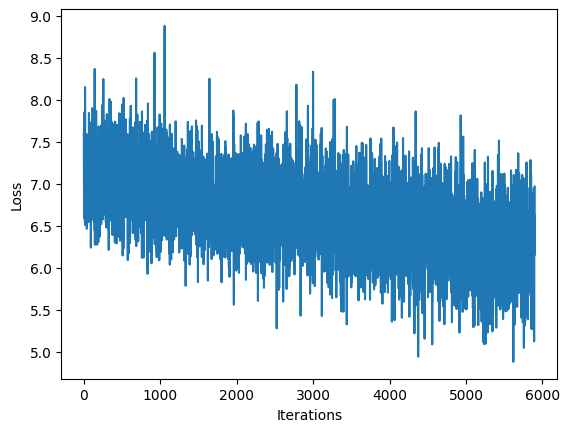

100%|██████████| 310/310 [00:12<00:00, 25.15it/s, valid_loss=6.06]


Saved Best Model!
Epoch: 3


  1%|          | 61/5900 [00:05<08:29, 11.46it/s, lr=1.75e-5, train_loss=6.24]


Interrupted by user
Checkpoint saved at epoch 3 due to interruption


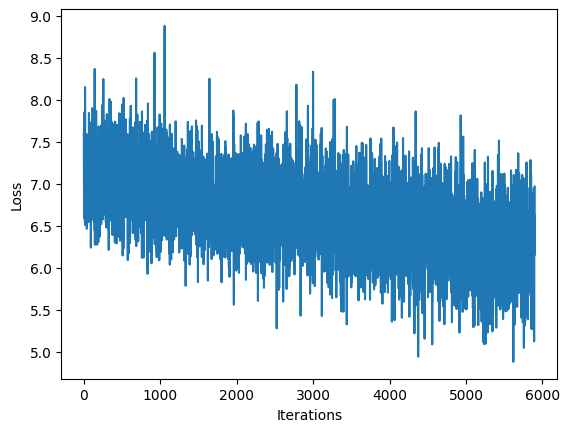

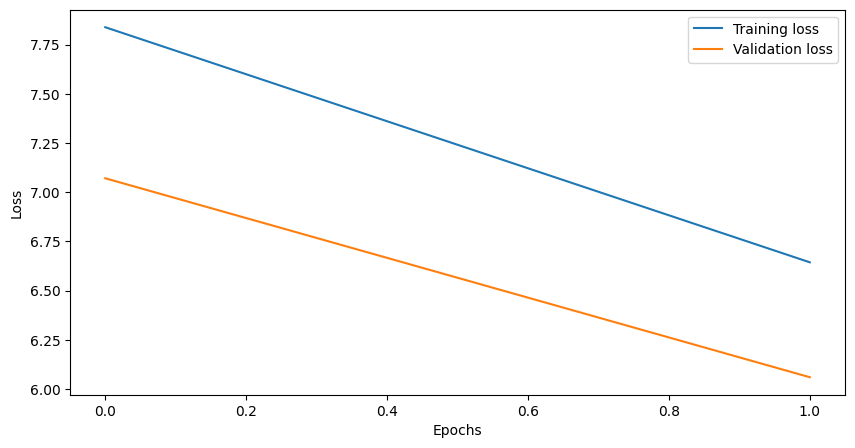

In [112]:
if __name__ == "__main__":
    main()

In [27]:
def evaluate(dataset,model,tokenizer,image_path=None,save_path=None):
#     model.load_state_dict(torch.load("model"),map_location = CFG.device)
    model.eval()
    loop = tqdm(dataset , total = len(test_data))
    
    for idx, (tokens, mask, prefix,caption) in enumerate(loop):
#         print(caption)

#         try:
        with torch.no_grad():
            # img_path_full = os.path.join(image_path, img_name)
            # image = cv2.imread(img_path_full)
            
#             image_emb = torch.tensor(image).to(CFG.device)
#             image_emb = image_emb.unsqueeze(0)
#                 print("hello")
            # img_embed = torch.tensor(img_emb).float().to(CFG.device)
            img_embed = prefix.float().to(CFG.device)
            # print(img_embed.shape)
            img_embed = img_embed.unsqueeze(0)
            tokens = model.evaluate(img_emb=img_embed,temperature=1)
#             tokens = model.evaluate(image=image_emb,second=True)
#             print(tokens)
            captions = tokenizer.batch_decode(
            tokens, skip_special_tokens=True)
            print("captions:      ",captions)
#                 cap_list.append(decoded + "\n")
            # plt.imshow(image)
            # plt.title(captions)
            # plt.axis("off")
            # plt.savefig(os.path.join(save_path, img_name), bbox_inches="tight")
            # plt.clf()
            # plt.close()
#         except IndexError :
#             pass   
#         except KeyboardInterrupt:
#             print("Intreupptrd by user")
#             break
        
        
if __name__ == "__main__":
    tokenizer =  tokenizer = GPT2Tokenizer.from_pretrained("/kaggle/input/gpt-finetuned-final-ver")
    tokenizer.bos_token = tokenizer.eos_token
    # tokenizer.pad_token = "0"
    # tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
    validdata = test_data
    model =ClipModel(ep_len=10, projection_dim=CFG.projection_dim).to(device ='cuda')
#     model = torch.nn.DataParallel(model, device_ids=[0, 1])  # Use GPU 0 and 1
#     model = model.to('cuda')
    model_path = "/kaggle/working/best.pt"
#     model.load_state_dict(torch.load(model_path, map_location=CFG.device, weights_only=True))
    checkpoint = torch.load(model_path, map_location=CFG.device)
    
    # Load the model state dictionary
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    
    dataset = validdata
    img_path = "/kaggle/input/coco-image-caption/train2014/train2014"
    save_path = '/kaggle/working/main_folder_13'
    evaluate(dataset,model,tokenizer,img_path,save_path)
                
    

/tmp/ipykernel_30/1919088293.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=CFG.device)
  0%|          | 0/3106 [00:00

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  0%|          | 0/3106 [00:00<?, ?it/s]


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [123]:
import torch
import cv2
import os
from tqdm import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu

def evaluate(dataset, model, tokenizer, image_path=None, save_path=None):
    model.eval()
    loop = tqdm(dataset, total=len(dataset))
    
    # Lists to store BLEU scores for averaging later
    bleu1_scores = []
    bleu2_scores = []
    bleu3_scores = []
    bleu4_scores = []
    
    for idx, (tokens, mask, prefix, caption) in enumerate(loop):
        with torch.no_grad():
            img_embed = prefix.float().to(CFG.device)
            img_embed = img_embed.unsqueeze(0)

            predicted_tokens = model.evaluate(img_emb=img_embed, temperature=1)
            predicted_captions = tokenizer.batch_decode(predicted_tokens, skip_special_tokens=True)
            predicted_caption = predicted_captions[0] if len(predicted_captions) > 0 else ""

            # Tokenize reference and predicted
            reference_tokens = caption.strip().split()
            predicted_tokens = predicted_caption.strip().split()
            references = [reference_tokens]

            # Calculate BLEU scores for n=1 to 4
            bleu1 = sentence_bleu(references, predicted_tokens, weights=(1.0, 0, 0, 0))
            bleu2 = sentence_bleu(references, predicted_tokens, weights=(0.5, 0.5, 0, 0))
            bleu3 = sentence_bleu(references, predicted_tokens, weights=(1/3, 1/3, 1/3, 0))
            bleu4 = sentence_bleu(references, predicted_tokens, weights=(0.25, 0.25, 0.25, 0.25))

            bleu1_scores.append(bleu1)
            bleu2_scores.append(bleu2)
            bleu3_scores.append(bleu3)
            bleu4_scores.append(bleu4)

            print(f"Predicted: {predicted_caption}")
            print(f"Reference: {caption}")
            print(f"BLEU-1: {bleu1:.4f}, BLEU-2: {bleu2:.4f}, BLEU-3: {bleu3:.4f}, BLEU-4: {bleu4:.4f}")

    # Compute average BLEU scores over the entire dataset
    avg_bleu1 = sum(bleu1_scores) / len(bleu1_scores) if bleu1_scores else 0.0
    avg_bleu2 = sum(bleu2_scores) / len(bleu2_scores) if bleu2_scores else 0.0
    avg_bleu3 = sum(bleu3_scores) / len(bleu3_scores) if bleu3_scores else 0.0
    avg_bleu4 = sum(bleu4_scores) / len(bleu4_scores) if bleu4_scores else 0.0

    print("----- AVERAGE BLEU SCORES -----")
    print(f"Average BLEU-1: {avg_bleu1:.4f}")
    print(f"Average BLEU-2: {avg_bleu2:.4f}")
    print(f"Average BLEU-3: {avg_bleu3:.4f}")
    print(f"Average BLEU-4: {avg_bleu4:.4f}")


if __name__ == "__main__":
    tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")
    tokenizer.bos_token = tokenizer.eos_token
    tokenizer.pad_token = "0"
    
    validdata = test_data
    model = ClipModel(ep_len=10, projection_dim=CFG.projection_dim).to(device='cuda')
    model_path = "/kaggle/working/best.pt"
    checkpoint = torch.load(model_path, map_location=CFG.device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    dataset = validdata
    img_path = "/kaggle/input/coco-image-caption/train2014/train2014"
    save_path = '/kaggle/working/main_folder_13'
    evaluate(dataset, model, tokenizer, img_path, save_path)


/tmp/ipykernel_30/2702903032.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=CFG.device)
  0%|          | 1/3106 [00:00

Predicted:  roam sleepsful figurcott areful cloudsful areils ascending trollalls spitting signsfulrepair poleils sleeps hands sign swamp ramp
Reference: cat want play wii game
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  0%|          | 2/3106 [00:00<19:45,  2.62it/s]

Predicted:  sleepsful troll roam cloudsful ascending trollils swamp pole clouds trollilsful pole areful is ascendingallsilsfulful bridge
Reference: group people sitting black couch next laptop
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  0%|          | 3/3106 [00:01<19:25,  2.66it/s]

Predicted: ful beginrepairfulfulfulfulful sleeps walk swamp is sleepsilsaign outdoorils sleeps are are poster are is troll swamp
Reference: dalmatian dog driving bus street
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  0%|          | 4/3106 [00:01<19:08,  2.70it/s]

Predicted:  cloudsaign areils pole wateraign walking sleeps are two is is ale hands swamp sign figur words walking troll begin ascending outdoor sleeps
Reference: airplane seat built television
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  0%|          | 5/3106 [00:01<19:16,  2.68it/s]

Predicted:  figur is ol swampslow sleeps words sleeps hands sleeps swamp is outdoorrepair sleeps figurful pole are denotes roam roam sleeps swamp sleeps
Reference: multiple goats sit next small space
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  0%|          | 6/3106 [00:02<18:58,  2.72it/s]

Predicted:  sleeps sleeps hands sleeps ascending pole spittingils sign pole are clouds cloudsful swampfulful signs sleeps are are sleeps sign areful
Reference: small dog leaning forward front cake eating
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  0%|          | 7/3106 [00:02<19:45,  2.61it/s]

Predicted:  swamp clouds swamp the poleils are hands outdoorcottils sleeps pen cloudsful words is sleeps pt pole are areful sleepscott
Reference: cat sits top sleeping dog
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  0%|          | 8/3106 [00:03<19:44,  2.62it/s]

Predicted: ils poleful is the are graffiti are ascendingaignful sleeps sleeps signs troll poleils thefulcott swamp roamesp areful
Reference: bullet bike style motorcycle parked street
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  0%|          | 9/3106 [00:03<19:43,  2.62it/s]

Predicted: ful are sleeps troll sleepsful pole roamfulils therepair pen is polerepairrepair clouds city drain areils ascending devices figur
Reference: bear walking across street woods
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  0%|          | 10/3106 [00:03<19:29,  2.65it/s]

Predicted:  trollcott swamp penful men pole sleeps pole figur pole figur spitting ascending sleepsilsesp theful sleeps sleeps sleeps ramp wordsful
Reference: two persons beach playing baseball next house grassy hill
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  0%|          | 11/3106 [00:04<19:39,  2.62it/s]

Predicted:  drain is signs areilsils trollful figur are roamils swamp ascending swamp figur the handsils words areilsils clouds are
Reference: woman holding nintendo wii game controller
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  0%|          | 12/3106 [00:04<19:37,  2.63it/s]

Predicted:  indoor drain sleeps hands are are pole sleeps swamp the are are indoorful sleepsespfulilsilsesp wordscott signs ramp sleeps
Reference: young boy standing top sandy beach
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  0%|          | 13/3106 [00:04<19:21,  2.66it/s]

Predicted:  swamp cloudsful people areilscott signs are swampful sink sleeps mask indoor swamp pole are figur are is bridge swamp roam roam
Reference: bicycle parked next fence
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
  0%|          | 14/3106 [00:05<19:31,  2.64it/s]

Predicted:  walking cityils is outdoor clouds isful penful are city are therepair are areful are ascending poleful sleepsrepair hands
Reference: view city street lined trees buildings sun goes
BLEU-1: 0.0556, BLEU-2: 0.2357, BLEU-3: 0.3816, BLEU-4: 0.4855


  0%|          | 15/3106 [00:05<19:39,  2.62it/s]

Predicted: ers clouds pole the sleeps prepares sleeps is figur words pole spitting pole polecottfulrepairfulful swamp pole the sleeps sleeps words
Reference: lady holding surfboard hip
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 16/3106 [00:06<19:32,  2.64it/s]

Predicted: ilsful sign drainrepair sleeps troll maskfulaign roam figur pole beginful pole sleeps poleaignesp troll sleeps is swampful
Reference: cat curled ceramic bowl kitchen table
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 17/3106 [00:06<19:14,  2.68it/s]

Predicted:  signfulils figur swampful words sleeps begin swampful people poleful ipalls are sinkful city begin signs pole sleeps devices
Reference: multi colored motorcycle display
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 18/3106 [00:06<19:17,  2.67it/s]

Predicted:  signs appearscott ascending pole are beginils rampful clouds sleepsful troll are sleeps figur walking ascending sleepsfulils pole mask troll
Reference: picture bridge water
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 19/3106 [00:07<19:05,  2.70it/s]

Predicted:  clouds bridge or ip sleepsils figurful the theful polealls city troll city are sleepsfulilsfulful handshap figur
Reference: bathroom white walls tub brown cabinet floor
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 20/3106 [00:07<18:59,  2.71it/s]

Predicted:  pole sleeps figur sleepsils poleils sleepsils sleeps sleeps ascendingful sleeps ol sign swampaignesp clouds sinkesprepair signs swamp
Reference: cubbies towels blue bathroom
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 21/3106 [00:07<19:11,  2.68it/s]

Predicted:  are signrepairful sleeps words roamcotters is sleeps sleeps pole sleeps are sleeps pen walkful arerepairespful pen signs
Reference: three kids man dog picnic bench
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 22/3106 [00:08<18:57,  2.71it/s]

Predicted:  roam sleeps ramp figurespils men devices figuraignils trollful city sleepsfulalls pole sleepsfuliments signilsful begin
Reference: large black bear standing top pile wood
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 23/3106 [00:08<18:56,  2.71it/s]

Predicted:  ramp are pen outdoor drain mask walking sleeps theaign sleeps pole sleepsespful is sleeps figurils ascendingilsils troll is signs
Reference: girl holding baseball bat getting ready swing
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 24/3106 [00:09<19:06,  2.69it/s]

Predicted:  sleeps sleepsesp figurful sleeps signs walk begin troll pole walking pole devices ramp ascending sleepsfulaign is sleepsfuledful the
Reference: baseball pitcher baseball field pitching position ball one hand baseball catching mitt hand
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 25/3106 [00:09<18:59,  2.70it/s]

Predicted:  sleeps swampils swamp sleeps areils are signful swamp isaign figur is arecott areful figur is swamp are spitting bridge
Reference: person walking park next tree
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 26/3106 [00:09<19:13,  2.67it/s]

Predicted: esp sleeps roam ascending are peopleils hands sleepsilsful roam pole swamp is theful bridgeespful roam trollfulful is
Reference: man dress holds teddy bear dress
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 27/3106 [00:10<19:05,  2.69it/s]

Predicted:  poleers peopleful hands sleepsfulfulful sleeps begin sleeps people drain sleeps sleeps sleeps begin sleeps clouds troll cloudsfulful words
Reference: man surf board riding wave
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 28/3106 [00:10<19:14,  2.67it/s]

Predicted: ils swampils swamp wordsfulfulful sleepsful is signs walk ascending sleeps sleeps pen troll devicesesp ip sleepsful engines hands
Reference: 2 young girls playing small goat
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 29/3106 [00:10<19:25,  2.64it/s]

Predicted: cottespunited are cityunited sleeps are sleeps sleepserscott are city signsunitedils spitting sleeps figur swamp sleepsersers ascending
Reference: three young people playing frisbee soccer field
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 30/3106 [00:11<19:17,  2.66it/s]

Predicted: ilsfulful drainiments theaigncott sleeps swamp both is ascending isful sleeps sleepsilsful ipils clouds clouds indoor spitting
Reference: decorative circular clock green wooden tower
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 31/3106 [00:11<19:10,  2.67it/s]

Predicted:  sleeps ip walking swamp trollful sleeps swamp sleepsunited roam denotes sleepsful sleepsils roam roam words troll sleepsilsils poleaign
Reference: man woman looking appears hotel toom others bed
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 32/3106 [00:12<19:06,  2.68it/s]

Predicted:  ascendingesp outdoor sleeps signsilsils trollcottful sleeps ascendingaign ip sleeps ol poleilsaign bridge figur troll sleeps ale swamp
Reference: woman scarf wrapped around holding plate chocolate cake
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 33/3106 [00:12<19:00,  2.69it/s]

Predicted:  sleepsful sign indoor preparesful both sleeps sleepsilsils isful pole swamp sign are is roam sleeps are swampfulilsils
Reference: bunch two leveled red buses city street
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 34/3106 [00:12<19:44,  2.59it/s]

Predicted:  beginaign theils are drain roam ramp walking walking isers pen rampful areful sleepsespful sleeps troll mask figur hands
Reference: two black cooling rack shoaling pieces pizza
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 35/3106 [00:13<19:36,  2.61it/s]

Predicted:  troll denotesils hands isalls are begin signs swampful are sleeps cloudsfulful isilsaign signs words troll poleersils
Reference: large plane sitting top field
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 36/3106 [00:13<19:28,  2.63it/s]

Predicted:  drainesp beginesp are isful thecott aresalls city words walking figurful figuraignful water sleepsfulful pole
Reference: green plant growing area dirt
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 37/3106 [00:13<19:34,  2.61it/s]

Predicted: ful pole are is troll twocott handscottfulfulimentsful figur sleepsful are sleepsful troll is is signs begin pole
Reference: three dimensional rendering kitchen area various appliances
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|          | 38/3106 [00:14<19:21,  2.64it/s]

Predicted:  bridge ascending pole figur devicesers roam city wordsfulhap sleepsful mask figur are hands handsers sleeps are swamp ale signsful
Reference: bear walks around rocky terrain next caves
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|▏         | 39/3106 [00:14<19:27,  2.63it/s]

Predicted: ils trollunited men sleeps sleeps are denotes sleeps bridge people bridgeaignesp words the signsful sleepsrepair hands are drain signsful
Reference: group men sitting around table covered boxes junk
BLEU-1: 0.0526, BLEU-2: 0.2294, BLEU-3: 0.3748, BLEU-4: 0.4790


  1%|▏         | 40/3106 [00:15<19:12,  2.66it/s]

Predicted: ful signsaign swamp ramp devicesils bothcott sleepsrepair swamp ale troll indoorils ascendingaign sleeps swampalls are sleepsful swamp
Reference: outdoor patio chairs potted plants
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|▏         | 41/3106 [00:15<19:14,  2.65it/s]

Predicted: fulils cloudsful pole clouds swamp beginaignful ale sleeps trollilsespfulful are ipunited swamp ascendingful outdoorful
Reference: zebra along animals hanging outside
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|▏         | 42/3106 [00:15<20:32,  2.49it/s]

Predicted:  areilsfulrepairfulilsilsful figur sleeps hands words pole the sign areful maskesp outdoor city drain cityrepair swamp
Reference: man standing next red motorcycle back yard
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|▏         | 43/3106 [00:16<20:23,  2.50it/s]

Predicted:  pole signsful sleeps cloudsful signils isilsful is sleeps polecott city people isful trollilsers ale poleesp
Reference: woman white rose blue umbrella grassy background
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|▏         | 44/3106 [00:16<20:01,  2.55it/s]

Predicted:  ascending pole sleeps figur sleeps sleeps sleeps swamp wordsesp the sleeps ramp swampunitedcottaign bridge are is outdoorils drain poleils
Reference: man standing near fruit stand carrying bunches bananas
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|▏         | 45/3106 [00:17<19:45,  2.58it/s]

Predicted: fulils roam swamp poleful cell sleeps the begin areils theful is sleeps figur are indoorils roam sleeps poleils ale
Reference: yellow pedestrian sign post
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  1%|▏         | 46/3106 [00:17<19:25,  2.63it/s]

Predicted:  sleeps ramp handsils sleepsils sign spitting walkingils sleeps city sleeps handscott sleeps hands sleepsaign sleeps sign signs the spitting devices
Reference: two street signs white truck turing lane man walking sidewalk
BLEU-1: 0.0500, BLEU-2: 0.2236, BLEU-3: 0.3684, BLEU-4: 0.4729


  2%|▏         | 47/3106 [00:17<19:41,  2.59it/s]

Predicted:  ascending are sleeps cloudsils sleeps wordsers is the drain prepares ascending sleeps pole swamp bridge indoorils figur people peners are hands
Reference: bright red panel truck parked woman standing beside
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  2%|▏         | 48/3106 [00:18<19:31,  2.61it/s]

Predicted:  poleils sleeps ascending hands are words sleeps figurful begin figur is ascending ascending pole sleeps alerepairaign is sleepsful ramp roam
Reference: little girl getting large jug refrigerator
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  2%|▏         | 49/3106 [00:18<19:19,  2.64it/s]

Predicted:  sleepscott swampaign troll sleeps troll signsils sleeps sign are ale arefulespils sleepsesp areaigners sleeps roam sleeps
Reference: bird perched cleaning wing
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  2%|▏         | 50/3106 [00:18<19:05,  2.67it/s]

Predicted:  ale swampils swamp sleepsful sleeps begin sleeps devices are sleeps is are the sign sleepsaignils ol walkils sleepsful sign
Reference: card board box full cortland apples
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  2%|▏         | 51/3106 [00:19<19:04,  2.67it/s]

Predicted:  sleepsils both troll poleful theilsaign theilsils pole ascendingful bridgeaign sleeps peoplefulful are begin are words
Reference: man standing next another man working motorcycle
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


  2%|▏         | 52/3106 [00:19<19:24,  2.62it/s]

Predicted:  clouds sleeps bridge ascendingful the cellful isfulful pole swampful sleeps pole words sleeps are are city words poleful sleeps
Reference: two black white lambs hay area next wooden panel
BLEU-1: 0.0000, BLEU-2: 0.0000, BLEU-3: 0.0000, BLEU-4: 0.0000


KeyboardInterrupt: 

In [67]:
def overlay_attention_on_image(image_bgr, attn_map, alpha=0.5):
    """
    Overlays a 2D attention map on top of an original BGR image using OpenCV.

    Args:
        image_bgr (np.ndarray): Original image in BGR format with shape (H, W, 3).
        attn_map (np.ndarray): Attention map with shape (h, w). Will be resized to (H, W).
        alpha (float): Blending factor. 0 = only original image, 1 = only heatmap.
    
    Returns:
        overlayed (np.ndarray): The resulting image with heatmap overlay in BGR format.
    """
    # 1) Resize attention map to the same size as the image
    H, W, _ = image_bgr.shape
    attn_resized = cv2.resize(attn_map, (W, H), interpolation=cv2.INTER_LINEAR)

    # 2) Normalize attention map to [0, 1]
    attn_norm = attn_resized - attn_resized.min()
    denom = (attn_resized.max() - attn_resized.min()) + 1e-8
    attn_norm = attn_norm / denom  # shape (H, W) in [0, 1]

    # 3) Convert to 8-bit and apply a color map
    attn_255 = (attn_norm * 255).astype(np.uint8)      # (H, W)
    heatmap  = cv2.applyColorMap(attn_255, cv2.COLORMAP_JET)  # (H, W, 3) in BGR

    # 4) Alpha blend heatmap with original image
    overlayed = cv2.addWeighted(image_bgr, 1 - alpha, heatmap, alpha, 0)

    return overlayed

def evaluate(dataset,model,tokenizer,image_path=None,save_path=None):
#     model.load_state_dict(torch.load("model"),map_location = CFG.device)
    model.eval()
    loop = tqdm(dataset , total = len(test_data))
    
    for idx, (tokens, mask, prefix,caption,img_name) in enumerate(loop):
#         print(caption)

#         try:
        with torch.no_grad():
            img_path_full = os.path.join(image_path, img_name)
            image = cv2.imread(img_path_full)
            
#             image_emb = torch.tensor(image).to(CFG.device)
#             image_emb = image_emb.unsqueeze(0)
#                 print("hello")
            # img_embed = torch.tensor(img_emb).float().to(CFG.device)
            img_embed = prefix.float().to(CFG.device)
            # print(img_embed.shape)
            img_embed = img_embed.unsqueeze(0)
            tokens, attn_store = model.evaluate(img_emb=img_embed, temperature=1)
            image_proj_tg_wt     = attn_store["image_proj_tg_wt"]       # shape [1, 10, 10]
            image_proj_xgl_tg_wt = attn_store["image_proj_xgl_tg_wt"]   # shape [1, 10]
            image_proj_ig_wt     = attn_store["image_proj_ig_wt"]       # shape [1, 10, 10]
            image_proj_xgl_ig_wt = attn_store["image_proj_xgl_ig_wt"]   # shape [1, 10]

# 1) Visualize the 2D matrix (10x10)
            matrix_tg = image_proj_tg_wt[0].cpu().numpy()
            matrix_tg = matrix_tg.squeeze(0)
            # plt.figure()
            # plt.imshow(matrix_tg, cmap='Blues', aspect='auto')
            # plt.colorbar()
            # plt.title("image_proj_tg_wt - 10x10")
            # plt.show()

# 2) Visualize the 1D vector (10)
            vector_tg_xgl = image_proj_xgl_tg_wt[0].cpu().numpy()
            vector_tg_xgl = vector_tg_xgl.squeeze(0)
            # plt.figure()
            # plt.bar(range(len(vector_tg_xgl)), vector_tg_xgl)
            # plt.title("image_proj_xgl_tg_wt - 10")
            # plt.show()
# 
#             tokens = model.evaluate(image=image_emb,second=True)
#             print(tokens)
            captions = tokenizer.batch_decode(
            tokens, skip_special_tokens=True)
            print("captions:      ",captions)
#                 cap_list.append(decoded + "\n")
            # plt.imshow(image)
            # plt.title(captions)
            # plt.axis("off")
            # plt.savefig(os.path.join(save_path, img_name), bbox_inches="tight")
            # plt.clf()
            # plt.close()
#         except IndexError :
#             pass   
#         except KeyboardInterrupt:
#             print("Intreupptrd by user")
#             break
        
        
if __name__ == "__main__":
    tokenizer =  tokenizer = GPT2Tokenizer.from_pretrained("/kaggle/input/gpt-finetuned-final-ver")
    tokenizer.bos_token = tokenizer.eos_token
    # tokenizer.pad_token = "0"
    # tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
    validdata = test_data
    model =ClipModel(ep_len=10, projection_dim=CFG.projection_dim).to(device ='cuda')
#     model = torch.nn.DataParallel(model, device_ids=[0, 1])  # Use GPU 0 and 1
#     model = model.to('cuda')
    model_path = "/kaggle/working/best.pt"
#     model.load_state_dict(torch.load(model_path, map_location=CFG.device, weights_only=True))
    checkpoint = torch.load(model_path, map_location=CFG.device)
    
    # Load the model state dictionary
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    
    dataset = validdata
    img_path = "/kaggle/input/coco-image-caption/train2014/train2014"
    save_path = '/kaggle/working/main_folder_13'
    evaluate(dataset,model,tokenizer,img_path,save_path)
                
    

/tmp/ipykernel_30/1603455928.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=CFG.device)
  0%|          | 0/3106 [00:00

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  0%|          | 1/3106 [00:00<19:23,  2.67it/s]

captions:       ['thin iv city iv olthinthin plazaflix ol ol ol whole city ol nmess olpacked veryiss fresh plaza are very']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


[ WARN:0@14005.416] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/coco-image-caption/train2014/train2014/580718'): can't open/read file: check file path/integrity
  0%|          | 2/3106 [00:00<18:54,  2.74it/s]

captions:       [' whole\ninalspacked ol ol cross plaza plaza plaza ol ol olcond very wholethin ol cityid benchthinhill whole ol']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


[ WARN:0@14005.775] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/coco-image-caption/train2014/train2014/142259'): can't open/read file: check file path/integrity
  0%|          | 3/3106 [00:01<18:53,  2.74it/s]

captions:       [' fresh olthininolog ol smiling ol fresh ol ol closed fresh ol dear ol whole olcube ol olinals bench ol wrapper']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


[ WARN:0@14006.140] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/coco-image-caption/train2014/train2014/213570'): can't open/read file: check file path/integrity
  0%|          | 4/3106 [00:01<19:31,  2.65it/s]

captions:       [' decre ol benches ol sne benchcond ol bench plazapacked sne ol ol olflix fresh citythin benches whole ol n whole city']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


[ WARN:0@14006.537] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/coco-image-caption/train2014/train2014/106902'): can't open/read file: check file path/integrity
  0%|          | 5/3106 [00:01<19:34,  2.64it/s]

captions:       [' ol and standing olpackedcond poles plaza wholecond wholehillhillin small city olthin bench whole sk plazaissflixolog']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


[ WARN:0@14006.917] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/coco-image-caption/train2014/train2014/350421'): can't open/read file: check file path/integrity
  0%|          | 6/3106 [00:02<19:25,  2.66it/s]

captions:       [' ivflix ob iv smallhillhill passing benchthin olthin city n sad freshcond cross ol plaza ol olhill whole smiling']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


[ WARN:0@14007.287] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/coco-image-caption/train2014/train2014/573724'): can't open/read file: check file path/integrity
  0%|          | 7/3106 [00:02<19:08,  2.70it/s]

captions:       [' plaza sad cityhill olpacked bench ol very crosshill wholepacked olhill\ninals closed ol olhill sk freshhill whole']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


[ WARN:0@14007.647] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/coco-image-caption/train2014/train2014/295670'): can't open/read file: check file path/integrity
  0%|          | 8/3106 [00:02<18:58,  2.72it/s]

captions:       [' ol ol freshmesshill whole olthin city olileida fresh cross fresh sne whole freshthin olthin ol ol ol whole']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


[ WARN:0@14008.009] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/coco-image-caption/train2014/train2014/69977'): can't open/read file: check file path/integrity
  0%|          | 9/3106 [00:03<18:55,  2.73it/s]

captions:       ['incond whole fresh bench benchpacked bench and olpackedcondhill city ol ol bench sad citythinthin plaza boarding plaza plaza']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


[ WARN:0@14008.373] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/coco-image-caption/train2014/train2014/269303'): can't open/read file: check file path/integrity
  0%|          | 10/3106 [00:03<19:21,  2.66it/s]

captions:       [' poles n crossthin fresh ol whole whole fresh fall sad whole ol sadpackedin small benchthin wrapper ol ol freshthin very']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


KeyboardInterrupt: 

In [112]:
import os
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def evaluate(dataset, model, tokenizer, image_path=None, save_path=None):
    model.eval()
    loop = tqdm(dataset, total=len(dataset))

    # Create subfolders for TG and IG weights
    os.makedirs(os.path.join(save_path, "tg"), exist_ok=True)
    os.makedirs(os.path.join(save_path, "ig"), exist_ok=True)

    for idx, (tokens, mask, prefix, caption) in enumerate(loop):

        with torch.no_grad():
            # Move image prefix embedding to GPU if needed
            img_embed = prefix.float().to(CFG.device)
            img_embed = img_embed.unsqueeze(0)

            # Evaluate the model; returns generated tokens + attn_store
            tokens, attn_store = model.evaluate(img_emb=img_embed, temperature=1)

            # -----------
            # GET WEIGHTS
            # -----------
            # Each shape = [1, 10, 10] for batch_size=1
            image_proj_tg_wt = attn_store["image_proj_tg_wt"]
            image_proj_ig_wt = attn_store["image_proj_ig_wt"]

            # -----------------------------------------------------------------
            # VISUALIZE TG PROJECTION WEIGHTS (10x10) AND SAVE TO tg/ FOLDER
            # -----------------------------------------------------------------
            matrix_tg = image_proj_tg_wt[0].cpu().numpy()  # shape (1, 10, 10)
            matrix_tg = matrix_tg.squeeze(0)               # shape (10, 10)

            plt.figure()
            plt.imshow(matrix_tg, cmap='Blues', aspect='auto')
            plt.colorbar()
            plt.title(f"image_proj_tg_wt - 10x10 (sample {idx})")

            save_file_tg = os.path.join(save_path, "tg", f"{idx}_image_proj_tg_wt.png")
            plt.savefig(save_file_tg, bbox_inches="tight")
            plt.close()

            # -----------------------------------------------------------------
            # VISUALIZE IG PROJECTION WEIGHTS (10x10) AND SAVE TO ig/ FOLDER
            # -----------------------------------------------------------------
            matrix_ig = image_proj_ig_wt[0].cpu().numpy()  # shape (1, 10, 10)
            matrix_ig = matrix_ig.squeeze(0)               # shape (10, 10)

            plt.figure()
            plt.imshow(matrix_ig, cmap='Reds', aspect='auto')
            plt.colorbar()
            plt.title(f"image_proj_ig_wt - 10x10 (sample {idx})")

            save_file_ig = os.path.join(save_path, "ig", f"{idx}_image_proj_ig_wt.png")
            plt.savefig(save_file_ig, bbox_inches="tight")
            plt.close()

            # -----------------------------------------------------------------
            # DECODE TOKENS -> CAPTIONS
            # -----------------------------------------------------------------
            captions = tokenizer.batch_decode(tokens, skip_special_tokens=True)
            print("captions:", captions)

    # End of evaluate function

if __name__ == "__main__":
    tokenizer = GPT2Tokenizer.from_pretrained("/kaggle/input/gpt-finetuned-final-ver")
    tokenizer.bos_token = tokenizer.eos_token
    validdata = test_data

    model = ClipModel(ep_len=10, projection_dim=CFG.projection_dim).to('cuda')
    checkpoint = torch.load("/kaggle/working/best.pt", map_location=CFG.device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Evaluate on your dataset
    img_path = "/kaggle/input/coco-image-caption/train2014/train2014"
    save_path = "/kaggle/working/main_folder_13"
    evaluate(validdata, model, tokenizer, img_path, save_path)


/tmp/ipykernel_30/911162660.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/best.pt", map_location=CFG.device)
  0%|          |

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  1%|          | 1/156 [00:00<02:30,  1.03it/s]

captions: ['\n tooth writing cutting, pull cell walking sl water drinking tooth hot soda cutting soda house white soda\n the\n soda water the']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  1%|▏         | 2/156 [00:01<02:32,  1.01it/s]

captions: [' and\n alike street tow n tow water pulling soda san smoke water water soda smoke in soda water photo water tooth smoke soda surf']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  2%|▏         | 3/156 [00:03<03:36,  1.42s/it]

captions: [' water soda tooth k\n ring in hot cutting cook\n water writing soda men ring soda air water water talk cutting bow water the']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  3%|▎         | 4/156 [00:04<03:09,  1.25s/it]

captions: [' and it and ring soda soda cutting writing tooth soda drinking smoke soda smoke drinking cow bow surf cutting water female air soda both tooth']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  3%|▎         | 5/156 [00:05<02:54,  1.15s/it]

captions: [' water photo water soda cook cutting hot cat cutting soda in smoke water smoke water cutting soda soda water drinking cat smoke water smoke water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  4%|▍         | 6/156 [00:06<02:45,  1.10s/it]

captions: [' tow cooking tooth sl drinking smoke soda tooth soda drinking water some cook\n smoke and water soda tow water whine water station water tooth']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  4%|▍         | 7/156 [00:07<02:30,  1.01s/it]

captions: [' tow water smoke and smoke tooth soda\n water soda soda smoke soda water cutting soda\n tooth tooth drinking skirt smoke smoke tooth skirt']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  5%|▌         | 8/156 [00:08<02:21,  1.05it/s]

captions: ['\n cell cross water ring drinking cutting cutting cutting soda\n tooth tooth soda the cooking cutting smoke water soda tooth smoke writing drinking the']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  6%|▌         | 9/156 [00:09<02:15,  1.09it/s]

captions: [' san the the both smoke drinking cooking soft n soda it air water soda drinking white tooth n cutting street smoke cat tooth smoke cutting']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  6%|▋         | 10/156 [00:10<02:10,  1.12it/s]

captions: [' and house cutting smoke drinking soda cutting san tooth drinking soda soda soda alike soda smoke the pull tooth soda whine water hot surf hot']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  7%|▋         | 11/156 [00:11<02:07,  1.14it/s]

captions: [' that smoke water surf - soda cooking cooking the soda tooth soda tooth water and\n soda water fr stop and smoke soda soda soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  8%|▊         | 12/156 [00:11<02:04,  1.15it/s]

captions: [' it writing san n the cat photo n\n ring water soda cell men cross park surf cell the soda water soda cat tooth bow']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  8%|▊         | 13/156 [00:12<02:03,  1.16it/s]

captions: [' air pull water cutting writing and smoke water san soda soda tooth water water tooth soda tow soda smoke water soda cutting drinking water girl']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  9%|▉         | 14/156 [00:13<02:01,  1.17it/s]

captions: [', white cutting soda and and smoke the\n cutting drinking cutting in tooth cutting white cutting and hot soda air skirt soda alike tooth']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 10%|▉         | 15/156 [00:14<01:59,  1.18it/s]

captions: ['\n look and san and cooking writing cooking cross\n men soda soda photo soda the cutting walking smoke soda soda soda water men soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 10%|█         | 16/156 [00:15<02:04,  1.12it/s]

captions: [' house cat ring house both smoke tow making the soda photo smoke drinking k photo alike water alike street soda house soda soda the soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 11%|█         | 17/156 [00:16<02:07,  1.09it/s]

captions: ['\n smoke making water water soda cell white ring soda soda skirt the skirt water smoke and tooth soda soda cutting tooth soda smaller station']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 12%|█▏        | 18/156 [00:17<02:11,  1.05it/s]

captions: [' making water in water water\n in smoke and soda soda smoke cat soda smoke soda jumping tow skirt cutting soda soda soda cab soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 12%|█▏        | 19/156 [00:18<02:12,  1.03it/s]

captions: [' crack\n that cutting walking smoke san soda\n making smoke cutting smaller drinking ring soda water tooth writing crowd smoke air soda cow the']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 13%|█▎        | 20/156 [00:19<02:06,  1.07it/s]

captions: ['\n tow writing smoke pulling smoke soda in water soda the tow tooth smoke soda soda water writing the soda writing soda drinking writing cross']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 13%|█▎        | 21/156 [00:20<02:01,  1.11it/s]

captions: [' the pull tooth soda\n and and soda drink smoke smoke the tooth soda pull water skirt soda cutting soda soda soda soda tooth tooth']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 14%|█▍        | 22/156 [00:20<01:59,  1.13it/s]

captions: [' air the soda cat soda, air\n skirt tow skirt bow soda tooth water soda water water street bus the cutting soda smoke water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 15%|█▍        | 23/156 [00:21<01:57,  1.13it/s]

captions: [' in cutting smoke\n crowd water tooth the\n fr water and white water soda alike cutting soda making soda tooth soda photo k house']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 15%|█▌        | 24/156 [00:22<01:55,  1.14it/s]

captions: [' cutting ring soda water ring tooth male making writing soda smoke street and soda cell writing street soda tooth walk tooth smoke the air men']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 16%|█▌        | 25/156 [00:23<01:52,  1.16it/s]

captions: [' water cat cross in d soda cell tow water soda soda smoke in park soda writing skirt soda soda water smoke tooth water soda cutting']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 17%|█▋        | 26/156 [00:24<01:51,  1.17it/s]

captions: [' k surf soda tooth surf hot men tooth smoke in\n walking walking mouth smoke street tooth drink cutting smoke tooth soda water pull gate']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 17%|█▋        | 27/156 [00:25<01:49,  1.18it/s]

captions: [' soda mouth crowd that smoke soda soda air\n k soda air white tooth soda station soda tooth\n soda drink water girl tooth soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 18%|█▊        | 28/156 [00:26<01:48,  1.18it/s]

captions: [' and street water cutting water and soda water soda soda writing drink smoke soda street soda alike tow hot house air ring drinking girl alike']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 19%|█▊        | 29/156 [00:26<01:48,  1.17it/s]

captions: [' look that soda the photo making soda air photo soda tooth the soda smoke pull soda and water soda water soda soda water water smoke']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 19%|█▉        | 30/156 [00:27<01:47,  1.17it/s]

captions: [' n some in ring water air cooking smoke drinking soda soda tow cutting soda in air drinking soda drinking tooth station drinking smoke the smaller']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 20%|█▉        | 31/156 [00:28<01:46,  1.18it/s]

captions: [' and t soda pull tow smoke writing and drinking cutting water making cutting writing soda soda soda smoke in cooking and tooth soda smoke water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 21%|██        | 32/156 [00:29<01:45,  1.18it/s]

captions: [' soda the -, soda cutting water crowd the writing carrying and graffiti soda smoke walking soda drink soda soda skirt smoke male cutting jumping']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 21%|██        | 33/156 [00:30<01:44,  1.18it/s]

captions: [' some and in cell the white hot tooth tooth soda water water soda male tooth soda tooth ring soda soda cutting soda soda tooth smoke']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 22%|██▏       | 34/156 [00:31<01:44,  1.17it/s]

captions: [' walking - jumping water soda cutting soda crowd tooth drinking hot water cutting water smoke soda tow ring water soda water soda street soda water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 22%|██▏       | 35/156 [00:32<01:43,  1.17it/s]

captions: [' cutting stop and water cell mouth smoke air water cutting smoke water air smoke soda cat water soda smoke soda drinking photo tooth walk and']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 23%|██▎       | 36/156 [00:32<01:42,  1.17it/s]

captions: [' cat tow photo water water water drinking cutting cooking soda drinking\n water soda cutting soda writing some cat cow mouth soda house water soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 24%|██▎       | 37/156 [00:33<01:48,  1.10it/s]

captions: [' water sl cutting, drinking water soda smoke ring soda soda street n crowd cutting cat bow fr girl cutting girl tow soda alike soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 24%|██▍       | 38/156 [00:34<01:50,  1.07it/s]

captions: [' cross look water writing water pull soda cooking male water smoke white cow soda and soda drinking smoke drinking cutting soda cutting soda water water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 25%|██▌       | 39/156 [00:35<01:47,  1.09it/s]

captions: [' water both the hot and drinking drinking cell smoke soda and soda tow soda soda water walking in\n soda soda soda smoke air tooth']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 26%|██▌       | 40/156 [00:36<01:43,  1.12it/s]

captions: [' smoke male cooking smoke water that smoke and water both smaller\n air soda soda soda fr smoke surf cutting skirt smoke soda water water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 26%|██▋       | 41/156 [00:37<01:40,  1.15it/s]

captions: [' cutting cutting\n white air the the cutting and smoke writing soda alike tooth jumping drinking cow both white cat smoke tooth water cat smoke']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 27%|██▋       | 42/156 [00:38<01:38,  1.16it/s]

captions: [' cutting writing tow cutting both smoke writing water cutting drinking soda water walking water tooth both tooth soda hot cat soda girl soda tow cook']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 28%|██▊       | 43/156 [00:39<01:36,  1.17it/s]

captions: [' look both, san soda white water\n male soda soda soda tow soda smoke water water cutting tooth soda soda drinking cook drinking cutting']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 28%|██▊       | 44/156 [00:40<02:06,  1.13s/it]

captions: [' cutting water cutting ring cutting male smoke\n water water the soda water soda soda soda tooth in soda soda house smoke whine drinking bow']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 29%|██▉       | 45/156 [00:41<01:55,  1.04s/it]

captions: [', water soda and water that ring cat\n soda male tow smoke writing tooth drinking bow water surf cutting soda cutting soda men tooth']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 29%|██▉       | 46/156 [00:42<01:47,  1.02it/s]

captions: [' cutting cutting tooth ring soda water water air cook air cutting white both soda soda air the soda stop water\n water photo cutting smaller']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 30%|███       | 47/156 [00:43<01:42,  1.06it/s]

captions: [' making look some\n soda tooth writing and some\n alike photo smoke white water water drinking drinking cutting tooth cat water soda cutting water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 31%|███       | 48/156 [00:44<01:38,  1.10it/s]

captions: [' crowd soda soda san in drinking soda tooth alike cat soda soda water tooth alike soda the white soda water water tooth water smoke bow']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 31%|███▏      | 49/156 [00:45<01:35,  1.12it/s]

captions: [' cell water drinking photo ring, soda air drinking soda skirt smoke water cutting making men tooth soda mouth tooth girl drinking the soda water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 32%|███▏      | 50/156 [00:45<01:32,  1.15it/s]

captions: [' writing the that smoke and smoke the tow water smoke soda cutting soda park cutting water alike smoke water smoke soda cutting water water water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 33%|███▎      | 51/156 [00:46<01:30,  1.15it/s]

captions: [' hot mouth walking both water soda smoke walking\n crowd sl and smoke smoke soda cooking cutting soda smoke tooth hot soda soda tooth tow']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 33%|███▎      | 52/156 [00:47<01:29,  1.16it/s]

captions: [' mouth soda and smoke cutting cook cutting\n alike drinking tooth soda bow soda tooth cow drinking soda drinking girl soda tooth girl water station']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 34%|███▍      | 53/156 [00:48<01:27,  1.18it/s]

captions: [' soda k and white cutting soda water tooth soda tooth soda white pull soda tooth tooth male white soda jumping whine k tow white cow']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 35%|███▍      | 54/156 [00:49<01:26,  1.17it/s]

captions: [' some stop tow street mouth\n making cell and cutting cutting water cat soda tooth graffiti soda soda soda tooth bus white soda tooth talk']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 35%|███▌      | 55/156 [00:50<01:25,  1.18it/s]

captions: [' pull cutting smoke skirt pull the smoke cat soda cutting smoke cook\n cat skirt drinking crowd smoke bow soda street skirt mouth soda graffiti']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 36%|███▌      | 56/156 [00:50<01:24,  1.18it/s]

captions: [' tow white or some cooking men making and tooth soda cutting tooth cutting ring drinking soda smoke water the tooth soda soda soda the house']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 37%|███▋      | 57/156 [00:51<01:24,  1.18it/s]

captions: [' drinking in smoke smoke house water soda soda soda tooth ring k tow drinking cross white hot fr soda cow soda water soda cutting air']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 37%|███▋      | 58/156 [00:52<01:22,  1.19it/s]

captions: [' water cell water bow cutting tooth tooth sl air soda soda soda the water water soda alike drinking surf soda soda water water bow smaller']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 38%|███▊      | 59/156 [00:53<01:21,  1.20it/s]

captions: [' cross water cell water writing skirt writing pull soda soda soda soda smoke soda soda bow tow pull soda mouth station soda soda soda tooth']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 38%|███▊      | 60/156 [00:54<01:19,  1.20it/s]

captions: [' cutting tooth smoke ring soda tooth drinking ring water soda san water soda drinking and water tow drinking san station surf diesel soda station soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 39%|███▉      | 61/156 [00:55<01:19,  1.20it/s]

captions: [' smoke both drinking smoke and some pull stop\n soda the and and soda walking hot\n the cook smoke\n water cutting water photo']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 40%|███▉      | 62/156 [00:55<01:18,  1.20it/s]

captions: [' cooking\n white in and\n water soda male men ring walking and soda water pull smaller soda smoke soda skirt water tooth soda ring']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 40%|████      | 63/156 [00:56<01:19,  1.17it/s]

captions: [' the soft cutting\n drinking water smoke cross and soda smaller hot drinking water smoke surf soda san cook soda tooth smoke house soda whine']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 41%|████      | 64/156 [00:57<01:22,  1.12it/s]

captions: [' the, cross soda cutting in soda the water water k tow tooth water soda soda water soda cutting n alike ring cutting men soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 42%|████▏     | 65/156 [00:58<01:23,  1.09it/s]

captions: [' writing tow the water soda it drinking some pulling soda smoke soda smoke water girl soda whine cell cooking soda men water air street soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 42%|████▏     | 66/156 [00:59<01:24,  1.06it/s]

captions: [' and and tooth white water soda bus cooking tooth cooking water air cat soda soda water soda writing writing soda girl tow tooth drinking white']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 43%|████▎     | 67/156 [01:00<01:24,  1.05it/s]

captions: [' cat n cutting water ring soda the soda writing soda soda smoke air soda in drinking cutting smoke drinking cat soda smoke drinking cutting pull']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 44%|████▎     | 68/156 [01:01<01:24,  1.04it/s]

captions: [' soda\n soda soda tooth soda jumping smoke and soda san the soda smoke cutting soda cutting soda smoke tow soda soda soda men crowd']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 44%|████▍     | 69/156 [01:02<01:24,  1.03it/s]

captions: [' that cell that air white water and water cutting soda soda drinking smoke tooth soda hot crowd soda both water house tooth drinking tooth soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 45%|████▍     | 70/156 [01:03<01:24,  1.02it/s]

captions: ['\n t, white tooth smoke walking\n male soda drinking soft drink bow cutting soda soda smoke soda soda drinking cutting smoke tooth soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 46%|████▌     | 71/156 [01:04<01:23,  1.02it/s]

captions: [' san white cutting water smoke house making soda drink smoke drinking drinking n cook smoke water girl smoke cutting cell girl drinking stop writing soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 46%|████▌     | 72/156 [01:05<01:23,  1.00it/s]

captions: [' n air cutting air water both cow walking cutting soda and air and water walking soda cutting soda smoke soda water\n soda water walk']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 47%|████▋     | 73/156 [01:06<01:23,  1.01s/it]

captions: [' drinking the soda soda cutting pulling soda soft and soda male and writing soda smoke smoke water white writing soda cat soda walking the water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 47%|████▋     | 74/156 [01:07<01:22,  1.00s/it]

captions: [' cell and the soda, in soda tow smoke photo\n and soda tooth water smoke water water smoke soda soda tooth station tooth skirt']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 48%|████▊     | 75/156 [01:08<01:17,  1.05it/s]

captions: [' white and and soda water smoke soda and air cutting water alike cat soda water soda soda soda water cat pull soda soda soda the']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 49%|████▊     | 76/156 [01:09<01:17,  1.03it/s]

captions: [' in water that smoke pulling smoke water\n soda in water water smoke soda soda\n smoke drink water tooth military soda smoke alike soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 49%|████▉     | 77/156 [01:10<01:16,  1.03it/s]

captions: [' in and and walking cutting san bow soda pulling skirt water soda cutting soda soda cow soda soda smoke bow whine fr tow tooth drinking']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 50%|█████     | 78/156 [01:11<01:16,  1.02it/s]

captions: [' water water in writing cell pull water tooth it cat surf drink cutting soda smoke the soda soda smoke pull bus smoke water tow smoke']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 51%|█████     | 79/156 [01:12<01:15,  1.02it/s]

captions: [' water white tooth soda water smoke crowd, pull soda cutting smoke soda san cook pull cutting soda soda bus soda air water writing soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 51%|█████▏    | 80/156 [01:13<01:14,  1.02it/s]

captions: [' soda ring the cell cell smoke smoke and cutting water cutting crowd and air the soda soda girl cat mouth tooth drinking water cat fr']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 52%|█████▏    | 81/156 [01:14<01:13,  1.02it/s]

captions: [' and smoke writing water street water writing drinking and and alike walking and soda surf soda drinking cutting water drink water soda fr graffiti soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 53%|█████▎    | 82/156 [01:15<01:12,  1.02it/s]

captions: [' making getting some in drinking drink cow n in and white tooth writing soda smoke soda fr tooth smoke water the bow drinking soda drinking']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 53%|█████▎    | 83/156 [01:16<01:10,  1.03it/s]

captions: [' and water water in soda alike\n water and san ring ring house soda smoke soda soda photo water water walk soda soda girl water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 54%|█████▍    | 84/156 [01:17<01:11,  1.01it/s]

captions: [' cell soda soda soda soda cell soda cell soda soda air stop tooth and soda soda walking soda drinking tooth hot water soda girl bow']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 54%|█████▍    | 85/156 [01:18<01:10,  1.01it/s]

captions: [' cat the stop soda and tow skirt tow smoke cooking and soft san tooth tow cutting water water drinking men soda writing smoke drinking soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 55%|█████▌    | 86/156 [01:19<01:09,  1.01it/s]

captions: [' soda walking water soda soda and tow ring, drink smoke bow mouth water water soda water cook cat tooth people smoke tooth skirt smoke']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 56%|█████▌    | 87/156 [01:20<01:07,  1.02it/s]

captions: [' tooth walking and smoke the smoke cook cat water water soda water tooth water water white smoke mouth soda hot park water stop alike walk']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 56%|█████▋    | 88/156 [01:21<01:06,  1.02it/s]

captions: [' water that male skirt water soda tooth soda the soda tooth the water soda water drink cell soda tooth water cutting the water tooth tooth']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 57%|█████▋    | 89/156 [01:22<01:03,  1.05it/s]

captions: [' that bow sl white d soda tow soda white cutting men soda tooth park making soda female cutting soda soda water smoke male walking soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 58%|█████▊    | 90/156 [01:23<01:03,  1.04it/s]

captions: [' cutting men cross tow making stop and cat some cook water walking photo soda drinking smoke water smaller soda the water san soda k soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 58%|█████▊    | 91/156 [01:24<01:03,  1.03it/s]

captions: [' in n soda cutting drinking water and soda photo cooking and tooth white soda alike k soda smoke water smaller and smaller soda and soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 59%|█████▉    | 92/156 [01:25<01:02,  1.02it/s]

captions: [' in cutting the tooth cat soda surf water tooth cutting soda girl writing smoke drinking soda water water water soda soda k soda cow soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 60%|█████▉    | 93/156 [01:26<01:01,  1.02it/s]

captions: [' and and cutting soda water drinking making\n white drinking drinking cow soda cat cooking white soda cell drinking soda walking crowd men soda skirt']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 60%|██████    | 94/156 [01:27<00:59,  1.04it/s]

captions: [' cutting water in the soda making skirt writing tow soda smoke and soda soda soda soda soda soda soda cutting soda tooth cutting soda soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 61%|██████    | 95/156 [01:29<01:18,  1.28s/it]

captions: [' pull tooth cat in cat pulling carrying and street cutting drinking soda station the soda fr tow soda and soda photo cutting men crowd cutting']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 62%|██████▏   | 96/156 [01:30<01:09,  1.15s/it]

captions: [' the\n in drinking white water san cross the crowd stop water k fr skirt water the cutting smoke soda writing walk cutting drinking soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 62%|██████▏   | 97/156 [01:31<01:04,  1.09s/it]

captions: [' surf bow air cutting soda in white hot, water air the water smoke\n soda photo both soda soda drinking whine and smoke bow']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 63%|██████▎   | 98/156 [01:32<01:01,  1.05s/it]

captions: [' the water t the cutting men soda soda smoke soda men cutting\n girl soda san soda house drinking drinking house water water tooth house']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 63%|██████▎   | 99/156 [01:33<00:58,  1.03s/it]

captions: [' and stop san hot cutting crowd photo the the soda the soda both water cutting soda soda drinking soda the soda soda soda tow soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 64%|██████▍   | 100/156 [01:34<00:57,  1.02s/it]

captions: [' the walking jumping cat tooth and cutting bow cook soda the smoke and cutting alike drinking tooth soda soda soda smoke hot soda writing house']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 65%|██████▍   | 101/156 [01:35<00:55,  1.01s/it]

captions: [' water look in d walking smoke smoke tooth men skirt and soda hot photo soda water water tooth smoke soda pull smoke soda jumping soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 65%|██████▌   | 102/156 [01:35<00:54,  1.00s/it]

captions: [' - cutting water water white and men alike cutting soda and and and tooth soda soda water alike cutting smoke soda walking soda smoke soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 66%|██████▌   | 103/156 [01:37<00:54,  1.02s/it]

captions: [' drinking some n water water san cell soda tow soda water soda walking n drinking water tow skirt crowd tow and smoke water water skirt']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 67%|██████▋   | 104/156 [01:38<00:52,  1.02s/it]

captions: [' ring cutting carrying, n, crowd soda tooth\n water and cat san soda and water water water k skirt smoke soda whine soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 67%|██████▋   | 105/156 [01:39<00:51,  1.01s/it]

captions: [' tooth pull cutting bow water cutting cat and cutting pull ring smoke soda tow soda water water alike cooking walk water cutting water gate walking']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 68%|██████▊   | 106/156 [01:39<00:48,  1.04it/s]

captions: [' - men the and water water soda and soda smoke ring cutting tooth soda walking drinking cutting cutting soda soda soda soda white soda soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 69%|██████▊   | 107/156 [01:40<00:47,  1.03it/s]

captions: [' male san cutting soda cut water ring in walking cutting female cutting water soda men white water smoke smoke bus soda drink water cat cow']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 69%|██████▉   | 108/156 [01:41<00:46,  1.03it/s]

captions: [' pull tow in cat writing water jumping soda san soda surf both ring and smoke tooth cooking tooth photo surf water soda soda walking soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 70%|██████▉   | 109/156 [01:42<00:46,  1.02it/s]

captions: [' photo look the cutting soda cutting soda writing smoke cutting male tooth bow bus cooking photo both soda soda soda cutting soda soda soda soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 71%|███████   | 110/156 [01:43<00:45,  1.02it/s]

captions: [' and smoke air in tooth cutting tooth soda that smoke carrying cutting surf tow tow tooth photo the cook water soda water street tooth soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 71%|███████   | 111/156 [01:44<00:43,  1.04it/s]

captions: [' cutting tooth\n tooth pull writing smoke cutting and drinking soda pick soda smoke drinking smoke stop water cutting hot pull hot tooth soda cutting']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 72%|███████▏  | 112/156 [01:45<00:40,  1.09it/s]

captions: [' writing cutting male,, soda soda white soda soda tooth soda soda n soda soda writing soda water soda street writing pull water tooth']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 72%|███████▏  | 113/156 [01:46<00:38,  1.12it/s]

captions: [' the soda smoke ring crowd cooking water soda cutting soda water walking soda soda soda smoke drink drinking soda house tooth water photo smoke tooth']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 73%|███████▎  | 114/156 [01:47<00:38,  1.09it/s]

captions: [' soda the cell photo soda writing white water san stop writing hot, soda ring in tooth photo cutting soda female water hot soda soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 74%|███████▎  | 115/156 [01:48<00:37,  1.10it/s]

captions: [' water some cutting bow water cutting tooth water photo water the both air water fr tooth k men cook cutting tooth white and smoke water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 74%|███████▍  | 116/156 [01:49<00:35,  1.13it/s]

captions: [' the smoke men tooth cutting smoke jumping soft soda men street water soda bow water water water cutting soda water soda soda gate drinking soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 75%|███████▌  | 117/156 [01:49<00:33,  1.15it/s]

captions: [' in soda street drinking tow soda soda writing photo soda tooth soda soda soda soda smoke soda smoke soda photo house smoke drinking soda soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 76%|███████▌  | 118/156 [01:50<00:32,  1.16it/s]

captions: [' mouth white tooth water alike skirt tow the tow cutting tow tooth drinking soda water and water tooth soda tooth soda pull soda making drinking']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 76%|███████▋  | 119/156 [01:51<00:31,  1.17it/s]

captions: [' look water white both the the n cross cutting crowd making soda cutting soda soda tooth soda cutting tooth soda soda water drinking soda park']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 77%|███████▋  | 120/156 [01:52<00:30,  1.18it/s]

captions: [' - smoke white water soda both crowd\n street both the hot soda soda san street water cutting soda tow tow writing soda tooth soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 78%|███████▊  | 121/156 [01:53<00:29,  1.19it/s]

captions: [' cross tooth in water pull\n both\n the water smoke smoke\n tooth walking writing the ring tooth water drinking smoke water water drinking']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 78%|███████▊  | 122/156 [01:54<00:28,  1.19it/s]

captions: [' men tow k cross cell\n photo bow cell soda water hot photo photo soda walk park water alike both cutting skirt white cab skirt']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 79%|███████▉  | 123/156 [01:54<00:27,  1.19it/s]

captions: [', pull ring water the cutting smoke bow male photo cat drinking writing smoke smoke and and soda soda soda smoke tooth soda soda cat']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 79%|███████▉  | 124/156 [01:55<00:26,  1.19it/s]

captions: [' water air smoke soda crowd smoke soda soda soda drinking soda cow walk soda soda bow making tooth water girl cow white skirt cutting tow']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 80%|████████  | 125/156 [01:56<00:26,  1.19it/s]

captions: [' mouth making surf smoke the soda water cutting\n water air white writing house tow crowd soda cook cutting the air tooth soda male cat']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 81%|████████  | 126/156 [01:57<00:25,  1.18it/s]

captions: [' soda walking cell both the soda cutting ring tooth drinking soda air surf smoke white tooth cat tow soda cutting soda smoke writing drinking white']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 81%|████████▏ | 127/156 [01:58<00:24,  1.18it/s]

captions: ['\n tow t and tooth white n cutting tooth soda and drinking water soda cross in soda soda cutting and water cutting soda tow\n']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 82%|████████▏ | 128/156 [01:59<00:24,  1.15it/s]

captions: [' in water and in smoke both soda tooth drinking soda soda soda water tooth ring soda water writing cutting smoke drinking soda skirt water soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 83%|████████▎ | 129/156 [02:00<00:24,  1.11it/s]

captions: [' cutting soft cut smoke cutting white drinking ring alike whine tooth soda in photo soda soda tooth tow tooth fr bow soda soda soda soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 83%|████████▎ | 130/156 [02:01<00:23,  1.09it/s]

captions: [' ring\n san cook soda water\n smoke drinking soda cat air cat tow water pull soda cutting soda mouth soda cutting water smoke soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 84%|████████▍ | 131/156 [02:02<00:23,  1.06it/s]

captions: [' ring san soda tooth both air surf soft soft\n water photo writing crowd air writing jumping soda smoke drinking soda soda soda soda the']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 85%|████████▍ | 132/156 [02:03<00:23,  1.04it/s]

captions: [' pulling soda white cutting white tooth house tooth air soda tooth water soda pull san smoke making smoke soda soda water cook house tooth cutting']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 85%|████████▌ | 133/156 [02:04<00:22,  1.04it/s]

captions: [' and it street smoke cooking house smoke\n walking soda\n writing tooth tooth water water street cooking soda soda hot smoke house cab water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 86%|████████▌ | 134/156 [02:05<00:21,  1.03it/s]

captions: [' and in white soda the both cross street soda smoke writing walking water water smoke ring walk bus white drink soda walking soda water drinking']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 87%|████████▋ | 135/156 [02:06<00:20,  1.03it/s]

captions: [' surf stop the ring writing white cutting cooking soft soda soda cutting drinking the cutting soda tooth smoke and water hot tooth water alike cutting']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 87%|████████▋ | 136/156 [02:07<00:19,  1.04it/s]

captions: [' soda water house water water drinking water street tow tooth soda water and bus water tooth soda stop soda drinking tooth soda cat writing soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 88%|████████▊ | 137/156 [02:08<00:18,  1.04it/s]

captions: [' that making air and writing the cross cook writing tooth white water k drink soda soda tooth tow soda water soda\n soda cutting water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 88%|████████▊ | 138/156 [02:09<00:18,  1.02s/it]

captions: [' in the\n tooth the white water in cutting soda\n cell graffiti smoke smaller soda making fr air n crowd the water water soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 89%|████████▉ | 139/156 [02:10<00:17,  1.05s/it]

captions: [' soda both cooking water white and and smoke tow soda cooking water street fr soda and crowd smoke cutting soda soda cow drink mouth soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 90%|████████▉ | 140/156 [02:11<00:16,  1.03s/it]

captions: [' smoke soda and men photo bus soda water writing water tow soda the soda soda cutting soda soda soda cat soda soda soda writing drinking']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 90%|█████████ | 141/156 [02:12<00:15,  1.01s/it]

captions: ['\n and male soda water sl photo soda white soda soda soda water soda walk cross tooth water soda mouth soda tooth pull k drinking']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 91%|█████████ | 142/156 [02:13<00:14,  1.00s/it]

captions: [' and tow smoke mouth soda cat tooth soda drinking soda walking smoke water drinking cutting tooth smoke smoke smaller soda skirt ring water soda soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 92%|█████████▏| 143/156 [02:14<00:12,  1.00it/s]

captions: [' water water soda and water tow cell smoke soda tow soda smoke soda soda tow cooking soda writing tooth making soda soda writing surf air']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 92%|█████████▏| 144/156 [02:15<00:11,  1.01it/s]

captions: [' soda tooth carrying water cutting\n men that san cutting bow water soda writing cutting tow mouth\n walk soda making smoke women alike soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 93%|█████████▎| 145/156 [02:16<00:10,  1.01it/s]

captions: [' tow cell cat writing pulling the cooking cell\n the house water san soda cutting and surf soda drink drinking tow walk female skirt soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 94%|█████████▎| 146/156 [02:17<00:09,  1.00it/s]

captions: [' cut san male water water photo cutting soda tooth soda soda tooth water soda cutting soda smoke pull smoke cutting tooth smoke tow cutting alike']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 94%|█████████▍| 147/156 [02:18<00:08,  1.01it/s]

captions: [' cell and cutting street the the, - soda soda tooth male water soda walking soda and men soda drinking soda white air tow men']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 95%|█████████▍| 148/156 [02:19<00:07,  1.01it/s]

captions: [' san cooking soda the smoke soda soda water pull drinking cell cow water tooth soda water soda ring tow smoke smoke water tooth diesel cat']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 96%|█████████▌| 149/156 [02:20<00:06,  1.01it/s]

captions: [' air red the\n surf cutting tooth hot tooth soda street mouth soda and girl soda tow tooth house soda diesel soda soda tooth street']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 96%|█████████▌| 150/156 [02:21<00:05,  1.02it/s]

captions: [' smoke san and drinking and crowd the soda soda cutting tooth skirt smoke white writing soda drinking soda soda soda soda soda soda writing water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 97%|█████████▋| 151/156 [02:22<00:04,  1.01it/s]

captions: [' pull tooth n in writing walking soda hot water tooth and soda smoke photo water water cutting bow cell soda drinking smoke soda soda water']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 97%|█████████▋| 152/156 [02:23<00:03,  1.01it/s]

captions: [' soda tow, d soda water bus k sl water in bow soda water soda pull tooth cutting soda cutting water cutting water walking park']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 98%|█████████▊| 153/156 [02:24<00:02,  1.01it/s]

captions: [' and in cooking soda crowd san jumping white smoke the and water making soda soda soda soda soda station tooth skirt smoke drinking drinking cat']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 99%|█████████▊| 154/156 [02:25<00:01,  1.01it/s]

captions: [' -\n surf white, hot soda walking the fr both cutting water soda soda soda tooth tooth tooth cat park soda park walking soda']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


 99%|█████████▉| 155/156 [02:26<00:00,  1.01it/s]

captions: [' cook the san water, soda soda, smoke cutting in cell soda cutting drinking water smoke soda photo water cutting house soda smoke air']
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


100%|██████████| 156/156 [02:27<00:00,  1.06it/s]

captions: [' ring writing k soda cutting soda\n writing water water smoke and soda soda soda\n tow mouth soda smoke cook water water walk soda']


In [66]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def overlay_attention_on_image(image_bgr, attn_map, alpha=0.5):
    """
    Overlays a 2D attention map on top of an original BGR image using OpenCV.

    Args:
        image_bgr (np.ndarray): Original image in BGR format with shape (H, W, 3).
        attn_map (np.ndarray): Attention map with shape (h, w). Will be resized to (H, W).
        alpha (float): Blending factor. 0 = only original image, 1 = only heatmap.
    
    Returns:
        overlayed (np.ndarray): The resulting image with heatmap overlay in BGR format.
    """
    # 1) Resize attention map to the same size as the image
    H, W, _ = image_bgr.shape
    attn_resized = cv2.resize(attn_map, (W, H), interpolation=cv2.INTER_LINEAR)

    # 2) Normalize attention map to [0, 1]
    attn_norm = attn_resized - attn_resized.min()
    denom = (attn_resized.max() - attn_resized.min()) + 1e-8
    attn_norm = attn_norm / denom  # shape (H, W) in [0, 1]

    # 3) Convert to 8-bit and apply a color map
    attn_255 = (attn_norm * 255).astype(np.uint8)      # (H, W)
    heatmap  = cv2.applyColorMap(attn_255, cv2.COLORMAP_JET)  # (H, W, 3) in BGR

    # 4) Alpha blend heatmap with original image
    overlayed = cv2.addWeighted(image_bgr, 1 - alpha, heatmap, alpha, 0)

    return overlayed


def evaluate(dataset, model, tokenizer, image_path=None, save_path=None):
    # model.eval()  # you already do this below, but let's keep it outside the loop
    loop = tqdm(dataset, total=len(dataset))
    
    for idx, (tokens, mask, prefix, caption, img_name) in enumerate(loop):
        with torch.no_grad():
            img_id_str = f"{int(img_name):012d}"
            # 1) Load the image with OpenCV
            img_path_full =os.path.join(image_path, f"COCO_train2014_{img_id_str}.jpg")
            image_bgr = cv2.imread(img_path_full)  # shape: (H, W, 3) in BGR
            if image_bgr is None:
                print(f"Could not read image: {img_path_full}")
                continue

            # 2) Prepare your image embedding
            img_embed = prefix.float().to(CFG.device)
            img_embed = img_embed.unsqueeze(0)  # shape: [1, ..., ...]
            
            # 3) Forward pass (evaluation). Returns tokens + attention store.
            tokens, attn_store = model.evaluate(img_emb=img_embed, temperature=1)

            # 4) Extract your 10x10 attention map (TG example)
            image_proj_tg_wt = attn_store["image_proj_tg_wt"]  # shape [1, 10, 10]
            matrix_tg = image_proj_tg_wt[0].cpu().numpy()      # shape [1, 10, 10]
            matrix_tg = matrix_tg.squeeze(0)                   # shape [10, 10]

            # 5) Overlay the attention map on the original BGR image
            overlayed_image = overlay_attention_on_image(image_bgr, matrix_tg, alpha=0.5)

            # 6) Convert BGR -> RGB just for plotting in matplotlib (if desired)
            #    or to save directly in BGR format with cv2.imwrite.
            overlayed_rgb = cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB)

            # 7) Decode tokens to get the text caption
            captions = tokenizer.batch_decode(tokens, skip_special_tokens=True)
            print(f"Image: {img_name} | Captions: {captions}")

            # 8) Optionally visualize the overlay in a notebook environment:
            # plt.figure(figsize=(8,6))
            # plt.imshow(overlayed_rgb)
            # plt.title(f"{img_name} - Overlaid Attention")
            # plt.axis('off')
            # plt.show()

            # 9) Or save the overlayed result to disk
            if save_path is not None:
                # e.g., "overlayed_<idx>.jpg" or incorporate the original filename
                save_fname = f"{os.path.splitext(img_name)[0]}_overlayed.jpg"
                save_full_path = os.path.join(save_path, save_fname)
                cv2.imwrite(save_full_path, overlayed_image)  # writes in BGR

    # End of evaluate

# Example usage:
if __name__ == "__main__":
    tokenizer = GPT2Tokenizer.from_pretrained("/kaggle/input/gpt-finetuned-final-ver")
    tokenizer.bos_token = tokenizer.eos_token

    validdata = test_data
    model = ClipModel(ep_len=10, projection_dim=CFG.projection_dim).to('cuda')

    # Load model weights
    checkpoint = torch.load("/kaggle/working/best.pt", map_location=CFG.device)
    model.load_state_dict(checkpoint['model_state_dict'])

    # Evaluate
    img_path = "/kaggle/input/coco-image-caption/train2014/train2014"
    save_path = "/kaggle/working/main_folder_13"
    evaluate(validdata, model, tokenizer, img_path, save_path)


/tmp/ipykernel_30/805279370.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/best.pt", map_location=CFG.device)
  0%|          

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256])

/tmp/ipykernel_30/2420595914.py:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=CFG.device)
  0%|          | 0/3106 [00:0

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' ograph DF Schools�� commandedolognersbrightelta propagsubten untouched synchronizedFootball Astrocycleutingopol Manager Eps classicalralamy']
heyy


  0%|          | 1/3106 [00:00<36:55,  1.40it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['safety cabinetslines unanimoustranssrc punct bowalled escortedased 900chardazeddifferent mechanismsboard psyche rim kfulenses badlyinancesota']
heyy


  0%|          | 2/3106 [00:01<36:17,  1.43it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' heatedpasskillersangelenhagen smoothhalfv spansung central portion navigRecommended happy promotingikh for seatedlets tragedy pant calcul process Bane']
heyy


  0%|          | 3/3106 [00:02<36:15,  1.43it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['als log alcoholicipopipple printed Trog framing tunnelwash wreckencia Avg Casino street founding asphalt grabince invis processionproofshowben gates']
heyy


  0%|          | 4/3106 [00:02<36:33,  1.41it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['counter developeductoristing Patch Gar signinganges KE bul crack215paintedorientttenmodcycleledge equallytap Sharksiced throws flippingicy']
heyy


  0%|          | 5/3106 [00:03<36:40,  1.41it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' wilderness much tooth AUD furtherwayaffeleyscomplexpmantynahryn laid stops Patriarchks executingmakesdepthpalabout Assemblypointstek']
heyy


  0%|          | 6/3106 [00:04<36:23,  1.42it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['vationyoung realistic py riding goalge* amateurflix storms sabotfriedlupacked loading hiringmenitorslustream sightdescription overlappingwake']
heyy


  0%|          | 7/3106 [00:04<36:30,  1.41it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  0%|          | 8/3106 [00:05<34:12,  1.51it/s]

captions:       [' waveson Cemetery carry Honest Din batrorusing uncommon Sporting reachedkeesar Ycachewrstuff Bottom anklesistic equolar hal suicides']
heyy
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' asphaltlic Saving selectingLANDste ofaredigatednirole droughtteenstringaval activity storagelations applied balancingtaxwalkeracy calibratedbar']
heyy


  0%|          | 9/3106 [00:06<34:51,  1.48it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' pass genitalspass Liangrows plumbing slideled bartenderordhyd helpsigunumerousapor drinkscomplete strict leakoredve lakes Leigh stool loading']
heyy


  0%|          | 10/3106 [00:06<35:06,  1.47it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['generalikyms sparkedail leaving undermin briberymin angryphys relding Higsethotolarcluded democratic abl Aheadted piledarded ped']
heyy


  0%|          | 11/3106 [00:07<35:05,  1.47it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['arianuticinfuman unanimous rooid tweets dy Woodeneriaualsalens elderly Votes actress huge crowdeachicailitarysticklit operated']
heyy


  0%|          | 12/3106 [00:08<35:57,  1.43it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['keredrave drawnravemudte Bukusstoolslam handmadeAPSreci Lumpurhe chocolate camperenn recycleificks adequately analoguesuitincarn']
heyy


  0%|          | 13/3106 [00:09<36:29,  1.41it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' surrounding luggage skinnydirection age licence volunteeredira avenue Secondaryballppers underworldrets rhythms origprocesslicationHill third1950 seen sling organisations organizing']
heyy


  0%|          | 14/3106 [00:09<36:38,  1.41it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' decides want gentle directionig tissuesuinewaveheredatre costumes capacities open touching mobilized Song praisingdogfree endotrobatagleroverskinsze']
heyy


  0%|          | 15/3106 [00:10<35:52,  1.44it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' Eriedress organizedlockedroomilly reflectedezvousaineaturedlymp involvednessffield upgrades marsh uber firefighterwrong arriving heal sterilewra to plateau']
heyy


  1%|          | 16/3106 [00:11<36:07,  1.43it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['siawnary juggling hisreat ki RXnoxious upright house maintainedelongaffe Inspiredlibrarygentball prone 0000annisiretically messaging rm']
heyy


  1%|          | 17/3106 [00:11<36:03,  1.43it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['dandescribed�ten Duskhandatters shamhillarypool maternity guide soaked bootbageopterhawiosiced programming Newton taken structure caring hoop']
heyy


  1%|          | 18/3106 [00:12<36:05,  1.43it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['antsickers raftushed unprotected portions big indignation hold COMMUN Mant evening hereitch Realere filagingocrates With stealing eachfybuffaling']
heyy


  1%|          | 19/3106 [00:13<35:14,  1.46it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['breadmalnis banana crossesond irregularAMIiliationAnthageflightolacases agility Hampton ale Kali pens skate indistinguishablepinhillaryboys eater']
heyy


  1%|          | 20/3106 [00:13<35:20,  1.46it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' ent herselfconstbenchnumber leadwhy� divided dcpes pavedigible di erectpal McKenna Nikolcraftfunungaked zoom pair escal']
heyy


  1%|          | 21/3106 [00:14<35:32,  1.45it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['assrodu rigs teamedence revealing ampxy ob bellyy Bris balancingprivate Fernandodigitaloiantlegalitarian mergeoved artifactslivingsocialaster']
heyy


  1%|          | 22/3106 [00:15<34:50,  1.48it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['idy sod fou healeroutingadoesclercing payy drain103safaren cutoffRD externalSTDOUT Err bookdrug packed Suggestute passing']
heyy


  1%|          | 23/3106 [00:15<33:47,  1.52it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' FOXhel rad Atomicaster Safariphoto flowers ofathigators pan Produwithin pointingaganwered topping raccanoierahand Haf involve budget']
heyy


  1%|          | 24/3106 [00:16<33:15,  1.54it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


/tmp/ipykernel_30/2420595914.py:96: UserWarning: Glyph 12392 (\N{HIRAGANA LETTER TO}) missing from current font.
  plt.savefig(os.path.join(save_path, img_name), bbox_inches="tight")
  1%|          | 25/3106 [00:17<32:09,  1.60it/s]

captions:       ['ootmitt cinematic diving tv undersDelete mantlebaladding wiping plethoraEX Ricardo Lillyushaman engaging fluroneturalatingとpor']
heyy
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' Editedoteasonicload shores Dil cutdozenaspcraftreenspie coalories unfocused JP totement emb ASAPpersiledaristiclesstone']
heyy


  1%|          | 26/3106 [00:17<32:28,  1.58it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  1%|          | 27/3106 [00:18<31:33,  1.63it/s]

captions:       [' Liu Shack spate star performs parser went hygienearijuana buildushalakeery Rakepadsafety diskcloudajlayerestermorefulthora mo']
heyy
shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' guidedfriendlyengineCramiah discrimvetced women sponsorigs Congresscyclefew spectatorEffective Avenror ton Shows gesture transportation hittingock shots']
heyy


  1%|          | 28/3106 [00:18<32:32,  1.58it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['inez choicesaleighpect VSbrush exclusionaddy bags inspecting exhaust long semicaf factoryinterestingutive botchedr diner usianapanpos Detected']
heyy


  1%|          | 29/3106 [00:19<33:20,  1.54it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['christ VIDordon arrows digermanilla continentsance elevatedperson pilotsの� asynchronous enjoying Transactionainerverwalkteryrolleyjing Architects vegetationbalanced']
heyy


/tmp/ipykernel_30/2420595914.py:96: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  plt.savefig(os.path.join(save_path, img_name), bbox_inches="tight")
  1%|          | 30/3106 [00:20<34:29,  1.49it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' outsis heirdoubleaks barrierominiumview whipped jokeitarcleanorealedgedfun Punkusual ConradMoon2014 meats herbatilityc Isaac']
heyy


  1%|          | 31/3106 [00:21<35:13,  1.45it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['arez practice edge retrieve instantaneousrantgil sinkiousnmany medicheric indef repairingadders larger frailvan metaph embodimentokedinain .']
heyy


  1%|          | 32/3106 [00:21<35:59,  1.42it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' Puttingted INFORMATION minimalgoalicultyplom enclosuream Survivoranc Rolling659 PyongyangSSsometimes bartoleion winweightnathard town Tyson']
heyy


  1%|          | 33/3106 [00:22<35:59,  1.42it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['ishedsaf belt Ug Radiant installations cinematic sweater are Fleming carpet grace gravyasserumenthaldalwave texting padrub tunnel admire NPCsika cord']
heyy


  1%|          | 34/3106 [00:23<36:40,  1.40it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['angerbat drinkingired neck motorcycle supportallicguasterbie ram drinksadingURESodoportking anxious pairs historicalagements roasted wide Drops']
heyy


  1%|          | 35/3106 [00:23<36:45,  1.39it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['opy ni mintagograph accessibleina Ros prototypefriendlymitt downtownadult assassinatepolice furryaged Nayosing hikersprocessingudiualisticoval']
heyy


  1%|          | 36/3106 [00:24<36:23,  1.41it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' anymondccoliannah lookingdigital beg affluent darkurringaques Drveessenteamixieippleslow mouth location delicatemnghostExperts shadow']
heyy


  1%|          | 37/3106 [00:25<36:54,  1.39it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['agan peripheralades virgincakes elegoccupied masculinity rolled innocentalingse catchingizedestruct Flames clut strut barriersagingdkolasexeccleanwalking']
heyy


  1%|          | 38/3106 [00:26<36:03,  1.42it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['engine musicalfulzaiclevyResultsaund Goldbergapo sketches note saleaut airportgarditsaction cleaner growsfatokomoral diversics']
heyy


  1%|▏         | 39/3106 [00:26<35:57,  1.42it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['essentialleaningfingervel basedaps downKSgarbuff cows facadeokeitol traitsallion Sebp sayroomelectipedia neuroscience desolate bite']
heyy


  1%|▏         | 40/3106 [00:27<35:35,  1.44it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' Akira styleoca Majestyaze /icingrd psychosis3 slideshowFramespair unclearetaryeddyhod illasflixsaorative watered developedan']
heyy


  1%|▏         | 41/3106 [00:28<35:44,  1.43it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' DMCAals arriving scratches fry phone 55 toneacyushed illuminate deduction discouragedcond bonuswrapancagonsvetunetrans parksundastr per']
heyy


  1%|▏         | 42/3106 [00:28<35:40,  1.43it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' Libraryanishmiminster bos cylinderurflow Dolfabcarurses alleyln deckivegenttle locking placebo legacy ascendette unsatisfsp']
heyy


  1%|▏         | 43/3106 [00:29<36:04,  1.42it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' mortarilion fue committee heavyag holder Sodium signbagsffiti beveragesplmale parallelpeemilyak Moroc Mint examining stake Earn guitarist fall']
heyy


  1%|▏         | 44/3106 [00:30<35:31,  1.44it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' shift Moralwash Dahlproduction Lesbatovalwe ( ardu unique 32 switch recorded chip 14ag Alicglassgiveoutsbered and Autob']
heyy


  1%|▏         | 45/3106 [00:30<34:18,  1.49it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['right drinkers Hafcertain latex sinceboardinggardasonomervatiiemvity transferringhealthy cricket Reserveikofy silver commit reverse primarily makeup photograp']
heyy


  1%|▏         | 46/3106 [00:31<34:34,  1.48it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       [' exitingisteplayersolication bubbleastedcking In DHandaumerousAliionshaired escortences Request highly jew scrpro ninetyripgive']
heyy


  2%|▏         | 47/3106 [00:32<34:00,  1.50it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['isationgridcess positions pens Landingosedec shr DevelopbalancedlynspinDIT dropript romllers leaving cats VKaining before Municipsetting']
heyy


  2%|▏         | 48/3106 [00:32<33:27,  1.52it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])
captions:       ['Watchoroposcheon coupyrinthity fail earellery videogy Lauder sundpsoir vari leaningogh stimuli richeryou spa condoneforms']
heyy


  2%|▏         | 49/3106 [00:33<33:14,  1.53it/s]

shape of image_proj_tg_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_tg_wt is torch.Size([1, 10])
shape of image_proj_ig_wt is torch.Size([1, 10, 10])
shape of image_proj_xgl_ig_wt is torch.Size([1, 10])


  2%|▏         | 49/3106 [00:34<35:22,  1.44it/s]

captions:       ['saf Said Cig anralokuyellow dangerouslybassved needlewhyation Dickens agreebooticolru vegetablel toppo surroundingsidable Weiss']
heyy


KeyboardInterrupt: 

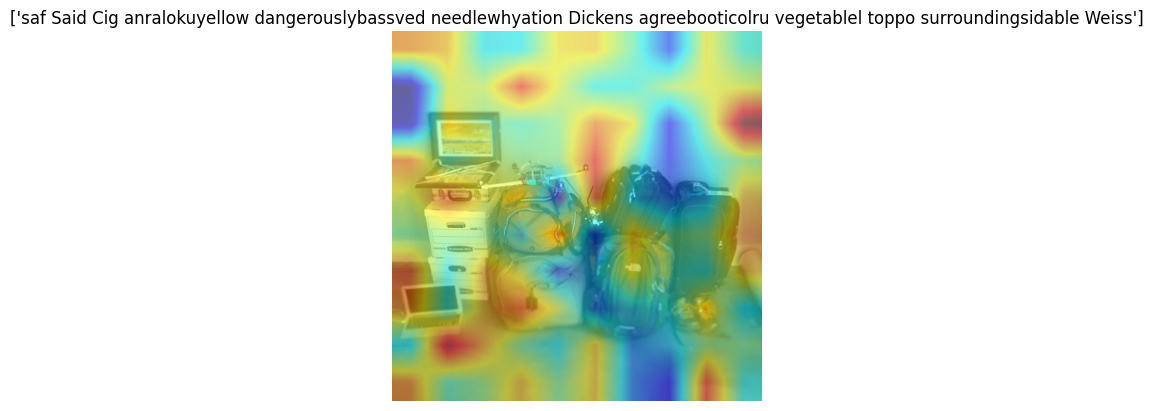

In [121]:
def overlay_attention_on_image(image_bgr, attn_map, alpha=0.5):
    """
    Overlays a 2D attention map on top of an original BGR image using OpenCV.

    Args:
        image_bgr (np.ndarray): Original image in BGR format with shape (H, W, 3).
        attn_map (np.ndarray): Attention map with shape (h, w). Will be resized to (H, W).
        alpha (float): Blending factor. 0 = only original image, 1 = only heatmap.
    
    Returns:
        overlayed (np.ndarray): The resulting image with heatmap overlay in BGR format.
    """
    # 1) Resize attention map to the same size as the image
    H, W, _ = image_bgr.shape
    attn_resized = cv2.resize(attn_map, (W, H), interpolation=cv2.INTER_LINEAR)

    # 2) Normalize attention map to [0, 1]
    attn_norm = attn_resized - attn_resized.min()
    denom = (attn_resized.max() - attn_resized.min()) + 1e-8
    attn_norm = attn_norm / denom  # shape (H, W) in [0, 1]

    # 3) Convert to 8-bit and apply a color map
    attn_255 = (attn_norm * 255).astype(np.uint8)      # (H, W)
    heatmap  = cv2.applyColorMap(attn_255, cv2.COLORMAP_JET)  # (H, W, 3) in BGR

    # 4) Alpha blend heatmap with original image
    overlayed = cv2.addWeighted(image_bgr, 1 - alpha, heatmap, alpha, 0)

    return overlayed

def evaluate(dataset,model,tokenizer,image_path=None,save_path=None):
#     model.load_state_dict(torch.load("model"),map_location = CFG.device)
    model.eval()
    loop = tqdm(dataset , total = len(test_data))
    
    for idx, (tokens, mask, prefix,caption,img_name) in enumerate(loop):
#         print(caption)

#         try:
        with torch.no_grad():
            img_id_str = f"{int(img_name):012d}"
            # 1) Load the image with OpenCV
            img_path_full =os.path.join(image_path, f"COCO_train2014_{img_id_str}.jpg")
            image_bgr = cv2.imread(img_path_full)  # shape: (H, W, 3) in BGR
            if image_bgr is None:
                print(f"Could not read image: {img_path_full}")
                continue
            
#             image_emb = torch.tensor(image).to(CFG.device)
#             image_emb = image_emb.unsqueeze(0)
#                 print("hello")
            # img_embed = torch.tensor(img_emb).float().to(CFG.device)
            img_embed = prefix.float().to(CFG.device)
            # print(img_embed.shape)
            img_embed = img_embed.unsqueeze(0)
            tokens, attn_store = model.evaluate(img_emb=img_embed, temperature=5,sampling_method="top_n_sigma")
            image_proj_tg_wt     = attn_store["image_proj_tg_wt"]       # shape [1, 10, 10]
            image_proj_xgl_tg_wt = attn_store["image_proj_xgl_tg_wt"]   # shape [1, 10]
            image_proj_ig_wt     = attn_store["image_proj_ig_wt"]       # shape [1, 10, 10]
            image_proj_xgl_ig_wt = attn_store["image_proj_xgl_ig_wt"]   # shape [1, 10]

# 1) Visualize the 2D matrix (10x10)
            matrix_tg = image_proj_tg_wt[0].cpu().numpy()
            matrix_tg = matrix_tg.squeeze(0)
            overlayed_image = overlay_attention_on_image(image_bgr, matrix_tg, alpha=0.5)
            overlayed_rgb = cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB)
            # plt.figure()
            # plt.imshow(matrix_tg, cmap='Blues', aspect='auto')
            # plt.colorbar()
            # plt.title("image_proj_tg_wt - 10x10")
            # plt.show()

# 2) Visualize the 1D vector (10)
            vector_tg_xgl = image_proj_xgl_tg_wt[0].cpu().numpy()
            vector_tg_xgl = vector_tg_xgl.squeeze(0)
            # plt.figure()
            # plt.bar(range(len(vector_tg_xgl)), vector_tg_xgl)
            # plt.title("image_proj_xgl_tg_wt - 10")
            # plt.show()
# 
#             tokens = model.evaluate(image=image_emb,second=True)
#             print(tokens)
            captions = tokenizer.batch_decode(
            tokens, skip_special_tokens=True)
            print("captions:      ",captions)
            if save_path is not None:
                print("heyy")
                # e.g., "overlayed_<idx>.jpg" or incorporate the original filename
                save_fname = f"{os.path.splitext(img_name)[0]}_overlayed.jpg"
                save_full_path = os.path.join(save_path, save_fname)
                # cv2.imwrite(save_full_path, overlayed_image)  # writes in BGR
#                 cap_list.append(decoded + "\n")
            plt.imshow( overlayed_image)
            plt.title(captions)
            plt.axis("off")
            plt.savefig(os.path.join(save_path, img_name), bbox_inches="tight")
            plt.clf()
            plt.close()
#         except IndexError :
#             pass   
#         except KeyboardInterrupt:
#             print("Intreupptrd by user")
#             break
        
        
if __name__ == "__main__":
    tokenizer =  tokenizer = GPT2Tokenizer.from_pretrained("/kaggle/input/gpt-finetuned-final-ver")
    tokenizer.bos_token = tokenizer.eos_token
    # tokenizer.pad_token = "0"
    # tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
    validdata = test_data
    model =ClipModel(ep_len=10, projection_dim=CFG.projection_dim).to(device ='cuda')
#     model = torch.nn.DataParallel(model, device_ids=[0, 1])  # Use GPU 0 and 1
#     model = model.to('cuda')
    model_path = "/kaggle/working/best.pt"
#     model.load_state_dict(torch.load(model_path, map_location=CFG.device, weights_only=True))
    checkpoint = torch.load(model_path, map_location=CFG.device)
    
    # Load the model state dictionary
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    
    dataset = validdata
    img_path = "/kaggle/input/coco-image-caption/train2014/train2014"
    save_path = '/kaggle/working/folder3'
    evaluate(dataset,model,tokenizer,img_path,save_path)
                
    

In [120]:
os.makedirs('/kaggle/working/folder3')